In [1]:
import matplotlib
matplotlib.use('Agg')
import os
import datetime
import numpy as np
import dill as pickle
import random
import sys
import seaborn as sns
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import OrderedDict
import math
from matplotlib.lines import Line2D
from pylab import rcParams
from collections import Counter
from itertools import combinations
#from datetime import datetime

from shutil import copyfile
rcParams['figure.figsize'] = 25, 10

np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)
from codes.experimentclasses.RigidEthanolPCA2 import RigidEthanolPCA2
from codes.otherfunctions.get_dictionaries import get_atoms_4
from codes.otherfunctions.get_grads import get_grads
from codes.otherfunctions.multirun import get_support_recovery_lambda
from codes.otherfunctions.multirun import get_lower_interesting_lambda
from codes.otherfunctions.multirun import get_coeffs_and_lambdas
from codes.otherfunctions.multirun import get_support
from codes.otherfunctions.multiplot import plot_support_2d
from codes.otherfunctions.multiplot import plot_reg_path_ax_lambdasearch
from codes.otherfunctions.multiplot import plot_gs_v_dgnorm
from codes.otherfunctions.multiplot import plot_dot_distributions
from codes.otherfunctions.multirun import get_cosines
from codes.flasso.Replicate import Replicate
from codes.otherfunctions.multirun import get_olsnorm_and_supportsbrute
from codes.otherfunctions.multiplot import highlight_cell

from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.geometer.ShapeSpace import ShapeSpace
from codes.geometer.TangentBundle import TangentBundle


def get_grads(experiment, Mpca, Mangles, N, selected_points):
    dimnoise = experiment.dimnoise
    dim = experiment.dim
    cores = experiment.cores

    tangent_bases = Mpca.get_wlpca_tangent_sel(Mpca, selected_points, dimnoise)
    subM = RiemannianManifold(Mpca.data[selected_points], dim)
    subM.tb = TangentBundle(subM, tangent_bases)
    N.tangent_bundle = TangentBundle(N, np.swapaxes(N.geom.rmetric.Hvv[:,:dim,:],1,2))

    df_M = experiment.get_dF_js_idM(Mpca, N, subM.tb, N.tangent_bundle, selected_points, dimnoise)
    df_M2 = df_M / np.sum(np.linalg.norm(df_M, axis=1) ** 2, axis=0)**(0.5)
    dg_x = experiment.get_dx_g_full(Mangles.data[selected_points])

    W = ShapeSpace(experiment.positions, Mangles.data)
    dw = W.get_dw(cores, experiment.atoms3, experiment.natoms, selected_points)
    dg_w = experiment.project(np.swapaxes(dw, 1, 2),
                              experiment.project(dw, dg_x))

    dg_w_pca = np.asarray([np.matmul(experiment.projector, dg_w[j].transpose()).transpose() for j in range(len(selected_points))])
    dgw_norm = experiment.normalize(dg_w_pca)
    dg_M = experiment.project(subM.tb.tangent_bases, dgw_norm)
    return (df_M, dg_M, dg_w, dg_w_pca, dgw_norm)

#set parameters
n = 10000 #number of data points to simulate
nsel = 100 #number of points to analyze with lasso
#itermax = 1000 #maximum iterations per lasso run
tol = 1e-14 #convergence criteria for lasso
#lambdas = np.asarray([0,.01,.1,1,10,100], dtype = np.float16)#lambda values for lasso
#lambdas = np.asarray(np.hstack([np.asarray([0]),np.logspace(-3,1,11)]), dtype = np.float16)
n_neighbors = 1000 #number of neighbors in megaman
m = 3 #number of embedding dimensions (diffusion maps)
#diffusion_time = 1. #diffusion time controls gaussian kernel radius per gradients paper
diffusion_time = 0.05 #(yuchia suggestion)
dim = 2 #manifold dimension
dimnoise = 2
natoms = 9
cores = 3 #number of cores for parallel processing
cor = 0.0 #correlation for noise
var = 0.0001 #variance scaler for noise
cor = 0.0 #correlation for noise
var = 10. #variance scaler for noise
ii = np.asarray([0,0,0,0,1,1,1,2]) # atom adjacencies for dihedral angle computation
jj = np.asarray([1,2,3,4,5,6,7,8])

#run experiment
atoms4 = np.asarray([[6,1,0,4],[4,0,2,8],[7,6,5,1],[3,0,2,4]],dtype = int)
nreps = 25
lambda_max = 1
max_search = 30

folder = workingdirectory + '/Figures/rigidethanol/' + now + 'n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(nreps)
os.mkdir(folder)

#src = workingdirectory + '/codes/experiments/rigidethanol_110120_nsel100_nreps25_var0.py'
#filenamescript = folder + '/script.py'
#copyfile(src, filenamescript)


/Users/samsonkoelle/manifoldflasso_jmlr


In [2]:
from codes.experimentclasses.AtomicRegression import AtomicRegression
from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.otherfunctions.data_stream import data_stream
from codes.geometer.ShapeSpace import compute3angles
import numpy as np
import math
from sklearn.decomposition import TruncatedSVD
from pathos.multiprocessing import ProcessingPool as Pool

In [7]:
#this is for use with full dictionaries
#all points are members of a different irrational field
#in order to avoid set of measure zero
#in the noiseless case
from codes.experimentclasses.AtomicRegression import AtomicRegression
from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.otherfunctions.data_stream import data_stream
from codes.geometer.ShapeSpace import compute3angles
import numpy as np
import math
from sklearn.decomposition import TruncatedSVD
from pathos.multiprocessing import ProcessingPool as Pool

class RigidEthanolPCA2(AtomicRegression):
    """
    Parameters
    ----------
    cor : string,
        Data file to load
    xvar : np.array(dtype = int),
        List of adjacencies
    jj : np.array,
        List of adjacencies part 2
    d : int,
        dimension over which to evaluate the radii (smaller usually better)
    rmin : float,
        smallest radius ( = rad_bw_ratio * bandwidth) to consider
    rmax : float,
        largest radius ( = rad_bw_ratio * bandwidth) to consider
    ntry : int,
        number of radii between rmax and rmin to try
    run_parallel : bool,
        whether to run the analysis in parallel over radii
    search_space : str,
        either 'linspace' or 'logspace', choose to search in log or linear space
    rad_bw_ratio : float,
        the ratio of radius and kernel bandwidth, default to be 3 (radius = 3*h)
    Methods
    -------
    generate_data :
        Simulates data
    get_atoms_4 :
    	Gets atomic tetrahedra based off of ii and jj
    get_atoms_3 :
    	Gets triples of atoms

    """

    # AtomicRegression(dim, ii, jj, filename)
    def __init__(self, dim, cor, xvar,ii,jj, cores, noise, custom_bonds = None):
        natoms = 9
        n = 10000
        self.cor = cor
        self.xvar = xvar
        self.cores = cores
        self.noise = noise
        AtomicRegression.__init__(self, dim,n,ii,jj, natoms, cores)
        if custom_bonds.any() != None:
            self.atoms4 = custom_bonds
            self.p = custom_bonds.shape[0]

    def generate_data(self, noise=False):
        
        
        n = self.n
        d = self.d
        cor = self.cor
        xvar = self.xvar
        natoms = self.natoms
        cores = self.cores
        atoms3 = self.atoms3
        dim = self.dim
        #noise = self.noise

        positions = np.zeros((n, 9, 3))
        # positions[0,0,:] = np.asarray([0.,0.,0.])
        # positions[0,1,:] = np.asarray([-10.,0.,0.])
        # positions[0,2,:] = np.asarray([1.,10.,0.])
        # #positions[0,8,:] = np.asarray([1.,1.,0.])
        # positions[0,8,:] = np.asarray([2.,10.,-0])
        # positions[0,3,:] = np.asarray([1., np.cos(2/3 * np.pi), np.sin(2/3 * np.pi)])
        # positions[0,4,:] = np.asarray([1., np.cos(2/3 * np.pi), np.sin(4/3 * np.pi)])
        # positions[0,5,:] = np.asarray([-12.,1.,0.])
        # positions[0,6,:] = np.asarray([-12., np.cos(2/3 * np.pi),np.sin(2/3 * np.pi)])
        # positions[0,7,:] = np.asarray([-12.,np.cos(2/3 * np.pi), np.sin(4/3 * np.pi)])
        positions[0,0,:] = np.asarray([0.,0.,0.])
        positions[0,1,:] = np.asarray([-10.,0.,np.sqrt(2)/100])
        positions[0,2,:] = np.asarray([0.,10.,np.sqrt(3)/100])
        #positions[0,8,:] = np.asarray([1.,1.,0.])
        positions[0,8,:] = np.asarray([1.,10.,np.sqrt(5)/100])
        positions[0,3,:] = np.asarray([np.sqrt(7)/100, np.cos(2/3 * np.pi), np.sin(2/3 * np.pi)])
        positions[0,4,:] = np.asarray([np.sqrt(11)/100, np.cos(2/3 * np.pi), np.sin(4/3 * np.pi)])
        positions[0,5,:] = np.asarray([-11.,1.,np.sqrt(13)/100])
        positions[0,6,:] = np.asarray([-11. , np.cos(2/3 * np.pi)+ np.sqrt(17)/1000,np.sin(2/3 * np.pi) ])
        positions[0,7,:] = np.asarray([-11., np.cos(2/3 * np.pi)+ np.sqrt(19)/100, np.sin(4/3 * np.pi)])

        angles1 = np.tile(np.linspace(start=0., stop=2 * math.pi, num=int(np.sqrt(n)), endpoint=False),
                          int(np.sqrt(n)))
        angles2 = np.repeat(np.linspace(start=0., stop=2 * math.pi, num=int(np.sqrt(n)), endpoint=False),
                            int(np.sqrt(n)))
        for i in range(1, n):
            rotationmatrix1 = np.zeros((3, 3))
            rotationmatrix1[1, 1] = 1
            rotationmatrix1[0, 0] = np.cos(angles1[i])
            rotationmatrix1[0, 2] = -np.sin(angles1[i])
            rotationmatrix1[2, 2] = np.cos(angles1[i])
            rotationmatrix1[2, 0] = np.sin(angles1[i])
            rotationmatrix2 = np.zeros((3, 3))
            rotationmatrix2[0, 0] = 1
            rotationmatrix2[1, 1] = np.cos(angles2[i])
            rotationmatrix2[1, 2] = -np.sin(angles2[i])
            rotationmatrix2[2, 2] = np.cos(angles2[i])
            rotationmatrix2[2, 1] = np.sin(angles2[i])
            positions[i, np.asarray([3, 4]), :] = positions[0, np.asarray([3, 4]), :]
            positions[i, np.asarray([2, 8]), :] = np.matmul(rotationmatrix1,
                                                            positions[0, np.asarray([2, 8]),
                                                            :].transpose()).transpose()
            positions[i, np.asarray([1, 5, 6, 7]), :] = np.matmul(rotationmatrix2,
                                                                  positions[0, np.asarray([1, 5, 6, 7]),
                                                                  :].transpose()).transpose()

        covariance = np.identity(natoms)
        for i in range(natoms):
            for j in range(natoms):
                if i != j:
                    covariance[i, j] = cor
        covariance = xvar * covariance
        print(covariance)
        if noise == True:
            for i in range(n):
                for j in range(3):
                    
                    positions[i, :, j] = np.random.multivariate_normal(positions[i, :, j], covariance, size=1)
        self.positions = positions
        p = Pool(cores)
        results = p.map(lambda i: compute3angles(position=positions[i[0], atoms3[i[1]], :]),
                            data_stream(10000, 84))
        data = np.reshape(results, (n, (d)))
        svd = TruncatedSVD(n_components=50)
        svd.fit(data)
        data_pca = svd.transform(data)
        return (RiemannianManifold(data, dim), RiemannianManifold(data_pca,dim), svd.components_)

In [54]:
new_MN = True
new_grad = True
savename = 'rigidethanol_010521_p12rep5n500_papernorm'
savefolder = 'rigidethanol'
loadfolder = 'rigidethanol'
loadname = 'rigidethanol_010521_p12rep5n500_papernorm'
var = 0.000001#var = 0.01 breaks
if new_MN == True:
    experiment = RigidEthanolPCA2(dim, cor, var, ii, jj, cores, True, atoms4)
    experiment.M, experiment.Mpca, projector = experiment.generate_data(noise=True)
    experiment.q = m
    experiment.m = m
    experiment.dimnoise = dimnoise
    experiment.projector = projector
    experiment.Mpca.geom = experiment.Mpca.compute_geom(diffusion_time, n_neighbors)
    experiment.N = experiment.Mpca.get_embedding3(experiment.Mpca.geom, m, diffusion_time, dim)
    # with open(workingdirectory + '/untracked_data/embeddings/' + savefolder + '/' + savename + '.pkl' ,
    #          'wb') as output:
    #      pickle.dump(experiment, output, pickle.HIGHEST_PROTOCOL)

atoms4,p = get_atoms_4(natoms,ii,jj)
experiment.p = p
experiment.atoms4 = atoms4
#experiment.itermax = itermax
experiment.tol = tol
experiment.dnoise = dim
experiment.nreps = nreps
experiment.nsel = nsel
experiment.folder = folder

replicates = {}
selected_points_save = np.zeros((nreps,nsel))



[[1.e-06 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e-06 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e-06 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-06 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 1.e-06 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-06 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-06 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-06 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-06]]


In [55]:

print('pre-gradient acquisition')
print(datetime.datetime.now())
for i in range(nreps):
    print(i)
    selected_points = np.random.choice(list(range(n)),nsel,replace = False)
    selected_points_save[i] = selected_points
    replicates[i] = Replicate()
    replicates[i].nsel = nsel
    replicates[i].selected_points = selected_points
    replicates[i].df_M,replicates[i].dg_M,replicates[i].dg_w ,replicates[i].dg_w_pca ,replicates[i].dgw_norm  = get_grads(experiment, experiment.Mpca, experiment.M, experiment.N, selected_points)
    replicates[i].dg_M = np.swapaxes(replicates[i].dg_M, 1,2)

pre-gradient acquisition
2021-01-11 13:28:32.490412
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [56]:

savename = 'rigidethanol_010521_p12rep5n500_papernorm_noise_p0001'
savefolder = 'rigidethanol'
loadfolder = 'rigidethanol'
loadname = 'rigidethanol_010521_p12rep5n500_papernorm_noise_p0001'

with open(workingdirectory + '/untracked_data/embeddings/' + savefolder + '/' + savename + 'replicates.pkl' ,
         'wb') as output:
     pickle.dump(replicates, output, pickle.HIGHEST_PROTOCOL)


selected_points_save = np.asarray(selected_points_save, dtype = int)
gl_itermax = 500
lambdas_start = [0.,.0005 * np.sqrt(nsel * p)]
max_search = 30
reg_l2 = 0.
card = dim
tol = 1e-14
learning_rate = 100

from pathos.multiprocessing import ProcessingPool as Pool
from codes.flasso.GradientGroupLasso import batch_stream, get_sr_lambda_sam_parallel

print('pre-gradient descent')
print(datetime.datetime.now())
cores = 16
# pcor = Pool(cores)
# results = pcor.map(lambda replicate: get_sr_lambda_sam_parallel(replicate, gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate), batch_stream(replicates))

results = {}
for r in range(nreps):
    print(r)
    results[r] = Replicate()
    results[r] = get_sr_lambda_sam_parallel(replicates[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)


with open(workingdirectory + '/untracked_data/embeddings/' + savefolder + '/' + savename + 'results.pkl' ,
         'wb') as output:
     pickle.dump(results, output, pickle.HIGHEST_PROTOCOL)

print('done')
print(datetime.datetime.now())

pre-gradient descent
2021-01-11 13:44:24.199933
0
initializing lambda search
0
lr 100
lr 50.0
1
lr 50.0
lr 25.0
lr 12.5
2
lr 12.5
3
lr 12.5
lr 6.25
4
lr 6.25
5
lr 6.25
6
lr 6.25
7
lr 6.25
8
lr 6.25
9
lr 6.25
10
lr 6.25
11
lr 6.25
12
lr 6.25
13
lr 6.25
14
lr 6.25
15
lr 6.25
16
lr 6.25
17
lr 6.25
18
lr 6.25
19
lr 6.25
20
lr 6.25
21
lr 6.25
22
lr 6.25
23
lr 6.25
24
lr 6.25
25
lr 6.25
26
lr 6.25
27
lr 6.25
28
lr 6.25
29
lr 6.25
30
lr 6.25
31
lr 6.25
32
lr 6.25
33
lr 6.25
34
lr 6.25
35
lr 6.25
36
lr 6.25
37
lr 6.25
38
lr 6.25
39
lr 6.25
40
lr 6.25
41
lr 6.25
42
lr 6.25
43
lr 6.25
44
lr 6.25
45
lr 6.25
46
lr 6.25
47
lr 6.25
48
lr 6.25
49
lr 6.25
50
lr 6.25
51
lr 6.25
52
lr 6.25
53
lr 6.25
54
lr 6.25
55
lr 6.25
56
lr 6.25
57
lr 6.25
58
lr 6.25
59
lr 6.25
60
lr 6.25
61
lr 6.25
62
lr 6.25
63
lr 6.25
64
lr 6.25
65
lr 6.25
66
lr 6.25
67
lr 6.25
68
lr 6.25
69
lr 6.25
70
lr 6.25
71
lr 6.25
72
lr 6.25
73
lr 6.25
74
lr 6.25
75
lr 6.25
76
lr 6.25
77
lr 6.25
78
lr 6.25
79
lr 6.25
80
lr 6.25
81
lr 6.25


lr 6.25
209
lr 6.25
210
lr 6.25
211
lr 6.25
212
lr 6.25
213
lr 6.25
214
lr 6.25
215
lr 6.25
216
lr 6.25
217
lr 6.25
218
lr 6.25
219
lr 6.25
220
lr 6.25
221
lr 6.25
222
lr 6.25
223
lr 6.25
224
lr 6.25
225
lr 6.25
226
lr 6.25
227
lr 6.25
228
lr 6.25
229
lr 6.25
230
lr 6.25
231
lr 6.25
232
lr 6.25
233
lr 6.25
234
lr 6.25
235
lr 6.25
236
lr 6.25
237
lr 6.25
238
lr 6.25
239
lr 6.25
240
lr 6.25
241
lr 6.25
242
lr 6.25
243
lr 6.25
244
lr 6.25
245
lr 6.25
246
lr 6.25
247
lr 6.25
248
lr 6.25
249
lr 6.25
250
lr 6.25
251
lr 6.25
252
lr 6.25
253
lr 6.25
254
lr 6.25
255
lr 6.25
256
lr 6.25
257
lr 6.25
258
lr 6.25
259
lr 6.25
260
lr 6.25
261
lr 6.25
262
lr 6.25
263
lr 6.25
264
lr 6.25
265
lr 6.25
266
lr 6.25
267
lr 6.25
268
lr 6.25
269
lr 6.25
270
lr 6.25
271
lr 6.25
272
lr 6.25
273
lr 6.25
274
lr 6.25
275
lr 6.25
276
lr 6.25
277
lr 6.25
278
lr 6.25
279
lr 6.25
280
lr 6.25
281
lr 6.25
282
lr 6.25
283
lr 6.25
284
lr 6.25
285
lr 6.25
286
lr 6.25
287
lr 6.25
288
lr 6.25
289
lr 6.25
290
lr 6.25
291
lr 6

lr 25.0
413
lr 25.0
414
lr 25.0
415
lr 25.0
416
lr 25.0
417
lr 25.0
418
lr 25.0
419
lr 25.0
420
lr 25.0
421
lr 25.0
422
lr 25.0
423
lr 25.0
424
lr 25.0
425
lr 25.0
426
lr 25.0
427
lr 25.0
428
lr 25.0
429
lr 25.0
430
lr 25.0
431
lr 25.0
432
lr 25.0
433
lr 25.0
434
lr 25.0
435
lr 25.0
436
lr 25.0
437
lr 25.0
438
lr 25.0
439
lr 25.0
440
lr 25.0
441
lr 25.0
442
lr 25.0
443
lr 25.0
444
lr 25.0
445
lr 25.0
446
lr 25.0
447
lr 25.0
448
lr 25.0
449
lr 25.0
450
lr 25.0
451
lr 25.0
452
lr 25.0
453
lr 25.0
454
lr 25.0
455
lr 25.0
456
lr 25.0
457
lr 25.0
458
lr 25.0
459
lr 25.0
460
lr 25.0
461
lr 25.0
462
lr 25.0
463
lr 25.0
464
lr 25.0
465
lr 25.0
converged 0.03464101615137755
we did it
1
initializing lambda search
0
lr 100
lr 50.0
1
lr 50.0
lr 25.0
lr 12.5
lr 6.25
2
lr 6.25
3
lr 6.25
4
lr 6.25
5
lr 6.25
6
lr 6.25
7
lr 6.25
8
lr 6.25
9
lr 6.25
10
lr 6.25
11
lr 6.25
12
lr 6.25
13
lr 6.25
14
lr 6.25
15
lr 6.25
16
lr 6.25
17
lr 6.25
18
lr 6.25
19
lr 6.25
20
lr 6.25
21
lr 6.25
22
lr 6.25
23
lr 6.25
24

154
lr 6.25
155
lr 6.25
156
lr 6.25
157
lr 6.25
158
lr 6.25
159
lr 6.25
160
lr 6.25
161
lr 6.25
162
lr 6.25
163
lr 6.25
164
lr 6.25
165
lr 6.25
166
lr 6.25
167
lr 6.25
168
lr 6.25
169
lr 6.25
170
lr 6.25
171
lr 6.25
172
lr 6.25
173
lr 6.25
174
lr 6.25
175
lr 6.25
176
lr 6.25
177
lr 6.25
178
lr 6.25
179
lr 6.25
180
lr 6.25
181
lr 6.25
182
lr 6.25
183
lr 6.25
184
lr 6.25
185
lr 6.25
186
lr 6.25
187
lr 6.25
188
lr 6.25
189
lr 6.25
190
lr 6.25
191
lr 6.25
192
lr 6.25
193
lr 6.25
194
lr 6.25
195
lr 6.25
196
lr 6.25
197
lr 6.25
198
lr 6.25
199
lr 6.25
200
lr 6.25
201
lr 6.25
202
lr 6.25
203
lr 6.25
204
lr 6.25
205
lr 6.25
206
lr 6.25
207
lr 6.25
208
lr 6.25
209
lr 6.25
210
lr 6.25
211
lr 6.25
212
lr 6.25
213
lr 6.25
214
lr 6.25
215
lr 6.25
216
lr 6.25
217
lr 6.25
218
lr 6.25
219
lr 6.25
220
lr 6.25
221
lr 6.25
222
lr 6.25
223
lr 6.25
224
lr 6.25
225
lr 6.25
226
lr 6.25
227
lr 6.25
228
lr 6.25
229
lr 6.25
230
lr 6.25
231
lr 6.25
232
lr 6.25
233
lr 6.25
234
lr 6.25
235
lr 6.25
236
lr 6.25
237


lr 25.0
385
lr 25.0
386
lr 25.0
387
lr 25.0
388
lr 25.0
389
lr 25.0
390
lr 25.0
391
lr 25.0
392
lr 25.0
393
lr 25.0
394
lr 25.0
395
lr 25.0
396
lr 25.0
397
lr 25.0
398
lr 25.0
399
lr 25.0
400
lr 25.0
401
lr 25.0
402
lr 25.0
403
lr 25.0
404
lr 25.0
405
lr 25.0
406
lr 25.0
407
lr 25.0
408
lr 25.0
409
lr 25.0
410
lr 25.0
411
lr 25.0
412
lr 25.0
413
lr 25.0
414
lr 25.0
415
lr 25.0
416
lr 25.0
417
lr 25.0
418
lr 25.0
419
lr 25.0
420
lr 25.0
421
lr 25.0
422
lr 25.0
423
lr 25.0
424
lr 25.0
425
lr 25.0
426
lr 25.0
427
lr 25.0
428
lr 25.0
429
lr 25.0
430
lr 25.0
431
lr 25.0
432
lr 25.0
433
lr 25.0
434
lr 25.0
435
lr 25.0
436
lr 25.0
437
lr 25.0
438
lr 25.0
439
lr 25.0
440
lr 25.0
441
lr 25.0
442
lr 25.0
443
lr 25.0
444
lr 25.0
445
lr 25.0
446
lr 25.0
447
lr 25.0
448
lr 25.0
449
lr 25.0
450
lr 25.0
451
lr 25.0
452
lr 25.0
453
lr 25.0
454
lr 25.0
455
lr 25.0
456
lr 25.0
457
lr 25.0
458
lr 25.0
459
lr 25.0
460
lr 25.0
461
lr 25.0
462
lr 25.0
463
lr 25.0
464
lr 25.0
465
lr 25.0
466
lr 25.0
467
lr 2

lr 12.5
132
lr 12.5
133
lr 12.5
134
lr 12.5
135
lr 12.5
136
lr 12.5
137
lr 12.5
138
lr 12.5
139
lr 12.5
140
lr 12.5
141
lr 12.5
142
lr 12.5
143
lr 12.5
144
lr 12.5
145
lr 12.5
146
lr 12.5
147
lr 12.5
148
lr 12.5
149
lr 12.5
150
lr 12.5
151
lr 12.5
152
lr 12.5
153
lr 12.5
154
lr 12.5
155
lr 12.5
156
lr 12.5
157
lr 12.5
158
lr 12.5
159
lr 12.5
160
lr 12.5
161
lr 12.5
162
lr 12.5
163
lr 12.5
164
lr 12.5
165
lr 12.5
166
lr 12.5
167
lr 12.5
168
lr 12.5
169
lr 12.5
170
lr 12.5
171
lr 12.5
172
lr 12.5
173
lr 12.5
174
lr 12.5
175
lr 12.5
176
lr 12.5
177
lr 12.5
178
lr 12.5
179
lr 12.5
180
lr 12.5
181
lr 12.5
182
lr 12.5
183
lr 12.5
184
lr 12.5
185
lr 12.5
186
lr 12.5
187
lr 12.5
188
lr 12.5
189
lr 12.5
190
lr 12.5
191
lr 12.5
192
lr 12.5
193
lr 12.5
194
lr 12.5
195
lr 12.5
196
lr 12.5
197
lr 12.5
198
lr 12.5
199
lr 12.5
200
lr 12.5
201
lr 12.5
202
lr 12.5
203
lr 12.5
204
lr 12.5
205
lr 12.5
206
lr 12.5
207
lr 12.5
208
lr 12.5
209
lr 12.5
210
lr 12.5
211
lr 12.5
212
lr 12.5
213
lr 12.5
214
lr 1

lr 100
lr 50.0
1
lr 50.0
lr 25.0
2
lr 25.0
lr 12.5
lr 6.25
3
lr 6.25
4
lr 6.25
5
lr 6.25
6
lr 6.25
7
lr 6.25
8
lr 6.25
9
lr 6.25
10
lr 6.25
11
lr 6.25
12
lr 6.25
13
lr 6.25
14
lr 6.25
15
lr 6.25
16
lr 6.25
17
lr 6.25
18
lr 6.25
19
lr 6.25
20
lr 6.25
21
lr 6.25
22
lr 6.25
23
lr 6.25
24
lr 6.25
25
lr 6.25
26
lr 6.25
27
lr 6.25
28
lr 6.25
29
lr 6.25
30
lr 6.25
31
lr 6.25
32
lr 6.25
33
lr 6.25
34
lr 6.25
35
lr 6.25
36
lr 6.25
37
lr 6.25
38
lr 6.25
39
lr 6.25
40
lr 6.25
41
lr 6.25
42
lr 6.25
43
lr 6.25
44
lr 6.25
45
lr 6.25
46
lr 6.25
47
lr 6.25
48
lr 6.25
49
lr 6.25
50
lr 6.25
51
lr 6.25
52
lr 6.25
53
lr 6.25
54
lr 6.25
55
lr 6.25
56
lr 6.25
57
lr 6.25
58
lr 6.25
59
lr 6.25
60
lr 6.25
61
lr 6.25
62
lr 6.25
63
lr 6.25
64
lr 6.25
65
lr 6.25
66
lr 6.25
67
lr 6.25
68
lr 6.25
69
lr 6.25
70
lr 6.25
71
lr 6.25
72
lr 6.25
73
lr 6.25
74
lr 6.25
75
lr 6.25
76
lr 6.25
77
lr 6.25
78
lr 6.25
79
lr 6.25
80
lr 6.25
81
lr 6.25
82
lr 6.25
83
lr 6.25
84
lr 6.25
85
lr 6.25
86
lr 6.25
87
lr 6.25
88
lr 6.25
89

lr 25.0
232
lr 25.0
233
lr 25.0
234
lr 25.0
235
lr 25.0
236
lr 25.0
237
lr 25.0
238
lr 25.0
239
lr 25.0
240
lr 25.0
241
lr 25.0
242
lr 25.0
243
lr 25.0
244
lr 25.0
245
lr 25.0
246
lr 25.0
247
lr 25.0
248
lr 25.0
249
lr 25.0
250
lr 25.0
251
lr 25.0
252
lr 25.0
253
lr 25.0
254
lr 25.0
255
lr 25.0
256
lr 25.0
257
lr 25.0
258
lr 25.0
259
lr 25.0
260
lr 25.0
261
lr 25.0
262
lr 25.0
263
lr 25.0
264
lr 25.0
265
lr 25.0
266
lr 25.0
267
lr 25.0
268
lr 25.0
269
lr 25.0
270
lr 25.0
271
lr 25.0
272
lr 25.0
273
lr 25.0
274
lr 25.0
275
lr 25.0
276
lr 25.0
277
lr 25.0
278
lr 25.0
279
lr 25.0
280
lr 25.0
281
lr 25.0
282
lr 25.0
283
lr 25.0
284
lr 25.0
285
lr 25.0
286
lr 25.0
287
lr 25.0
288
lr 25.0
289
lr 25.0
290
lr 25.0
291
lr 25.0
292
lr 25.0
293
lr 25.0
294
lr 25.0
295
lr 25.0
296
lr 25.0
297
lr 25.0
298
lr 25.0
299
lr 25.0
300
lr 25.0
301
lr 25.0
302
lr 25.0
303
lr 25.0
304
lr 25.0
305
lr 25.0
306
lr 25.0
307
lr 25.0
308
lr 25.0
309
lr 25.0
310
lr 25.0
311
lr 25.0
312
lr 25.0
313
lr 25.0
314
lr 2

453
lr 6.25
454
lr 6.25
455
lr 6.25
456
lr 6.25
457
lr 6.25
458
lr 6.25
459
lr 6.25
460
lr 6.25
461
lr 6.25
462
lr 6.25
463
lr 6.25
464
lr 6.25
465
lr 6.25
466
lr 6.25
467
lr 6.25
468
lr 6.25
469
lr 6.25
470
lr 6.25
471
lr 6.25
472
lr 6.25
473
lr 6.25
474
lr 6.25
475
lr 6.25
476
lr 6.25
477
lr 6.25
478
lr 6.25
479
lr 6.25
480
lr 6.25
481
lr 6.25
482
lr 6.25
483
lr 6.25
484
lr 6.25
485
lr 6.25
486
lr 6.25
487
lr 6.25
488
lr 6.25
489
lr 6.25
490
lr 6.25
491
lr 6.25
492
lr 6.25
493
lr 6.25
494
lr 6.25
495
lr 6.25
496
lr 6.25
497
lr 6.25
498
lr 6.25
499
lr 6.25
0
lr 100
lr 50.0
1
lr 50.0
lr 25.0
2
lr 25.0
lr 12.5
3
lr 12.5
4
lr 12.5
5
lr 12.5
lr 6.25
6
lr 6.25
7
lr 6.25
8
lr 6.25
9
lr 6.25
10
lr 6.25
11
lr 6.25
12
lr 6.25
13
lr 6.25
14
lr 6.25
15
lr 6.25
16
lr 6.25
17
lr 6.25
18
lr 6.25
19
lr 6.25
20
lr 6.25
21
lr 6.25
22
lr 6.25
23
lr 6.25
24
lr 6.25
25
lr 6.25
26
lr 6.25
27
lr 6.25
28
lr 6.25
29
lr 6.25
30
lr 6.25
31
lr 6.25
32
lr 6.25
33
lr 6.25
34
lr 6.25
35
lr 6.25
36
lr 6.25
37
lr 6.

155
lr 25.0
156
lr 25.0
157
lr 25.0
158
lr 25.0
159
lr 25.0
160
lr 25.0
161
lr 25.0
162
lr 25.0
163
lr 25.0
164
lr 25.0
165
lr 25.0
166
lr 25.0
167
lr 25.0
168
lr 25.0
169
lr 25.0
170
lr 25.0
171
lr 25.0
172
lr 25.0
173
lr 25.0
174
lr 25.0
175
lr 25.0
176
lr 25.0
177
lr 25.0
178
lr 25.0
179
lr 25.0
180
lr 25.0
181
lr 25.0
182
lr 25.0
183
lr 25.0
184
lr 25.0
185
lr 25.0
186
lr 25.0
187
lr 25.0
188
lr 25.0
189
lr 25.0
190
lr 25.0
191
lr 25.0
192
lr 25.0
193
lr 25.0
194
lr 25.0
195
lr 25.0
196
lr 25.0
197
lr 25.0
198
lr 25.0
199
lr 25.0
200
lr 25.0
201
lr 25.0
202
lr 25.0
203
lr 25.0
204
lr 25.0
205
lr 25.0
206
lr 25.0
207
lr 25.0
208
lr 25.0
209
lr 25.0
210
lr 25.0
211
lr 25.0
212
lr 25.0
213
lr 25.0
214
lr 25.0
215
lr 25.0
216
lr 25.0
217
lr 25.0
218
lr 25.0
219
lr 25.0
220
lr 25.0
221
lr 25.0
222
lr 25.0
223
lr 25.0
224
lr 25.0
225
lr 25.0
226
lr 25.0
227
lr 25.0
228
lr 25.0
229
lr 25.0
230
lr 25.0
231
lr 25.0
232
lr 25.0
233
lr 25.0
234
lr 25.0
235
lr 25.0
236
lr 25.0
237
lr 25.0
238


34
lr 6.25
35
lr 6.25
36
lr 6.25
37
lr 6.25
38
lr 6.25
39
lr 6.25
40
lr 6.25
41
lr 6.25
42
lr 6.25
43
lr 6.25
44
lr 6.25
45
lr 6.25
46
lr 6.25
47
lr 6.25
48
lr 6.25
49
lr 6.25
50
lr 6.25
51
lr 6.25
52
lr 6.25
53
lr 6.25
54
lr 6.25
55
lr 6.25
56
lr 6.25
57
lr 6.25
58
lr 6.25
59
lr 6.25
60
lr 6.25
61
lr 6.25
62
lr 6.25
63
lr 6.25
64
lr 6.25
65
lr 6.25
66
lr 6.25
67
lr 6.25
68
lr 6.25
69
lr 6.25
70
lr 6.25
71
lr 6.25
72
lr 6.25
73
lr 6.25
74
lr 6.25
75
lr 6.25
76
lr 6.25
77
lr 6.25
78
lr 6.25
79
lr 6.25
80
lr 6.25
81
lr 6.25
82
lr 6.25
83
lr 6.25
84
lr 6.25
85
lr 6.25
86
lr 6.25
87
lr 6.25
88
lr 6.25
89
lr 6.25
90
lr 6.25
91
lr 6.25
92
lr 6.25
93
lr 6.25
94
lr 6.25
95
lr 6.25
96
lr 6.25
97
lr 6.25
98
lr 6.25
99
lr 6.25
100
lr 6.25
101
lr 6.25
102
lr 6.25
103
lr 6.25
104
lr 6.25
105
lr 6.25
106
lr 6.25
107
lr 6.25
108
lr 6.25
109
lr 6.25
110
lr 6.25
111
lr 6.25
112
lr 6.25
113
lr 6.25
114
lr 6.25
115
lr 6.25
116
lr 6.25
117
lr 6.25
118
lr 6.25
119
lr 6.25
120
lr 6.25
121
lr 6.25
122
lr 6.2

248
lr 25.0
249
lr 25.0
250
lr 25.0
251
lr 25.0
252
lr 25.0
253
lr 25.0
254
lr 25.0
255
lr 25.0
256
lr 25.0
257
lr 25.0
258
lr 25.0
259
lr 25.0
260
lr 25.0
261
lr 25.0
262
lr 25.0
263
lr 25.0
264
lr 25.0
265
lr 25.0
266
lr 25.0
267
lr 25.0
268
lr 25.0
269
lr 25.0
270
lr 25.0
271
lr 25.0
272
lr 25.0
273
lr 25.0
274
lr 25.0
275
lr 25.0
276
lr 25.0
277
lr 25.0
278
lr 25.0
279
lr 25.0
280
lr 25.0
281
lr 25.0
282
lr 25.0
283
lr 25.0
284
lr 25.0
285
lr 25.0
286
lr 25.0
287
lr 25.0
288
lr 25.0
289
lr 25.0
290
lr 25.0
291
lr 25.0
292
lr 25.0
293
lr 25.0
294
lr 25.0
lr 12.5
lr 6.25
lr 3.125
lr 1.5625
295
lr 1.5625
296
lr 1.5625
297
lr 1.5625
298
lr 1.5625
299
lr 1.5625
300
lr 1.5625
301
lr 1.5625
302
lr 1.5625
303
lr 1.5625
304
lr 1.5625
305
lr 1.5625
306
lr 1.5625
307
lr 1.5625
308
lr 1.5625
309
lr 1.5625
310
lr 1.5625
311
lr 1.5625
312
lr 1.5625
313
lr 1.5625
314
lr 1.5625
315
lr 1.5625
316
lr 1.5625
317
lr 1.5625
318
lr 1.5625
319
lr 1.5625
320
lr 1.5625
321
lr 1.5625
322
lr 1.5625
323
lr 1.

144
lr 6.25
145
lr 6.25
146
lr 6.25
147
lr 6.25
148
lr 6.25
149
lr 6.25
150
lr 6.25
151
lr 6.25
152
lr 6.25
153
lr 6.25
154
lr 6.25
155
lr 6.25
156
lr 6.25
157
lr 6.25
158
lr 6.25
159
lr 6.25
160
lr 6.25
161
lr 6.25
162
lr 6.25
163
lr 6.25
164
lr 6.25
165
lr 6.25
166
lr 6.25
167
lr 6.25
168
lr 6.25
169
lr 6.25
170
lr 6.25
171
lr 6.25
172
lr 6.25
173
lr 6.25
174
lr 6.25
175
lr 6.25
176
lr 6.25
177
lr 6.25
178
lr 6.25
179
lr 6.25
180
lr 6.25
181
lr 6.25
182
lr 6.25
183
lr 6.25
184
lr 6.25
185
lr 6.25
186
lr 6.25
187
lr 6.25
188
lr 6.25
189
lr 6.25
190
lr 6.25
191
lr 6.25
192
lr 6.25
193
lr 6.25
194
lr 6.25
195
lr 6.25
196
lr 6.25
197
lr 6.25
198
lr 6.25
199
lr 6.25
200
lr 6.25
201
lr 6.25
202
lr 6.25
203
lr 6.25
204
lr 6.25
205
lr 6.25
206
lr 6.25
207
lr 6.25
208
lr 6.25
209
lr 6.25
210
lr 6.25
211
lr 6.25
212
lr 6.25
213
lr 6.25
214
lr 6.25
215
lr 6.25
216
lr 6.25
217
lr 6.25
218
lr 6.25
219
lr 6.25
220
lr 6.25
221
lr 6.25
222
lr 6.25
223
lr 6.25
224
lr 6.25
225
lr 6.25
226
lr 6.25
227


155
lr 6.25
156
lr 6.25
157
lr 6.25
158
lr 6.25
159
lr 6.25
160
lr 6.25
161
lr 6.25
162
lr 6.25
163
lr 6.25
164
lr 6.25
165
lr 6.25
166
lr 6.25
167
lr 6.25
168
lr 6.25
169
lr 6.25
170
lr 6.25
171
lr 6.25
172
lr 6.25
173
lr 6.25
174
lr 6.25
175
lr 6.25
176
lr 6.25
177
lr 6.25
178
lr 6.25
179
lr 6.25
180
lr 6.25
181
lr 6.25
182
lr 6.25
183
lr 6.25
184
lr 6.25
185
lr 6.25
186
lr 6.25
187
lr 6.25
188
lr 6.25
189
lr 6.25
190
lr 6.25
191
lr 6.25
192
lr 6.25
193
lr 6.25
194
lr 6.25
195
lr 6.25
196
lr 6.25
197
lr 6.25
198
lr 6.25
199
lr 6.25
200
lr 6.25
201
lr 6.25
202
lr 6.25
203
lr 6.25
204
lr 6.25
205
lr 6.25
206
lr 6.25
207
lr 6.25
208
lr 6.25
209
lr 6.25
210
lr 6.25
211
lr 6.25
212
lr 6.25
213
lr 6.25
214
lr 6.25
215
lr 6.25
216
lr 6.25
217
lr 6.25
218
lr 6.25
219
lr 6.25
220
lr 6.25
221
lr 6.25
222
lr 6.25
223
lr 6.25
224
lr 6.25
225
lr 6.25
226
lr 6.25
227
lr 6.25
228
lr 6.25
229
lr 6.25
230
lr 6.25
231
lr 6.25
232
lr 6.25
233
lr 6.25
234
lr 6.25
235
lr 6.25
236
lr 6.25
237
lr 6.25
238


lr 6.25
397
lr 6.25
398
lr 6.25
399
lr 6.25
400
lr 6.25
401
lr 6.25
402
lr 6.25
403
lr 6.25
404
lr 6.25
405
lr 6.25
406
lr 6.25
407
lr 6.25
408
lr 6.25
409
lr 6.25
410
lr 6.25
411
lr 6.25
412
lr 6.25
413
lr 6.25
414
lr 6.25
415
lr 6.25
416
lr 6.25
417
lr 6.25
418
lr 6.25
419
lr 6.25
420
lr 6.25
421
lr 6.25
422
lr 6.25
423
lr 6.25
424
lr 6.25
425
lr 6.25
426
lr 6.25
427
lr 6.25
428
lr 6.25
429
lr 6.25
430
lr 6.25
431
lr 6.25
432
lr 6.25
433
lr 6.25
434
lr 6.25
435
lr 6.25
436
lr 6.25
437
lr 6.25
438
lr 6.25
439
lr 6.25
440
lr 6.25
441
lr 6.25
442
lr 6.25
443
lr 6.25
444
lr 6.25
445
lr 6.25
446
lr 6.25
447
lr 6.25
448
lr 6.25
449
lr 6.25
450
lr 6.25
451
lr 6.25
452
lr 6.25
453
lr 6.25
454
lr 6.25
455
lr 6.25
456
lr 6.25
457
lr 6.25
458
lr 6.25
459
lr 6.25
460
lr 6.25
461
lr 6.25
462
lr 6.25
463
lr 6.25
464
lr 6.25
465
lr 6.25
466
lr 6.25
467
lr 6.25
468
lr 6.25
469
lr 6.25
470
lr 6.25
471
lr 6.25
472
lr 6.25
473
lr 6.25
474
lr 6.25
475
lr 6.25
476
lr 6.25
477
lr 6.25
478
lr 6.25
479
lr 6

91
lr 25.0
92
lr 25.0
93
lr 25.0
94
lr 25.0
95
lr 25.0
96
lr 25.0
97
lr 25.0
98
lr 25.0
99
lr 25.0
100
lr 25.0
101
lr 25.0
102
lr 25.0
103
lr 25.0
104
lr 25.0
105
lr 25.0
106
lr 25.0
107
lr 25.0
108
lr 25.0
109
lr 25.0
110
lr 25.0
111
lr 25.0
112
lr 25.0
113
lr 25.0
114
lr 25.0
115
lr 25.0
116
lr 25.0
117
lr 25.0
118
lr 25.0
119
lr 25.0
120
lr 25.0
121
lr 25.0
122
lr 25.0
123
lr 25.0
124
lr 25.0
125
lr 25.0
126
lr 25.0
127
lr 25.0
128
lr 25.0
129
lr 25.0
130
lr 25.0
131
lr 25.0
132
lr 25.0
133
lr 25.0
134
lr 25.0
135
lr 25.0
136
lr 25.0
137
lr 25.0
138
lr 25.0
139
lr 25.0
140
lr 25.0
141
lr 25.0
142
lr 25.0
143
lr 25.0
144
lr 25.0
145
lr 25.0
146
lr 25.0
147
lr 25.0
148
lr 25.0
149
lr 25.0
150
lr 25.0
151
lr 25.0
152
lr 25.0
153
lr 25.0
154
lr 25.0
155
lr 25.0
156
lr 25.0
157
lr 25.0
158
lr 25.0
159
lr 25.0
160
lr 25.0
161
lr 25.0
162
lr 25.0
163
lr 25.0
164
lr 25.0
165
lr 25.0
166
lr 25.0
167
lr 25.0
168
lr 25.0
169
lr 25.0
170
lr 25.0
171
lr 25.0
172
lr 25.0
173
lr 25.0
174
lr 25.0
1

lr 6.25
53
lr 6.25
54
lr 6.25
55
lr 6.25
56
lr 6.25
57
lr 6.25
58
lr 6.25
59
lr 6.25
60
lr 6.25
61
lr 6.25
62
lr 6.25
63
lr 6.25
64
lr 6.25
65
lr 6.25
66
lr 6.25
67
lr 6.25
68
lr 6.25
69
lr 6.25
70
lr 6.25
71
lr 6.25
72
lr 6.25
73
lr 6.25
74
lr 6.25
75
lr 6.25
76
lr 6.25
77
lr 6.25
78
lr 6.25
79
lr 6.25
80
lr 6.25
81
lr 6.25
82
lr 6.25
83
lr 6.25
84
lr 6.25
85
lr 6.25
86
lr 6.25
87
lr 6.25
88
lr 6.25
89
lr 6.25
90
lr 6.25
91
lr 6.25
92
lr 6.25
93
lr 6.25
94
lr 6.25
95
lr 6.25
96
lr 6.25
97
lr 6.25
98
lr 6.25
99
lr 6.25
100
lr 6.25
101
lr 6.25
102
lr 6.25
103
lr 6.25
104
lr 6.25
105
lr 6.25
106
lr 6.25
107
lr 6.25
108
lr 6.25
109
lr 6.25
110
lr 6.25
111
lr 6.25
112
lr 6.25
113
lr 6.25
114
lr 6.25
115
lr 6.25
116
lr 6.25
117
lr 6.25
118
lr 6.25
119
lr 6.25
120
lr 6.25
121
lr 6.25
122
lr 6.25
123
lr 6.25
124
lr 6.25
125
lr 6.25
126
lr 6.25
127
lr 6.25
128
lr 6.25
129
lr 6.25
130
lr 6.25
131
lr 6.25
132
lr 6.25
133
lr 6.25
134
lr 6.25
135
lr 6.25
136
lr 6.25
137
lr 6.25
138
lr 6.25
139
lr 

292
lr 6.25
293
lr 6.25
294
lr 6.25
295
lr 6.25
296
lr 6.25
297
lr 6.25
298
lr 6.25
299
lr 6.25
300
lr 6.25
301
lr 6.25
302
lr 6.25
303
lr 6.25
304
lr 6.25
305
lr 6.25
306
lr 6.25
307
lr 6.25
308
lr 6.25
309
lr 6.25
310
lr 6.25
311
lr 6.25
312
lr 6.25
313
lr 6.25
314
lr 6.25
315
lr 6.25
316
lr 6.25
317
lr 6.25
318
lr 6.25
319
lr 6.25
320
lr 6.25
321
lr 6.25
322
lr 6.25
323
lr 6.25
324
lr 6.25
325
lr 6.25
326
lr 6.25
327
lr 6.25
328
lr 6.25
329
lr 6.25
330
lr 6.25
331
lr 6.25
332
lr 6.25
333
lr 6.25
334
lr 6.25
335
lr 6.25
336
lr 6.25
337
lr 6.25
338
lr 6.25
339
lr 6.25
340
lr 6.25
341
lr 6.25
342
lr 6.25
343
lr 6.25
344
lr 6.25
345
lr 6.25
346
lr 6.25
347
lr 6.25
348
lr 6.25
349
lr 6.25
350
lr 6.25
351
lr 6.25
352
lr 6.25
353
lr 6.25
354
lr 6.25
355
lr 6.25
356
lr 6.25
357
lr 6.25
358
lr 6.25
359
lr 6.25
360
lr 6.25
361
lr 6.25
362
lr 6.25
363
lr 6.25
364
lr 6.25
365
lr 6.25
366
lr 6.25
367
lr 6.25
368
lr 6.25
369
lr 6.25
370
lr 6.25
371
lr 6.25
372
lr 6.25
373
lr 6.25
374
lr 6.25
375


lr 12.5
191
lr 12.5
192
lr 12.5
193
lr 12.5
194
lr 12.5
195
lr 12.5
196
lr 12.5
197
lr 12.5
198
lr 12.5
199
lr 12.5
200
lr 12.5
201
lr 12.5
202
lr 12.5
203
lr 12.5
204
lr 12.5
205
lr 12.5
206
lr 12.5
207
lr 12.5
208
lr 12.5
209
lr 12.5
210
lr 12.5
211
lr 12.5
212
lr 12.5
213
lr 12.5
214
lr 12.5
215
lr 12.5
216
lr 12.5
217
lr 12.5
218
lr 12.5
219
lr 12.5
220
lr 12.5
221
lr 12.5
222
lr 12.5
223
lr 12.5
224
lr 12.5
225
lr 12.5
226
lr 12.5
227
lr 12.5
228
lr 12.5
229
lr 12.5
230
lr 12.5
231
lr 12.5
232
lr 12.5
233
lr 12.5
234
lr 12.5
235
lr 12.5
236
lr 12.5
237
lr 12.5
238
lr 12.5
239
lr 12.5
240
lr 12.5
241
lr 12.5
242
lr 12.5
243
lr 12.5
244
lr 12.5
245
lr 12.5
246
lr 12.5
247
lr 12.5
248
lr 12.5
249
lr 12.5
250
lr 12.5
251
lr 12.5
252
lr 12.5
253
lr 12.5
254
lr 12.5
255
lr 12.5
256
lr 12.5
257
lr 12.5
258
lr 12.5
259
lr 12.5
260
lr 12.5
261
lr 12.5
262
lr 12.5
263
lr 12.5
264
lr 12.5
265
lr 12.5
266
lr 12.5
267
lr 12.5
268
lr 12.5
269
lr 12.5
270
lr 12.5
271
lr 12.5
272
lr 12.5
273
lr 1

382
lr 12.5
383
lr 12.5
384
lr 12.5
385
lr 12.5
386
lr 12.5
387
lr 12.5
388
lr 12.5
389
lr 12.5
390
lr 12.5
391
lr 12.5
392
lr 12.5
393
lr 12.5
394
lr 12.5
395
lr 12.5
396
lr 12.5
397
lr 12.5
398
lr 12.5
399
lr 12.5
400
lr 12.5
401
lr 12.5
402
lr 12.5
403
lr 12.5
404
lr 12.5
405
lr 12.5
406
lr 12.5
407
lr 12.5
408
lr 12.5
409
lr 12.5
410
lr 12.5
411
lr 12.5
412
lr 12.5
413
lr 12.5
414
lr 12.5
415
lr 12.5
416
lr 12.5
417
lr 12.5
418
lr 12.5
419
lr 12.5
420
lr 12.5
421
lr 12.5
422
lr 12.5
423
lr 12.5
424
lr 12.5
425
lr 12.5
426
lr 12.5
427
lr 12.5
428
lr 12.5
429
lr 12.5
430
lr 12.5
431
lr 12.5
432
lr 12.5
433
lr 12.5
434
lr 12.5
435
lr 12.5
436
lr 12.5
437
lr 12.5
438
lr 12.5
439
lr 12.5
440
lr 12.5
441
lr 12.5
442
lr 12.5
443
lr 12.5
444
lr 12.5
445
lr 12.5
446
lr 12.5
447
lr 12.5
448
lr 12.5
449
lr 12.5
450
lr 12.5
451
lr 12.5
452
lr 12.5
453
lr 12.5
454
lr 12.5
455
lr 12.5
456
lr 12.5
457
lr 12.5
458
lr 12.5
459
lr 12.5
460
lr 12.5
461
lr 12.5
462
lr 12.5
463
lr 12.5
464
lr 12.5
465


lr 6.25
167
lr 6.25
168
lr 6.25
169
lr 6.25
170
lr 6.25
171
lr 6.25
172
lr 6.25
173
lr 6.25
174
lr 6.25
175
lr 6.25
176
lr 6.25
177
lr 6.25
178
lr 6.25
179
lr 6.25
180
lr 6.25
181
lr 6.25
182
lr 6.25
183
lr 6.25
184
lr 6.25
185
lr 6.25
186
lr 6.25
187
lr 6.25
188
lr 6.25
189
lr 6.25
190
lr 6.25
191
lr 6.25
192
lr 6.25
193
lr 6.25
194
lr 6.25
195
lr 6.25
196
lr 6.25
197
lr 6.25
198
lr 6.25
199
lr 6.25
200
lr 6.25
201
lr 6.25
202
lr 6.25
203
lr 6.25
204
lr 6.25
205
lr 6.25
206
lr 6.25
207
lr 6.25
208
lr 6.25
209
lr 6.25
210
lr 6.25
211
lr 6.25
212
lr 6.25
213
lr 6.25
214
lr 6.25
215
lr 6.25
216
lr 6.25
217
lr 6.25
218
lr 6.25
219
lr 6.25
220
lr 6.25
221
lr 6.25
222
lr 6.25
223
lr 6.25
224
lr 6.25
225
lr 6.25
226
lr 6.25
227
lr 6.25
228
lr 6.25
229
lr 6.25
230
lr 6.25
231
lr 6.25
232
lr 6.25
233
lr 6.25
234
lr 6.25
235
lr 6.25
236
lr 6.25
237
lr 6.25
238
lr 6.25
239
lr 6.25
240
lr 6.25
241
lr 6.25
242
lr 6.25
243
lr 6.25
244
lr 6.25
245
lr 6.25
246
lr 6.25
247
lr 6.25
248
lr 6.25
249
lr 6

lr 6.25
413
lr 6.25
414
lr 6.25
415
lr 6.25
416
lr 6.25
417
lr 6.25
418
lr 6.25
419
lr 6.25
420
lr 6.25
421
lr 6.25
422
lr 6.25
423
lr 6.25
424
lr 6.25
425
lr 6.25
426
lr 6.25
427
lr 6.25
428
lr 6.25
429
lr 6.25
430
lr 6.25
431
lr 6.25
432
lr 6.25
433
lr 6.25
434
lr 6.25
435
lr 6.25
436
lr 6.25
437
lr 6.25
438
lr 6.25
439
lr 6.25
440
lr 6.25
441
lr 6.25
442
lr 6.25
443
lr 6.25
444
lr 6.25
445
lr 6.25
446
lr 6.25
447
lr 6.25
448
lr 6.25
449
lr 6.25
450
lr 6.25
451
lr 6.25
452
lr 6.25
453
lr 6.25
454
lr 6.25
455
lr 6.25
456
lr 6.25
457
lr 6.25
458
lr 6.25
459
lr 6.25
460
lr 6.25
461
lr 6.25
462
lr 6.25
463
lr 6.25
464
lr 6.25
465
lr 6.25
466
lr 6.25
467
lr 6.25
468
lr 6.25
469
lr 6.25
470
lr 6.25
471
lr 6.25
472
lr 6.25
473
lr 6.25
474
lr 6.25
475
lr 6.25
476
lr 6.25
477
lr 6.25
478
lr 6.25
479
lr 6.25
480
lr 6.25
481
lr 6.25
482
lr 6.25
483
lr 6.25
484
lr 6.25
485
lr 6.25
486
lr 6.25
487
lr 6.25
488
lr 6.25
489
lr 6.25
490
lr 6.25
491
lr 6.25
492
lr 6.25
493
lr 6.25
494
lr 6.25
495
lr 6

lr 6.25
158
lr 6.25
159
lr 6.25
160
lr 6.25
161
lr 6.25
162
lr 6.25
163
lr 6.25
164
lr 6.25
165
lr 6.25
166
lr 6.25
167
lr 6.25
168
lr 6.25
169
lr 6.25
170
lr 6.25
171
lr 6.25
172
lr 6.25
173
lr 6.25
174
lr 6.25
175
lr 6.25
176
lr 6.25
177
lr 6.25
178
lr 6.25
179
lr 6.25
180
lr 6.25
181
lr 6.25
182
lr 6.25
183
lr 6.25
184
lr 6.25
185
lr 6.25
186
lr 6.25
187
lr 6.25
188
lr 6.25
189
lr 6.25
190
lr 6.25
191
lr 6.25
192
lr 6.25
193
lr 6.25
194
lr 6.25
195
lr 6.25
196
lr 6.25
197
lr 6.25
198
lr 6.25
199
lr 6.25
200
lr 6.25
201
lr 6.25
202
lr 6.25
203
lr 6.25
204
lr 6.25
205
lr 6.25
206
lr 6.25
207
lr 6.25
208
lr 6.25
209
lr 6.25
210
lr 6.25
211
lr 6.25
212
lr 6.25
213
lr 6.25
214
lr 6.25
215
lr 6.25
216
lr 6.25
217
lr 6.25
218
lr 6.25
219
lr 6.25
220
lr 6.25
221
lr 6.25
222
lr 6.25
223
lr 6.25
224
lr 6.25
225
lr 6.25
226
lr 6.25
227
lr 6.25
228
lr 6.25
229
lr 6.25
230
lr 6.25
231
lr 6.25
232
lr 6.25
233
lr 6.25
234
lr 6.25
235
lr 6.25
236
lr 6.25
237
lr 6.25
238
lr 6.25
239
lr 6.25
240
lr 6

356
lr 6.25
357
lr 6.25
358
lr 6.25
359
lr 6.25
360
lr 6.25
361
lr 6.25
362
lr 6.25
363
lr 6.25
364
lr 6.25
365
lr 6.25
366
lr 6.25
367
lr 6.25
368
lr 6.25
369
lr 6.25
370
lr 6.25
371
lr 6.25
372
lr 6.25
373
lr 6.25
374
lr 6.25
375
lr 6.25
376
lr 6.25
377
lr 6.25
378
lr 6.25
379
lr 6.25
380
lr 6.25
381
lr 6.25
382
lr 6.25
383
lr 6.25
384
lr 6.25
385
lr 6.25
386
lr 6.25
387
lr 6.25
388
lr 6.25
389
lr 6.25
390
lr 6.25
391
lr 6.25
392
lr 6.25
393
lr 6.25
394
lr 6.25
395
lr 6.25
396
lr 6.25
397
lr 6.25
398
lr 6.25
399
lr 6.25
400
lr 6.25
401
lr 6.25
402
lr 6.25
403
lr 6.25
404
lr 6.25
405
lr 6.25
406
lr 6.25
407
lr 6.25
408
lr 6.25
409
lr 6.25
410
lr 6.25
411
lr 6.25
412
lr 6.25
413
lr 6.25
414
lr 6.25
415
lr 6.25
416
lr 6.25
417
lr 6.25
418
lr 6.25
419
lr 6.25
420
lr 6.25
421
lr 6.25
422
lr 6.25
423
lr 6.25
424
lr 6.25
425
lr 6.25
426
lr 6.25
427
lr 6.25
428
lr 6.25
429
lr 6.25
430
lr 6.25
431
lr 6.25
432
lr 6.25
433
lr 6.25
434
lr 6.25
435
lr 6.25
436
lr 6.25
437
lr 6.25
438
lr 6.25
439


163
lr 6.25
164
lr 6.25
165
lr 6.25
166
lr 6.25
167
lr 6.25
168
lr 6.25
169
lr 6.25
170
lr 6.25
171
lr 6.25
172
lr 6.25
173
lr 6.25
174
lr 6.25
175
lr 6.25
176
lr 6.25
177
lr 6.25
178
lr 6.25
179
lr 6.25
180
lr 6.25
181
lr 6.25
182
lr 6.25
183
lr 6.25
184
lr 6.25
185
lr 6.25
186
lr 6.25
187
lr 6.25
188
lr 6.25
189
lr 6.25
190
lr 6.25
191
lr 6.25
192
lr 6.25
193
lr 6.25
194
lr 6.25
195
lr 6.25
196
lr 6.25
197
lr 6.25
198
lr 6.25
199
lr 6.25
200
lr 6.25
201
lr 6.25
202
lr 6.25
203
lr 6.25
204
lr 6.25
205
lr 6.25
206
lr 6.25
207
lr 6.25
208
lr 6.25
209
lr 6.25
210
lr 6.25
211
lr 6.25
212
lr 6.25
213
lr 6.25
214
lr 6.25
215
lr 6.25
216
lr 6.25
217
lr 6.25
218
lr 6.25
219
lr 6.25
220
lr 6.25
221
lr 6.25
222
lr 6.25
223
lr 6.25
224
lr 6.25
225
lr 6.25
226
lr 6.25
227
lr 6.25
228
lr 6.25
229
lr 6.25
230
lr 6.25
231
lr 6.25
232
lr 6.25
233
lr 6.25
234
lr 6.25
235
lr 6.25
236
lr 6.25
237
lr 6.25
238
lr 6.25
239
lr 6.25
240
lr 6.25
241
lr 6.25
242
lr 6.25
243
lr 6.25
244
lr 6.25
245
lr 6.25
246


358
lr 6.25
359
lr 6.25
360
lr 6.25
361
lr 6.25
362
lr 6.25
363
lr 6.25
364
lr 6.25
365
lr 6.25
366
lr 6.25
367
lr 6.25
368
lr 6.25
369
lr 6.25
370
lr 6.25
371
lr 6.25
372
lr 6.25
373
lr 6.25
374
lr 6.25
375
lr 6.25
376
lr 6.25
377
lr 6.25
378
lr 6.25
379
lr 6.25
380
lr 6.25
381
lr 6.25
382
lr 6.25
383
lr 6.25
384
lr 6.25
385
lr 6.25
386
lr 6.25
387
lr 6.25
388
lr 6.25
389
lr 6.25
390
lr 6.25
391
lr 6.25
392
lr 6.25
393
lr 6.25
394
lr 6.25
395
lr 6.25
396
lr 6.25
397
lr 6.25
398
lr 6.25
399
lr 6.25
400
lr 6.25
401
lr 6.25
402
lr 6.25
403
lr 6.25
404
lr 6.25
405
lr 6.25
406
lr 6.25
407
lr 6.25
408
lr 6.25
409
lr 6.25
410
lr 6.25
411
lr 6.25
412
lr 6.25
413
lr 6.25
414
lr 6.25
415
lr 6.25
416
lr 6.25
417
lr 6.25
418
lr 6.25
419
lr 6.25
420
lr 6.25
421
lr 6.25
422
lr 6.25
423
lr 6.25
424
lr 6.25
425
lr 6.25
426
lr 6.25
427
lr 6.25
428
lr 6.25
429
lr 6.25
430
lr 6.25
431
lr 6.25
432
lr 6.25
433
lr 6.25
434
lr 6.25
435
lr 6.25
436
lr 6.25
437
lr 6.25
438
lr 6.25
439
lr 6.25
440
lr 6.25
441


194
lr 6.25
195
lr 6.25
196
lr 6.25
197
lr 6.25
198
lr 6.25
199
lr 6.25
200
lr 6.25
201
lr 6.25
202
lr 6.25
203
lr 6.25
204
lr 6.25
205
lr 6.25
206
lr 6.25
207
lr 6.25
208
lr 6.25
209
lr 6.25
210
lr 6.25
211
lr 6.25
212
lr 6.25
213
lr 6.25
214
lr 6.25
215
lr 6.25
216
lr 6.25
217
lr 6.25
218
lr 6.25
219
lr 6.25
220
lr 6.25
221
lr 6.25
222
lr 6.25
223
lr 6.25
224
lr 6.25
225
lr 6.25
226
lr 6.25
227
lr 6.25
228
lr 6.25
229
lr 6.25
230
lr 6.25
231
lr 6.25
232
lr 6.25
233
lr 6.25
234
lr 6.25
235
lr 6.25
236
lr 6.25
237
lr 6.25
238
lr 6.25
239
lr 6.25
240
lr 6.25
241
lr 6.25
242
lr 6.25
243
lr 6.25
244
lr 6.25
245
lr 6.25
246
lr 6.25
247
lr 6.25
248
lr 6.25
249
lr 6.25
250
lr 6.25
251
lr 6.25
252
lr 6.25
253
lr 6.25
254
lr 6.25
255
lr 6.25
256
lr 6.25
257
lr 6.25
258
lr 6.25
259
lr 6.25
260
lr 6.25
261
lr 6.25
262
lr 6.25
263
lr 6.25
264
lr 6.25
265
lr 6.25
266
lr 6.25
267
lr 6.25
268
lr 6.25
269
lr 6.25
270
lr 6.25
271
lr 6.25
272
lr 6.25
273
lr 6.25
274
lr 6.25
275
lr 6.25
276
lr 6.25
277


lr 6.25
418
lr 6.25
419
lr 6.25
420
lr 6.25
421
lr 6.25
422
lr 6.25
423
lr 6.25
424
lr 6.25
425
lr 6.25
426
lr 6.25
427
lr 6.25
428
lr 6.25
429
lr 6.25
430
lr 6.25
431
lr 6.25
432
lr 6.25
433
lr 6.25
434
lr 6.25
435
lr 6.25
436
lr 6.25
437
lr 6.25
438
lr 6.25
439
lr 6.25
440
lr 6.25
441
lr 6.25
442
lr 6.25
443
lr 6.25
444
lr 6.25
445
lr 6.25
446
lr 6.25
447
lr 6.25
448
lr 6.25
449
lr 6.25
450
lr 6.25
451
lr 6.25
452
lr 6.25
453
lr 6.25
454
lr 6.25
455
lr 6.25
456
lr 6.25
457
lr 6.25
458
lr 6.25
459
lr 6.25
460
lr 6.25
461
lr 6.25
462
lr 6.25
463
lr 6.25
464
lr 6.25
465
lr 6.25
466
lr 6.25
467
lr 6.25
468
lr 6.25
469
lr 6.25
470
lr 6.25
471
lr 6.25
472
lr 6.25
473
lr 6.25
474
lr 6.25
475
lr 6.25
476
lr 6.25
477
lr 6.25
478
lr 6.25
479
lr 6.25
480
lr 6.25
481
lr 6.25
482
lr 6.25
483
lr 6.25
484
lr 6.25
485
lr 6.25
486
lr 6.25
487
lr 6.25
488
lr 6.25
489
lr 6.25
490
lr 6.25
491
lr 6.25
492
lr 6.25
493
lr 6.25
494
lr 6.25
495
lr 6.25
496
lr 6.25
497
lr 6.25
498
lr 6.25
499
lr 6.25
we did i

lr 6.25
153
lr 6.25
154
lr 6.25
155
lr 6.25
156
lr 6.25
157
lr 6.25
158
lr 6.25
159
lr 6.25
160
lr 6.25
161
lr 6.25
162
lr 6.25
163
lr 6.25
164
lr 6.25
165
lr 6.25
166
lr 6.25
167
lr 6.25
168
lr 6.25
169
lr 6.25
170
lr 6.25
171
lr 6.25
172
lr 6.25
173
lr 6.25
174
lr 6.25
175
lr 6.25
176
lr 6.25
177
lr 6.25
178
lr 6.25
179
lr 6.25
180
lr 6.25
181
lr 6.25
182
lr 6.25
183
lr 6.25
184
lr 6.25
185
lr 6.25
186
lr 6.25
187
lr 6.25
188
lr 6.25
189
lr 6.25
190
lr 6.25
191
lr 6.25
192
lr 6.25
193
lr 6.25
194
lr 6.25
195
lr 6.25
196
lr 6.25
197
lr 6.25
198
lr 6.25
199
lr 6.25
200
lr 6.25
201
lr 6.25
202
lr 6.25
203
lr 6.25
204
lr 6.25
205
lr 6.25
206
lr 6.25
207
lr 6.25
208
lr 6.25
209
lr 6.25
210
lr 6.25
211
lr 6.25
212
lr 6.25
213
lr 6.25
214
lr 6.25
215
lr 6.25
216
lr 6.25
217
lr 6.25
218
lr 6.25
219
lr 6.25
220
lr 6.25
221
lr 6.25
222
lr 6.25
223
lr 6.25
224
lr 6.25
225
lr 6.25
226
lr 6.25
227
lr 6.25
228
lr 6.25
229
lr 6.25
230
lr 6.25
231
lr 6.25
232
lr 6.25
233
lr 6.25
234
lr 6.25
235
lr 6

lr 25.0
346
lr 25.0
347
lr 25.0
348
lr 25.0
349
lr 25.0
350
lr 25.0
351
lr 25.0
352
lr 25.0
353
lr 25.0
354
lr 25.0
355
lr 25.0
356
lr 25.0
357
lr 25.0
358
lr 25.0
359
lr 25.0
360
lr 25.0
361
lr 25.0
362
lr 25.0
363
lr 25.0
364
lr 25.0
365
lr 25.0
366
lr 25.0
367
lr 25.0
368
lr 25.0
369
lr 25.0
370
lr 25.0
371
lr 25.0
372
lr 25.0
373
lr 25.0
374
lr 25.0
375
lr 25.0
376
lr 25.0
377
lr 25.0
378
lr 25.0
379
lr 25.0
380
lr 25.0
381
lr 25.0
382
lr 25.0
383
lr 25.0
384
lr 25.0
385
lr 25.0
386
lr 25.0
387
lr 25.0
388
lr 25.0
389
lr 25.0
390
lr 25.0
391
lr 25.0
392
lr 25.0
393
lr 25.0
394
lr 25.0
395
lr 25.0
396
lr 25.0
397
lr 25.0
398
lr 25.0
399
lr 25.0
400
lr 25.0
401
lr 25.0
402
lr 25.0
403
lr 25.0
404
lr 25.0
405
lr 25.0
406
lr 25.0
407
lr 25.0
408
lr 25.0
409
lr 25.0
410
lr 25.0
411
lr 25.0
412
lr 25.0
413
lr 25.0
414
lr 25.0
415
lr 25.0
416
lr 25.0
417
lr 25.0
418
lr 25.0
419
lr 25.0
420
lr 25.0
421
lr 25.0
422
lr 25.0
423
lr 25.0
424
lr 25.0
425
lr 25.0
426
lr 25.0
427
lr 25.0
428
lr 2

lr 12.5
17
lr 12.5
18
lr 12.5
19
lr 12.5
20
lr 12.5
21
lr 12.5
22
lr 12.5
23
lr 12.5
24
lr 12.5
25
lr 12.5
26
lr 12.5
27
lr 12.5
28
lr 12.5
29
lr 12.5
30
lr 12.5
31
lr 12.5
32
lr 12.5
33
lr 12.5
34
lr 12.5
35
lr 12.5
36
lr 12.5
37
lr 12.5
38
lr 12.5
39
lr 12.5
40
lr 12.5
41
lr 12.5
42
lr 12.5
43
lr 12.5
44
lr 12.5
45
lr 12.5
46
lr 12.5
47
lr 12.5
48
lr 12.5
49
lr 12.5
50
lr 12.5
51
lr 12.5
52
lr 12.5
53
lr 12.5
54
lr 12.5
55
lr 12.5
56
lr 12.5
57
lr 12.5
58
lr 12.5
59
lr 12.5
60
lr 12.5
61
lr 12.5
62
lr 12.5
63
lr 12.5
64
lr 12.5
65
lr 12.5
66
lr 12.5
67
lr 12.5
68
lr 12.5
69
lr 12.5
70
lr 12.5
71
lr 12.5
72
lr 12.5
73
lr 12.5
74
lr 12.5
75
lr 12.5
76
lr 12.5
77
lr 12.5
78
lr 12.5
79
lr 12.5
80
lr 12.5
81
lr 12.5
82
lr 12.5
83
lr 12.5
84
lr 12.5
85
lr 12.5
86
lr 12.5
87
lr 12.5
88
lr 12.5
89
lr 12.5
90
lr 12.5
91
lr 12.5
92
lr 12.5
93
lr 12.5
94
lr 12.5
95
lr 12.5
96
lr 12.5
97
lr 12.5
98
lr 12.5
99
lr 12.5
100
lr 12.5
101
lr 12.5
102
lr 12.5
103
lr 12.5
104
lr 12.5
105
lr 12.5
106
lr 

lr 6.25
399
lr 6.25
400
lr 6.25
401
lr 6.25
402
lr 6.25
403
lr 6.25
404
lr 6.25
405
lr 6.25
406
lr 6.25
407
lr 6.25
408
lr 6.25
409
lr 6.25
410
lr 6.25
411
lr 6.25
412
lr 6.25
413
lr 6.25
414
lr 6.25
415
lr 6.25
416
lr 6.25
417
lr 6.25
418
lr 6.25
419
lr 6.25
420
lr 6.25
421
lr 6.25
422
lr 6.25
423
lr 6.25
424
lr 6.25
425
lr 6.25
426
lr 6.25
427
lr 6.25
428
lr 6.25
429
lr 6.25
430
lr 6.25
431
lr 6.25
432
lr 6.25
433
lr 6.25
434
lr 6.25
435
lr 6.25
436
lr 6.25
437
lr 6.25
438
lr 6.25
439
lr 6.25
440
lr 6.25
441
lr 6.25
442
lr 6.25
443
lr 6.25
444
lr 6.25
445
lr 6.25
446
lr 6.25
447
lr 6.25
448
lr 6.25
449
lr 6.25
450
lr 6.25
451
lr 6.25
452
lr 6.25
453
lr 6.25
454
lr 6.25
455
lr 6.25
456
lr 6.25
457
lr 6.25
458
lr 6.25
459
lr 6.25
460
lr 6.25
461
lr 6.25
462
lr 6.25
463
lr 6.25
464
lr 6.25
465
lr 6.25
466
lr 6.25
467
lr 6.25
468
lr 6.25
469
lr 6.25
470
lr 6.25
471
lr 6.25
472
lr 6.25
473
lr 6.25
474
lr 6.25
475
lr 6.25
476
lr 6.25
477
lr 6.25
478
lr 6.25
479
lr 6.25
480
lr 6.25
481
lr 6

123
lr 25.0
124
lr 25.0
125
lr 25.0
126
lr 25.0
127
lr 25.0
128
lr 25.0
129
lr 25.0
130
lr 25.0
131
lr 25.0
132
lr 25.0
133
lr 25.0
134
lr 25.0
135
lr 25.0
136
lr 25.0
137
lr 25.0
138
lr 25.0
139
lr 25.0
140
lr 25.0
141
lr 25.0
142
lr 25.0
143
lr 25.0
144
lr 25.0
145
lr 25.0
146
lr 25.0
147
lr 25.0
148
lr 25.0
149
lr 25.0
150
lr 25.0
151
lr 25.0
152
lr 25.0
153
lr 25.0
154
lr 25.0
155
lr 25.0
156
lr 25.0
157
lr 25.0
158
lr 25.0
159
lr 25.0
160
lr 25.0
161
lr 25.0
162
lr 25.0
163
lr 25.0
164
lr 25.0
165
lr 25.0
166
lr 25.0
167
lr 25.0
168
lr 25.0
169
lr 25.0
170
lr 25.0
171
lr 25.0
172
lr 25.0
173
lr 25.0
174
lr 25.0
175
lr 25.0
176
lr 25.0
177
lr 25.0
178
lr 25.0
179
lr 25.0
180
lr 25.0
181
lr 25.0
182
lr 25.0
183
lr 25.0
184
lr 25.0
185
lr 25.0
186
lr 25.0
187
lr 25.0
188
lr 25.0
189
lr 25.0
190
lr 25.0
191
lr 25.0
192
lr 25.0
193
lr 25.0
194
lr 25.0
195
lr 25.0
196
lr 25.0
197
lr 25.0
198
lr 25.0
199
lr 25.0
200
lr 25.0
201
lr 25.0
202
lr 25.0
203
lr 25.0
204
lr 25.0
205
lr 25.0
206


66
lr 6.25
67
lr 6.25
68
lr 6.25
69
lr 6.25
70
lr 6.25
71
lr 6.25
72
lr 6.25
73
lr 6.25
74
lr 6.25
75
lr 6.25
76
lr 6.25
77
lr 6.25
78
lr 6.25
79
lr 6.25
80
lr 6.25
81
lr 6.25
82
lr 6.25
83
lr 6.25
84
lr 6.25
85
lr 6.25
86
lr 6.25
87
lr 6.25
88
lr 6.25
89
lr 6.25
90
lr 6.25
91
lr 6.25
92
lr 6.25
93
lr 6.25
94
lr 6.25
95
lr 6.25
96
lr 6.25
97
lr 6.25
98
lr 6.25
99
lr 6.25
100
lr 6.25
101
lr 6.25
102
lr 6.25
103
lr 6.25
104
lr 6.25
105
lr 6.25
106
lr 6.25
107
lr 6.25
108
lr 6.25
109
lr 6.25
110
lr 6.25
111
lr 6.25
112
lr 6.25
113
lr 6.25
114
lr 6.25
115
lr 6.25
116
lr 6.25
117
lr 6.25
118
lr 6.25
119
lr 6.25
120
lr 6.25
121
lr 6.25
122
lr 6.25
123
lr 6.25
124
lr 6.25
125
lr 6.25
126
lr 6.25
127
lr 6.25
128
lr 6.25
129
lr 6.25
130
lr 6.25
131
lr 6.25
132
lr 6.25
133
lr 6.25
134
lr 6.25
135
lr 6.25
136
lr 6.25
137
lr 6.25
138
lr 6.25
139
lr 6.25
140
lr 6.25
141
lr 6.25
142
lr 6.25
143
lr 6.25
144
lr 6.25
145
lr 6.25
146
lr 6.25
147
lr 6.25
148
lr 6.25
149
lr 6.25
150
lr 6.25
151
lr 6.25
15

294
lr 6.25
295
lr 6.25
296
lr 6.25
297
lr 6.25
298
lr 6.25
299
lr 6.25
300
lr 6.25
301
lr 6.25
302
lr 6.25
303
lr 6.25
304
lr 6.25
305
lr 6.25
306
lr 6.25
307
lr 6.25
308
lr 6.25
309
lr 6.25
310
lr 6.25
311
lr 6.25
312
lr 6.25
313
lr 6.25
314
lr 6.25
315
lr 6.25
316
lr 6.25
317
lr 6.25
318
lr 6.25
319
lr 6.25
320
lr 6.25
321
lr 6.25
322
lr 6.25
323
lr 6.25
324
lr 6.25
325
lr 6.25
326
lr 6.25
327
lr 6.25
328
lr 6.25
329
lr 6.25
330
lr 6.25
331
lr 6.25
332
lr 6.25
333
lr 6.25
334
lr 6.25
335
lr 6.25
336
lr 6.25
337
lr 6.25
338
lr 6.25
339
lr 6.25
340
lr 6.25
341
lr 6.25
342
lr 6.25
343
lr 6.25
344
lr 6.25
345
lr 6.25
346
lr 6.25
347
lr 6.25
348
lr 6.25
349
lr 6.25
350
lr 6.25
351
lr 6.25
352
lr 6.25
353
lr 6.25
354
lr 6.25
355
lr 6.25
356
lr 6.25
357
lr 6.25
358
lr 6.25
359
lr 6.25
360
lr 6.25
361
lr 6.25
362
lr 6.25
363
lr 6.25
364
lr 6.25
365
lr 6.25
366
lr 6.25
367
lr 6.25
368
lr 6.25
369
lr 6.25
370
lr 6.25
371
lr 6.25
372
lr 6.25
373
lr 6.25
374
lr 6.25
375
lr 6.25
376
lr 6.25
377


37
lr 25.0
38
lr 25.0
39
lr 25.0
40
lr 25.0
41
lr 25.0
42
lr 25.0
43
lr 25.0
44
lr 25.0
45
lr 25.0
46
lr 25.0
47
lr 25.0
48
lr 25.0
49
lr 25.0
50
lr 25.0
51
lr 25.0
52
lr 25.0
53
lr 25.0
54
lr 25.0
55
lr 25.0
56
lr 25.0
57
lr 25.0
58
lr 25.0
59
lr 25.0
60
lr 25.0
61
lr 25.0
62
lr 25.0
63
lr 25.0
64
lr 25.0
65
lr 25.0
66
lr 25.0
67
lr 25.0
68
lr 25.0
69
lr 25.0
70
lr 25.0
71
lr 25.0
72
lr 25.0
73
lr 25.0
74
lr 25.0
75
lr 25.0
76
lr 25.0
77
lr 25.0
78
lr 25.0
79
lr 25.0
80
lr 25.0
81
lr 25.0
82
lr 25.0
83
lr 25.0
84
lr 25.0
85
lr 25.0
86
lr 25.0
87
lr 25.0
88
lr 25.0
89
lr 25.0
90
lr 25.0
91
lr 25.0
92
lr 25.0
93
lr 25.0
94
lr 25.0
95
lr 25.0
96
lr 25.0
97
lr 25.0
98
lr 25.0
99
lr 25.0
100
lr 25.0
101
lr 25.0
102
lr 25.0
103
lr 25.0
104
lr 25.0
105
lr 25.0
106
lr 25.0
107
lr 25.0
108
lr 25.0
109
lr 25.0
110
lr 25.0
111
lr 25.0
112
lr 25.0
113
lr 25.0
114
lr 25.0
115
lr 25.0
116
lr 25.0
117
lr 25.0
118
lr 25.0
119
lr 25.0
120
lr 25.0
121
lr 25.0
122
lr 25.0
123
lr 25.0
124
lr 25.0
125
lr 

lr 6.25
460
lr 6.25
461
lr 6.25
462
lr 6.25
463
lr 6.25
464
lr 6.25
465
lr 6.25
466
lr 6.25
467
lr 6.25
468
lr 6.25
469
lr 6.25
470
lr 6.25
471
lr 6.25
472
lr 6.25
473
lr 6.25
474
lr 6.25
475
lr 6.25
476
lr 6.25
477
lr 6.25
478
lr 6.25
479
lr 6.25
480
lr 6.25
481
lr 6.25
482
lr 6.25
483
lr 6.25
484
lr 6.25
485
lr 6.25
486
lr 6.25
487
lr 6.25
488
lr 6.25
489
lr 6.25
490
lr 6.25
491
lr 6.25
492
lr 6.25
493
lr 6.25
494
lr 6.25
495
lr 6.25
496
lr 6.25
497
lr 6.25
498
lr 6.25
499
lr 6.25
0
lr 100
lr 50.0
1
lr 50.0
lr 25.0
2
lr 25.0
lr 12.5
lr 6.25
3
lr 6.25
4
lr 6.25
5
lr 6.25
6
lr 6.25
7
lr 6.25
8
lr 6.25
9
lr 6.25
10
lr 6.25
11
lr 6.25
12
lr 6.25
13
lr 6.25
14
lr 6.25
15
lr 6.25
16
lr 6.25
17
lr 6.25
18
lr 6.25
19
lr 6.25
20
lr 6.25
21
lr 6.25
22
lr 6.25
23
lr 6.25
24
lr 6.25
25
lr 6.25
26
lr 6.25
27
lr 6.25
28
lr 6.25
29
lr 6.25
30
lr 6.25
31
lr 6.25
32
lr 6.25
33
lr 6.25
34
lr 6.25
35
lr 6.25
36
lr 6.25
37
lr 6.25
38
lr 6.25
39
lr 6.25
40
lr 6.25
41
lr 6.25
42
lr 6.25
43
lr 6.25
44
lr 6

204
lr 12.5
205
lr 12.5
206
lr 12.5
207
lr 12.5
208
lr 12.5
209
lr 12.5
210
lr 12.5
211
lr 12.5
212
lr 12.5
213
lr 12.5
214
lr 12.5
215
lr 12.5
216
lr 12.5
217
lr 12.5
218
lr 12.5
219
lr 12.5
220
lr 12.5
221
lr 12.5
222
lr 12.5
223
lr 12.5
224
lr 12.5
225
lr 12.5
226
lr 12.5
227
lr 12.5
228
lr 12.5
229
lr 12.5
230
lr 12.5
231
lr 12.5
232
lr 12.5
233
lr 12.5
234
lr 12.5
235
lr 12.5
236
lr 12.5
237
lr 12.5
238
lr 12.5
239
lr 12.5
240
lr 12.5
241
lr 12.5
242
lr 12.5
243
lr 12.5
244
lr 12.5
245
lr 12.5
246
lr 12.5
247
lr 12.5
248
lr 12.5
249
lr 12.5
250
lr 12.5
251
lr 12.5
252
lr 12.5
253
lr 12.5
254
lr 12.5
255
lr 12.5
256
lr 12.5
257
lr 12.5
258
lr 12.5
259
lr 12.5
260
lr 12.5
261
lr 12.5
262
lr 12.5
263
lr 12.5
264
lr 12.5
265
lr 12.5
266
lr 12.5
267
lr 12.5
268
lr 12.5
269
lr 12.5
270
lr 12.5
271
lr 12.5
272
lr 12.5
273
lr 12.5
274
lr 12.5
275
lr 12.5
276
lr 12.5
277
lr 12.5
278
lr 12.5
279
lr 12.5
280
lr 12.5
281
lr 12.5
282
lr 12.5
283
lr 12.5
284
lr 12.5
285
lr 12.5
286
lr 12.5
287


lr 6.25
422
lr 6.25
423
lr 6.25
424
lr 6.25
425
lr 6.25
426
lr 6.25
427
lr 6.25
428
lr 6.25
429
lr 6.25
430
lr 6.25
431
lr 6.25
432
lr 6.25
433
lr 6.25
434
lr 6.25
435
lr 6.25
436
lr 6.25
437
lr 6.25
438
lr 6.25
439
lr 6.25
440
lr 6.25
441
lr 6.25
442
lr 6.25
443
lr 6.25
444
lr 6.25
445
lr 6.25
446
lr 6.25
447
lr 6.25
448
lr 6.25
449
lr 6.25
450
lr 6.25
451
lr 6.25
452
lr 6.25
453
lr 6.25
454
lr 6.25
455
lr 6.25
456
lr 6.25
457
lr 6.25
458
lr 6.25
459
lr 6.25
460
lr 6.25
461
lr 6.25
462
lr 6.25
463
lr 6.25
464
lr 6.25
465
lr 6.25
466
lr 6.25
467
lr 6.25
468
lr 6.25
469
lr 6.25
470
lr 6.25
471
lr 6.25
472
lr 6.25
473
lr 6.25
474
lr 6.25
475
lr 6.25
476
lr 6.25
477
lr 6.25
478
lr 6.25
479
lr 6.25
480
lr 6.25
481
lr 6.25
482
lr 6.25
483
lr 6.25
484
lr 6.25
485
lr 6.25
486
lr 6.25
487
lr 6.25
488
lr 6.25
489
lr 6.25
490
lr 6.25
491
lr 6.25
492
lr 6.25
493
lr 6.25
494
lr 6.25
495
lr 6.25
496
lr 6.25
497
lr 6.25
498
lr 6.25
499
lr 6.25
0
lr 100
lr 50.0
1
lr 50.0
2
lr 50.0
lr 25.0
lr 12.5
lr 

159
lr 25.0
160
lr 25.0
161
lr 25.0
162
lr 25.0
163
lr 25.0
164
lr 25.0
165
lr 25.0
166
lr 25.0
167
lr 25.0
168
lr 25.0
169
lr 25.0
170
lr 25.0
171
lr 25.0
172
lr 25.0
173
lr 25.0
174
lr 25.0
175
lr 25.0
176
lr 25.0
177
lr 25.0
178
lr 25.0
179
lr 25.0
180
lr 25.0
181
lr 25.0
182
lr 25.0
183
lr 25.0
184
lr 25.0
185
lr 25.0
186
lr 25.0
187
lr 25.0
188
lr 25.0
189
lr 25.0
190
lr 25.0
191
lr 25.0
192
lr 25.0
193
lr 25.0
194
lr 25.0
195
lr 25.0
196
lr 25.0
197
lr 25.0
198
lr 25.0
199
lr 25.0
200
lr 25.0
201
lr 25.0
202
lr 25.0
203
lr 25.0
204
lr 25.0
205
lr 25.0
206
lr 25.0
207
lr 25.0
208
lr 25.0
209
lr 25.0
210
lr 25.0
211
lr 25.0
212
lr 25.0
213
lr 25.0
214
lr 25.0
215
lr 25.0
216
lr 25.0
217
lr 25.0
218
lr 25.0
219
lr 25.0
220
lr 25.0
221
lr 25.0
222
lr 25.0
223
lr 25.0
224
lr 25.0
225
lr 25.0
226
lr 25.0
227
lr 25.0
228
lr 25.0
229
lr 25.0
230
lr 25.0
231
lr 25.0
232
lr 25.0
233
lr 25.0
234
lr 25.0
235
lr 25.0
236
lr 25.0
237
lr 25.0
238
lr 25.0
239
lr 25.0
240
lr 25.0
241
lr 25.0
242


lr 6.25
65
lr 6.25
66
lr 6.25
67
lr 6.25
68
lr 6.25
69
lr 6.25
70
lr 6.25
71
lr 6.25
72
lr 6.25
73
lr 6.25
74
lr 6.25
75
lr 6.25
76
lr 6.25
77
lr 6.25
78
lr 6.25
79
lr 6.25
80
lr 6.25
81
lr 6.25
82
lr 6.25
83
lr 6.25
84
lr 6.25
85
lr 6.25
86
lr 6.25
87
lr 6.25
88
lr 6.25
89
lr 6.25
90
lr 6.25
91
lr 6.25
92
lr 6.25
93
lr 6.25
94
lr 6.25
95
lr 6.25
96
lr 6.25
97
lr 6.25
98
lr 6.25
99
lr 6.25
100
lr 6.25
101
lr 6.25
102
lr 6.25
103
lr 6.25
104
lr 6.25
105
lr 6.25
106
lr 6.25
107
lr 6.25
108
lr 6.25
109
lr 6.25
110
lr 6.25
111
lr 6.25
112
lr 6.25
113
lr 6.25
114
lr 6.25
115
lr 6.25
116
lr 6.25
117
lr 6.25
118
lr 6.25
119
lr 6.25
120
lr 6.25
121
lr 6.25
122
lr 6.25
123
lr 6.25
124
lr 6.25
125
lr 6.25
126
lr 6.25
127
lr 6.25
128
lr 6.25
129
lr 6.25
130
lr 6.25
131
lr 6.25
132
lr 6.25
133
lr 6.25
134
lr 6.25
135
lr 6.25
136
lr 6.25
137
lr 6.25
138
lr 6.25
139
lr 6.25
140
lr 6.25
141
lr 6.25
142
lr 6.25
143
lr 6.25
144
lr 6.25
145
lr 6.25
146
lr 6.25
147
lr 6.25
148
lr 6.25
149
lr 6.25
150
lr 

lr 25.0
308
lr 25.0
309
lr 25.0
310
lr 25.0
311
lr 25.0
312
lr 25.0
313
lr 25.0
314
lr 25.0
315
lr 25.0
316
lr 25.0
317
lr 25.0
318
lr 25.0
319
lr 25.0
320
lr 25.0
321
lr 25.0
322
lr 25.0
323
lr 25.0
324
lr 25.0
325
lr 25.0
326
lr 25.0
327
lr 25.0
328
lr 25.0
329
lr 25.0
330
lr 25.0
331
lr 25.0
332
lr 25.0
333
lr 25.0
334
lr 25.0
335
lr 25.0
336
lr 25.0
337
lr 25.0
338
lr 25.0
339
lr 25.0
340
lr 25.0
341
lr 25.0
342
lr 25.0
343
lr 25.0
344
lr 25.0
345
lr 25.0
346
lr 25.0
347
lr 25.0
348
lr 25.0
349
lr 25.0
350
lr 25.0
351
lr 25.0
352
lr 25.0
353
lr 25.0
354
lr 25.0
355
lr 25.0
356
lr 25.0
357
lr 25.0
358
lr 25.0
359
lr 25.0
360
lr 25.0
361
lr 25.0
362
lr 25.0
363
lr 25.0
364
lr 25.0
365
lr 25.0
366
lr 25.0
367
lr 25.0
368
lr 25.0
369
lr 25.0
370
lr 25.0
371
lr 25.0
372
lr 25.0
373
lr 25.0
374
lr 25.0
375
lr 25.0
376
lr 25.0
377
lr 25.0
378
lr 25.0
379
lr 25.0
380
lr 25.0
381
lr 25.0
382
lr 25.0
383
lr 25.0
384
lr 25.0
converged 0.03464101615137755
we did it
20
initializing lambda searc

139
lr 6.25
140
lr 6.25
141
lr 6.25
142
lr 6.25
143
lr 6.25
144
lr 6.25
145
lr 6.25
146
lr 6.25
147
lr 6.25
148
lr 6.25
149
lr 6.25
150
lr 6.25
151
lr 6.25
152
lr 6.25
153
lr 6.25
154
lr 6.25
155
lr 6.25
156
lr 6.25
157
lr 6.25
158
lr 6.25
159
lr 6.25
160
lr 6.25
161
lr 6.25
162
lr 6.25
163
lr 6.25
164
lr 6.25
165
lr 6.25
166
lr 6.25
167
lr 6.25
168
lr 6.25
169
lr 6.25
170
lr 6.25
171
lr 6.25
172
lr 6.25
173
lr 6.25
174
lr 6.25
175
lr 6.25
176
lr 6.25
177
lr 6.25
178
lr 6.25
179
lr 6.25
180
lr 6.25
181
lr 6.25
182
lr 6.25
183
lr 6.25
184
lr 6.25
185
lr 6.25
186
lr 6.25
187
lr 6.25
188
lr 6.25
189
lr 6.25
190
lr 6.25
191
lr 6.25
192
lr 6.25
193
lr 6.25
194
lr 6.25
195
lr 6.25
196
lr 6.25
197
lr 6.25
198
lr 6.25
199
lr 6.25
200
lr 6.25
201
lr 6.25
202
lr 6.25
203
lr 6.25
204
lr 6.25
205
lr 6.25
206
lr 6.25
207
lr 6.25
208
lr 6.25
209
lr 6.25
210
lr 6.25
211
lr 6.25
212
lr 6.25
213
lr 6.25
214
lr 6.25
215
lr 6.25
216
lr 6.25
217
lr 6.25
218
lr 6.25
219
lr 6.25
220
lr 6.25
221
lr 6.25
222


lr 25.0
371
lr 25.0
372
lr 25.0
373
lr 25.0
374
lr 25.0
375
lr 25.0
376
lr 25.0
377
lr 25.0
378
lr 25.0
379
lr 25.0
380
lr 25.0
381
lr 25.0
382
lr 25.0
383
lr 25.0
384
lr 25.0
385
lr 25.0
386
lr 25.0
387
lr 25.0
388
lr 25.0
389
lr 25.0
390
lr 25.0
391
lr 25.0
392
lr 25.0
393
lr 25.0
394
lr 25.0
395
lr 25.0
396
lr 25.0
397
lr 25.0
398
lr 25.0
399
lr 25.0
400
lr 25.0
401
lr 25.0
402
lr 25.0
403
lr 25.0
404
lr 25.0
405
lr 25.0
406
lr 25.0
407
lr 25.0
408
lr 25.0
409
lr 25.0
410
lr 25.0
411
lr 25.0
412
lr 25.0
413
lr 25.0
414
lr 25.0
415
lr 25.0
416
lr 25.0
417
lr 25.0
418
lr 25.0
419
lr 25.0
420
lr 25.0
421
lr 25.0
422
lr 25.0
423
lr 25.0
424
lr 25.0
425
lr 25.0
426
lr 25.0
427
lr 25.0
428
lr 25.0
429
lr 25.0
430
lr 25.0
431
lr 25.0
432
lr 25.0
433
lr 25.0
434
lr 25.0
435
lr 25.0
436
lr 25.0
437
lr 25.0
438
lr 25.0
439
lr 25.0
440
lr 25.0
441
lr 25.0
442
lr 25.0
443
lr 25.0
444
lr 25.0
445
lr 25.0
446
lr 25.0
447
lr 25.0
448
lr 25.0
449
lr 25.0
450
lr 25.0
451
lr 25.0
452
lr 25.0
453
lr 2

lr 25.0
108
lr 25.0
109
lr 25.0
110
lr 25.0
111
lr 25.0
112
lr 25.0
113
lr 25.0
114
lr 25.0
115
lr 25.0
116
lr 25.0
117
lr 25.0
118
lr 25.0
119
lr 25.0
120
lr 25.0
121
lr 25.0
122
lr 25.0
123
lr 25.0
124
lr 25.0
125
lr 25.0
126
lr 25.0
127
lr 25.0
128
lr 25.0
129
lr 25.0
130
lr 25.0
131
lr 25.0
132
lr 25.0
133
lr 25.0
134
lr 25.0
135
lr 25.0
136
lr 25.0
137
lr 25.0
138
lr 25.0
139
lr 25.0
140
lr 25.0
141
lr 25.0
142
lr 25.0
143
lr 25.0
144
lr 25.0
145
lr 25.0
146
lr 25.0
147
lr 25.0
148
lr 25.0
149
lr 25.0
150
lr 25.0
151
lr 25.0
152
lr 25.0
153
lr 25.0
154
lr 25.0
155
lr 25.0
156
lr 25.0
157
lr 25.0
158
lr 25.0
159
lr 25.0
160
lr 25.0
161
lr 25.0
162
lr 25.0
163
lr 25.0
164
lr 25.0
165
lr 25.0
166
lr 25.0
167
lr 25.0
168
lr 25.0
169
lr 25.0
170
lr 25.0
171
lr 25.0
172
lr 25.0
173
lr 25.0
174
lr 25.0
175
lr 25.0
176
lr 25.0
177
lr 25.0
178
lr 25.0
179
lr 25.0
180
lr 25.0
181
lr 25.0
182
lr 25.0
183
lr 25.0
184
lr 25.0
185
lr 25.0
186
lr 25.0
187
lr 25.0
188
lr 25.0
189
lr 25.0
190
lr 2

232
lr 100
233
lr 100
234
lr 100
235
lr 100
236
lr 100
237
lr 100
238
lr 100
239
lr 100
240
lr 100
241
lr 100
242
lr 100
243
lr 100
244
lr 100
245
lr 100
246
lr 100
247
lr 100
248
lr 100
249
lr 100
250
lr 100
251
lr 100
252
lr 100
253
lr 100
254
lr 100
255
lr 100
256
lr 100
257
lr 100
258
lr 100
259
lr 100
260
lr 100
261
lr 100
262
lr 100
263
lr 100
264
lr 100
265
lr 100
266
lr 100
267
lr 100
268
lr 100
269
lr 100
270
lr 100
271
lr 100
272
lr 100
273
lr 100
274
lr 100
275
lr 100
276
lr 100
277
lr 100
278
lr 100
279
lr 100
280
lr 100
281
lr 100
282
lr 100
283
lr 100
284
lr 100
285
lr 100
286
lr 100
287
lr 100
288
lr 100
289
lr 100
290
lr 100
291
lr 100
292
lr 100
293
lr 100
294
lr 100
295
lr 100
296
lr 100
297
lr 100
298
lr 100
299
lr 100
300
lr 100
301
lr 100
302
lr 100
303
lr 100
304
lr 100
305
lr 100
306
lr 100
307
lr 100
308
lr 100
309
lr 100
310
lr 100
311
lr 100
312
lr 100
313
lr 100
314
lr 100
315
lr 100
316
lr 100
317
lr 100
318
lr 100
319
lr 100
320
lr 100
321
lr 100
322
lr 100

lr 6.25
302
lr 6.25
303
lr 6.25
304
lr 6.25
305
lr 6.25
306
lr 6.25
307
lr 6.25
308
lr 6.25
309
lr 6.25
310
lr 6.25
311
lr 6.25
312
lr 6.25
313
lr 6.25
314
lr 6.25
315
lr 6.25
316
lr 6.25
317
lr 6.25
318
lr 6.25
319
lr 6.25
320
lr 6.25
321
lr 6.25
322
lr 6.25
323
lr 6.25
324
lr 6.25
325
lr 6.25
326
lr 6.25
327
lr 6.25
328
lr 6.25
329
lr 6.25
330
lr 6.25
331
lr 6.25
332
lr 6.25
333
lr 6.25
334
lr 6.25
335
lr 6.25
336
lr 6.25
337
lr 6.25
338
lr 6.25
339
lr 6.25
340
lr 6.25
341
lr 6.25
342
lr 6.25
343
lr 6.25
344
lr 6.25
345
lr 6.25
346
lr 6.25
347
lr 6.25
348
lr 6.25
349
lr 6.25
350
lr 6.25
351
lr 6.25
352
lr 6.25
353
lr 6.25
354
lr 6.25
355
lr 6.25
356
lr 6.25
357
lr 6.25
358
lr 6.25
359
lr 6.25
360
lr 6.25
361
lr 6.25
362
lr 6.25
363
lr 6.25
364
lr 6.25
365
lr 6.25
366
lr 6.25
367
lr 6.25
368
lr 6.25
369
lr 6.25
370
lr 6.25
371
lr 6.25
372
lr 6.25
373
lr 6.25
374
lr 6.25
375
lr 6.25
376
lr 6.25
377
lr 6.25
378
lr 6.25
379
lr 6.25
380
lr 6.25
381
lr 6.25
382
lr 6.25
383
lr 6.25
384
lr 6

lr 6.25
493
lr 6.25
494
lr 6.25
495
lr 6.25
496
lr 6.25
497
lr 6.25
498
lr 6.25
499
lr 6.25
0 0.03464101615137755 probe
0
lr 100
1
lr 100
2
lr 100
lr 50.0
lr 25.0
3
lr 25.0
4
lr 25.0
5
lr 25.0
6
lr 25.0
7
lr 25.0
8
lr 25.0
9
lr 25.0
10
lr 25.0
11
lr 25.0
12
lr 25.0
13
lr 25.0
14
lr 25.0
15
lr 25.0
lr 12.5
16
lr 12.5
17
lr 12.5
18
lr 12.5
19
lr 12.5
20
lr 12.5
21
lr 12.5
22
lr 12.5
23
lr 12.5
24
lr 12.5
25
lr 12.5
26
lr 12.5
27
lr 12.5
28
lr 12.5
29
lr 12.5
30
lr 12.5
31
lr 12.5
32
lr 12.5
33
lr 12.5
34
lr 12.5
35
lr 12.5
36
lr 12.5
37
lr 12.5
38
lr 12.5
39
lr 12.5
40
lr 12.5
41
lr 12.5
42
lr 12.5
43
lr 12.5
44
lr 12.5
45
lr 12.5
46
lr 12.5
47
lr 12.5
48
lr 12.5
49
lr 12.5
50
lr 12.5
51
lr 12.5
52
lr 12.5
53
lr 12.5
54
lr 12.5
55
lr 12.5
56
lr 12.5
57
lr 12.5
58
lr 12.5
59
lr 12.5
60
lr 12.5
61
lr 12.5
62
lr 12.5
63
lr 12.5
64
lr 12.5
65
lr 12.5
66
lr 12.5
67
lr 12.5
68
lr 12.5
69
lr 12.5
70
lr 12.5
71
lr 12.5
72
lr 12.5
73
lr 12.5
74
lr 12.5
75
lr 12.5
76
lr 12.5
77
lr 12.5
78
lr 12.5


lr 12.5
236
lr 12.5
237
lr 12.5
238
lr 12.5
239
lr 12.5
240
lr 12.5
241
lr 12.5
242
lr 12.5
243
lr 12.5
244
lr 12.5
245
lr 12.5
246
lr 12.5
247
lr 12.5
248
lr 12.5
249
lr 12.5
250
lr 12.5
251
lr 12.5
252
lr 12.5
253
lr 12.5
254
lr 12.5
255
lr 12.5
256
lr 12.5
257
lr 12.5
258
lr 12.5
259
lr 12.5
260
lr 12.5
261
lr 12.5
262
lr 12.5
263
lr 12.5
264
lr 12.5
265
lr 12.5
266
lr 12.5
267
lr 12.5
268
lr 12.5
269
lr 12.5
270
lr 12.5
271
lr 12.5
272
lr 12.5
273
lr 12.5
274
lr 12.5
275
lr 12.5
276
lr 12.5
277
lr 12.5
278
lr 12.5
279
lr 12.5
280
lr 12.5
281
lr 12.5
282
lr 12.5
283
lr 12.5
284
lr 12.5
285
lr 12.5
286
lr 12.5
287
lr 12.5
288
lr 12.5
289
lr 12.5
290
lr 12.5
291
lr 12.5
292
lr 12.5
293
lr 12.5
294
lr 12.5
295
lr 12.5
296
lr 12.5
297
lr 12.5
298
lr 12.5
299
lr 12.5
300
lr 12.5
301
lr 12.5
302
lr 12.5
303
lr 12.5
304
lr 12.5
305
lr 12.5
306
lr 12.5
307
lr 12.5
308
lr 12.5
309
lr 12.5
310
lr 12.5
311
lr 12.5
312
lr 12.5
313
lr 12.5
314
lr 12.5
315
lr 12.5
316
lr 12.5
317
lr 12.5
318
lr 1

lr 6.25
117
lr 6.25
118
lr 6.25
119
lr 6.25
120
lr 6.25
121
lr 6.25
122
lr 6.25
123
lr 6.25
124
lr 6.25
125
lr 6.25
126
lr 6.25
127
lr 6.25
128
lr 6.25
129
lr 6.25
130
lr 6.25
131
lr 6.25
132
lr 6.25
133
lr 6.25
134
lr 6.25
135
lr 6.25
136
lr 6.25
137
lr 6.25
138
lr 6.25
139
lr 6.25
140
lr 6.25
141
lr 6.25
142
lr 6.25
143
lr 6.25
144
lr 6.25
145
lr 6.25
146
lr 6.25
147
lr 6.25
148
lr 6.25
149
lr 6.25
150
lr 6.25
151
lr 6.25
152
lr 6.25
153
lr 6.25
154
lr 6.25
155
lr 6.25
156
lr 6.25
157
lr 6.25
158
lr 6.25
159
lr 6.25
160
lr 6.25
161
lr 6.25
162
lr 6.25
163
lr 6.25
164
lr 6.25
165
lr 6.25
166
lr 6.25
167
lr 6.25
168
lr 6.25
169
lr 6.25
170
lr 6.25
171
lr 6.25
172
lr 6.25
173
lr 6.25
174
lr 6.25
175
lr 6.25
176
lr 6.25
177
lr 6.25
178
lr 6.25
179
lr 6.25
180
lr 6.25
181
lr 6.25
182
lr 6.25
183
lr 6.25
184
lr 6.25
185
lr 6.25
186
lr 6.25
187
lr 6.25
188
lr 6.25
189
lr 6.25
190
lr 6.25
191
lr 6.25
192
lr 6.25
193
lr 6.25
194
lr 6.25
195
lr 6.25
196
lr 6.25
197
lr 6.25
198
lr 6.25
199
lr 6

307
lr 25.0
308
lr 25.0
309
lr 25.0
310
lr 25.0
311
lr 25.0
312
lr 25.0
313
lr 25.0
314
lr 25.0
315
lr 25.0
316
lr 25.0
317
lr 25.0
318
lr 25.0
319
lr 25.0
320
lr 25.0
321
lr 25.0
322
lr 25.0
323
lr 25.0
324
lr 25.0
325
lr 25.0
326
lr 25.0
327
lr 25.0
328
lr 25.0
329
lr 25.0
330
lr 25.0
331
lr 25.0
332
lr 25.0
333
lr 25.0
334
lr 25.0
335
lr 25.0
336
lr 25.0
337
lr 25.0
338
lr 25.0
339
lr 25.0
340
lr 25.0
341
lr 25.0
342
lr 25.0
343
lr 25.0
344
lr 25.0
345
lr 25.0
346
lr 25.0
347
lr 25.0
348
lr 25.0
349
lr 25.0
350
lr 25.0
351
lr 25.0
352
lr 25.0
353
lr 25.0
354
lr 25.0
355
lr 25.0
356
lr 25.0
357
lr 25.0
358
lr 25.0
359
lr 25.0
360
lr 25.0
361
lr 25.0
362
lr 25.0
363
lr 25.0
364
lr 25.0
365
lr 25.0
366
lr 25.0
367
lr 25.0
368
lr 25.0
369
lr 25.0
370
lr 25.0
371
lr 25.0
372
lr 25.0
373
lr 25.0
374
lr 25.0
375
lr 25.0
376
lr 25.0
377
lr 25.0
378
lr 25.0
379
lr 25.0
380
lr 25.0
381
lr 25.0
382
lr 25.0
383
lr 25.0
384
lr 25.0
385
lr 25.0
386
lr 25.0
387
lr 25.0
388
lr 25.0
389
lr 25.0
390


lr 6.25
234
lr 6.25
235
lr 6.25
236
lr 6.25
237
lr 6.25
238
lr 6.25
239
lr 6.25
240
lr 6.25
241
lr 6.25
242
lr 6.25
243
lr 6.25
244
lr 6.25
245
lr 6.25
246
lr 6.25
247
lr 6.25
248
lr 6.25
249
lr 6.25
250
lr 6.25
251
lr 6.25
252
lr 6.25
253
lr 6.25
254
lr 6.25
255
lr 6.25
256
lr 6.25
257
lr 6.25
258
lr 6.25
259
lr 6.25
260
lr 6.25
261
lr 6.25
262
lr 6.25
263
lr 6.25
264
lr 6.25
265
lr 6.25
266
lr 6.25
267
lr 6.25
268
lr 6.25
269
lr 6.25
270
lr 6.25
271
lr 6.25
272
lr 6.25
273
lr 6.25
274
lr 6.25
275
lr 6.25
276
lr 6.25
277
lr 6.25
278
lr 6.25
279
lr 6.25
280
lr 6.25
281
lr 6.25
282
lr 6.25
283
lr 6.25
284
lr 6.25
285
lr 6.25
286
lr 6.25
287
lr 6.25
288
lr 6.25
289
lr 6.25
290
lr 6.25
291
lr 6.25
292
lr 6.25
293
lr 6.25
294
lr 6.25
295
lr 6.25
296
lr 6.25
297
lr 6.25
298
lr 6.25
299
lr 6.25
300
lr 6.25
301
lr 6.25
302
lr 6.25
303
lr 6.25
304
lr 6.25
305
lr 6.25
306
lr 6.25
307
lr 6.25
308
lr 6.25
309
lr 6.25
310
lr 6.25
311
lr 6.25
312
lr 6.25
313
lr 6.25
314
lr 6.25
315
lr 6.25
316
lr 6

lr 12.5
478
lr 12.5
479
lr 12.5
480
lr 12.5
481
lr 12.5
482
lr 12.5
483
lr 12.5
484
lr 12.5
485
lr 12.5
486
lr 12.5
487
lr 12.5
488
lr 12.5
489
lr 12.5
490
lr 12.5
491
lr 12.5
492
lr 12.5
493
lr 12.5
494
lr 12.5
495
lr 12.5
496
lr 12.5
497
lr 12.5
498
lr 12.5
499
lr 12.5
0 0.03464101615137755 probe
0
lr 100
1
lr 100
2
lr 100
3
lr 100
lr 50.0
lr 25.0
4
lr 25.0
5
lr 25.0
6
lr 25.0
7
lr 25.0
8
lr 25.0
9
lr 25.0
10
lr 25.0
11
lr 25.0
12
lr 25.0
13
lr 25.0
14
lr 25.0
15
lr 25.0
16
lr 25.0
17
lr 25.0
18
lr 25.0
19
lr 25.0
20
lr 25.0
21
lr 25.0
22
lr 25.0
23
lr 25.0
24
lr 25.0
25
lr 25.0
26
lr 25.0
27
lr 25.0
28
lr 25.0
29
lr 25.0
30
lr 25.0
31
lr 25.0
32
lr 25.0
33
lr 25.0
34
lr 25.0
35
lr 25.0
36
lr 25.0
37
lr 25.0
38
lr 25.0
39
lr 25.0
40
lr 25.0
41
lr 25.0
42
lr 25.0
43
lr 25.0
44
lr 25.0
45
lr 25.0
46
lr 25.0
47
lr 25.0
48
lr 25.0
49
lr 25.0
50
lr 25.0
51
lr 25.0
52
lr 25.0
53
lr 25.0
54
lr 25.0
55
lr 25.0
56
lr 25.0
57
lr 25.0
58
lr 25.0
59
lr 25.0
60
lr 25.0
61
lr 25.0
62
lr 25.0
63
lr

lr 6.25
360
lr 6.25
361
lr 6.25
362
lr 6.25
363
lr 6.25
364
lr 6.25
365
lr 6.25
366
lr 6.25
367
lr 6.25
368
lr 6.25
369
lr 6.25
370
lr 6.25
371
lr 6.25
372
lr 6.25
373
lr 6.25
374
lr 6.25
375
lr 6.25
376
lr 6.25
377
lr 6.25
378
lr 6.25
379
lr 6.25
380
lr 6.25
381
lr 6.25
382
lr 6.25
383
lr 6.25
384
lr 6.25
385
lr 6.25
386
lr 6.25
387
lr 6.25
388
lr 6.25
389
lr 6.25
390
lr 6.25
391
lr 6.25
392
lr 6.25
393
lr 6.25
394
lr 6.25
395
lr 6.25
396
lr 6.25
397
lr 6.25
398
lr 6.25
399
lr 6.25
400
lr 6.25
401
lr 6.25
402
lr 6.25
403
lr 6.25
404
lr 6.25
405
lr 6.25
406
lr 6.25
407
lr 6.25
408
lr 6.25
409
lr 6.25
410
lr 6.25
411
lr 6.25
412
lr 6.25
413
lr 6.25
414
lr 6.25
415
lr 6.25
416
lr 6.25
417
lr 6.25
418
lr 6.25
419
lr 6.25
420
lr 6.25
421
lr 6.25
422
lr 6.25
423
lr 6.25
424
lr 6.25
425
lr 6.25
426
lr 6.25
427
lr 6.25
428
lr 6.25
429
lr 6.25
430
lr 6.25
431
lr 6.25
432
lr 6.25
433
lr 6.25
434
lr 6.25
435
lr 6.25
436
lr 6.25
437
lr 6.25
438
lr 6.25
439
lr 6.25
440
lr 6.25
441
lr 6.25
442
lr 6

69
lr 25.0
70
lr 25.0
71
lr 25.0
72
lr 25.0
73
lr 25.0
74
lr 25.0
75
lr 25.0
76
lr 25.0
77
lr 25.0
78
lr 25.0
79
lr 25.0
80
lr 25.0
81
lr 25.0
82
lr 25.0
83
lr 25.0
84
lr 25.0
85
lr 25.0
86
lr 25.0
87
lr 25.0
88
lr 25.0
89
lr 25.0
90
lr 25.0
91
lr 25.0
92
lr 25.0
93
lr 25.0
94
lr 25.0
95
lr 25.0
96
lr 25.0
97
lr 25.0
98
lr 25.0
99
lr 25.0
100
lr 25.0
101
lr 25.0
102
lr 25.0
103
lr 25.0
104
lr 25.0
105
lr 25.0
106
lr 25.0
107
lr 25.0
108
lr 25.0
109
lr 25.0
110
lr 25.0
111
lr 25.0
112
lr 25.0
113
lr 25.0
114
lr 25.0
115
lr 25.0
116
lr 25.0
117
lr 25.0
118
lr 25.0
119
lr 25.0
120
lr 25.0
121
lr 25.0
122
lr 25.0
123
lr 25.0
124
lr 25.0
125
lr 25.0
126
lr 25.0
127
lr 25.0
128
lr 25.0
129
lr 25.0
130
lr 25.0
131
lr 25.0
132
lr 25.0
133
lr 25.0
134
lr 25.0
135
lr 25.0
136
lr 25.0
137
lr 25.0
138
lr 25.0
139
lr 25.0
140
lr 25.0
141
lr 25.0
142
lr 25.0
143
lr 25.0
144
lr 25.0
145
lr 25.0
146
lr 25.0
147
lr 25.0
148
lr 25.0
149
lr 25.0
150
lr 25.0
151
lr 25.0
152
lr 25.0
153
lr 25.0
154
lr 25.0

In [57]:

nreps = 25
#replicates_toluene ={}
for r in range(nreps):
    #r = 0 
    #replicates_toluene[r ] = Replicate()
    cs = rearrange(np.asarray(list(results[r][1].values())), 'l n p m -> l m n p')
    xaxis = np.asarray(np.asarray(list(results[r][1].keys())))
    xaxis_reorder = xaxis[xaxis.argsort()]
    cs_reorder = cs[xaxis.argsort()]
    xaxis_reorder = xaxis[xaxis.argsort()]
    replicates[r].cs = cs
    replicates[r].cs_reorder = cs_reorder
    replicates[r].xaxis_reorder = xaxis_reorder
    replicates[r].xaxis = xaxis
    
sel_l = np.zeros(nreps, dtype = int)
for r in range(nreps):
    for l in range(replicates[r].cs_reorder.shape[0]):
        nzeros = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[l] !=0.)[0]
        if len(nzeros) == 2:
            sel_l[r] = l
            
#almost_sel = {}
sel = {}
toplot = np.zeros((12,12))
for r in range(nreps):
    zeros = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]-1] !=0.)[0]
    sel[r] = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]] !=0.)[0]
    toplot[sel[r][0], sel[r][1]] += 1
    toplot[sel[r][1], sel[r][0]] += 1
    #toplot_tol[sel_tol[r][1]] += 1
    

1.0 0.0
0.8660254037844387 0.49999999999999994
0.5000000000000001 0.8660254037844386
6.123233995736766e-17 1.0
-0.4999999999999998 0.8660254037844388
-0.8660254037844385 0.5000000000000003
-1.0 1.2246467991473532e-16
-0.8660254037844388 -0.4999999999999998
-0.5000000000000004 -0.8660254037844384
-1.8369701987210297e-16 -1.0
0.4999999999999993 -0.866025403784439
0.8660254037844384 -0.5000000000000004


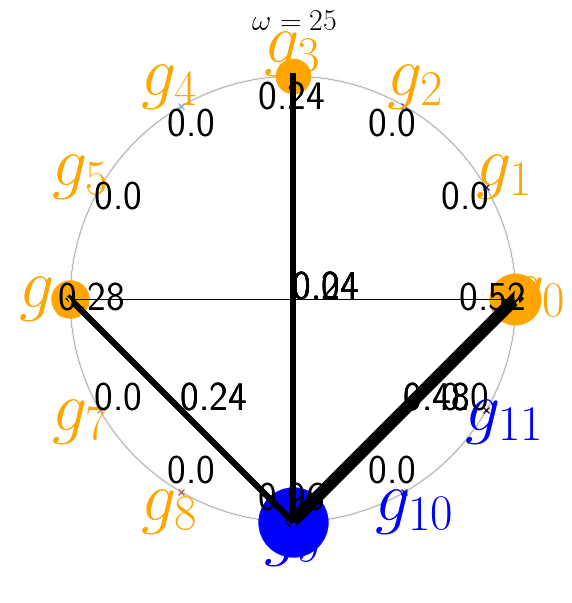

In [58]:

#%matplotlib inline
fig, axes_all = plt.subplots(figsize=(15, 10))

#[ax.set_axis_off() for ax in axarr.ravel()]
#colors = np.hstack([np.repeat('orange',9), np.repeat('blue',3)])
plot_watch_custom(toplot, 12, axes_all,colors)
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/re12_support_noise_p000001')

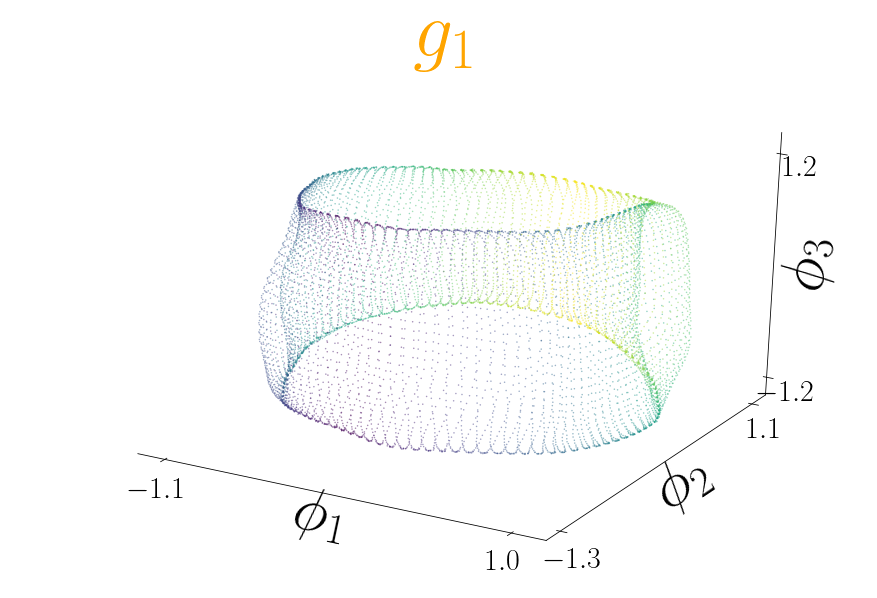

In [59]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(1,1, figsize = (15,10))

axs.set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(10000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(x, y, z, c = g1, s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 60)
ax.set_ylabel(r'$\phi_2$', fontsize = 60)
ax.set_zlabel(r'$\phi_3$', fontsize = 60)
ax.set_title(r'$g_{1}$', fontsize = 80, color = 'orange')

xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
ax.set_xticks([xmin, xmax])
ax.set_yticks([ymin, ymax])
ax.set_zticks([zmin, zmax])
ax.tick_params(labelsize=30)

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/re_groundtruth_g1_noise_p000001')

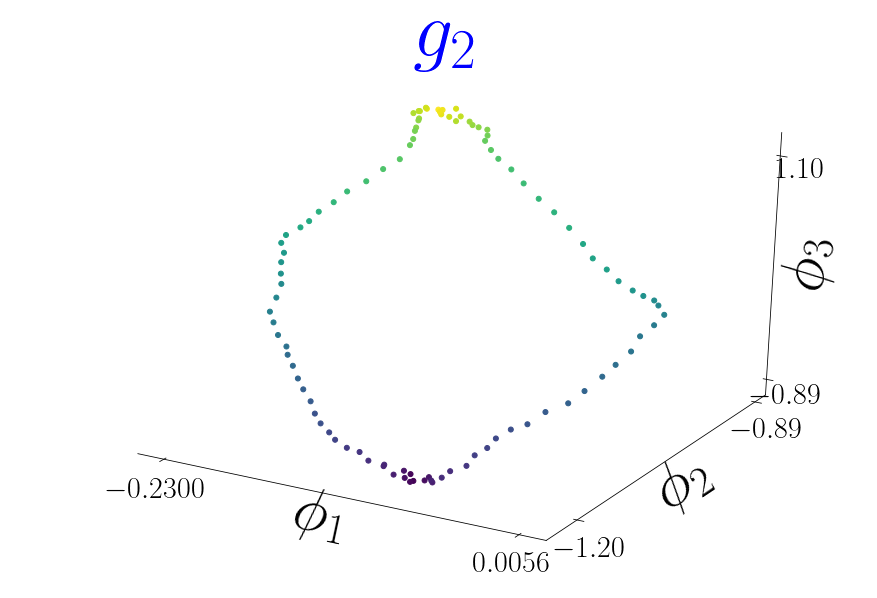

In [60]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
#s = 10000
alpha = 1

fig, axs = plt.subplots(1,1, figsize = (15,10))

axs.set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 100
#alpha = .5
selected_points = list(range(100))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(x, y, z, c = g2[selected_points], s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 60)
ax.set_ylabel(r'$\phi_2$', fontsize = 60)
ax.set_zlabel(r'$\phi_3$', fontsize = 60)
ax.set_title(r'$g_{2}$', fontsize = 80, color = 'blue')

xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
ax.set_xticks([xmin, xmax])
ax.set_yticks([ymin, ymax])
ax.set_zticks([zmin, zmax])
ax.tick_params(labelsize=30)

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/re_groundtruth_g2_noise_p000001')

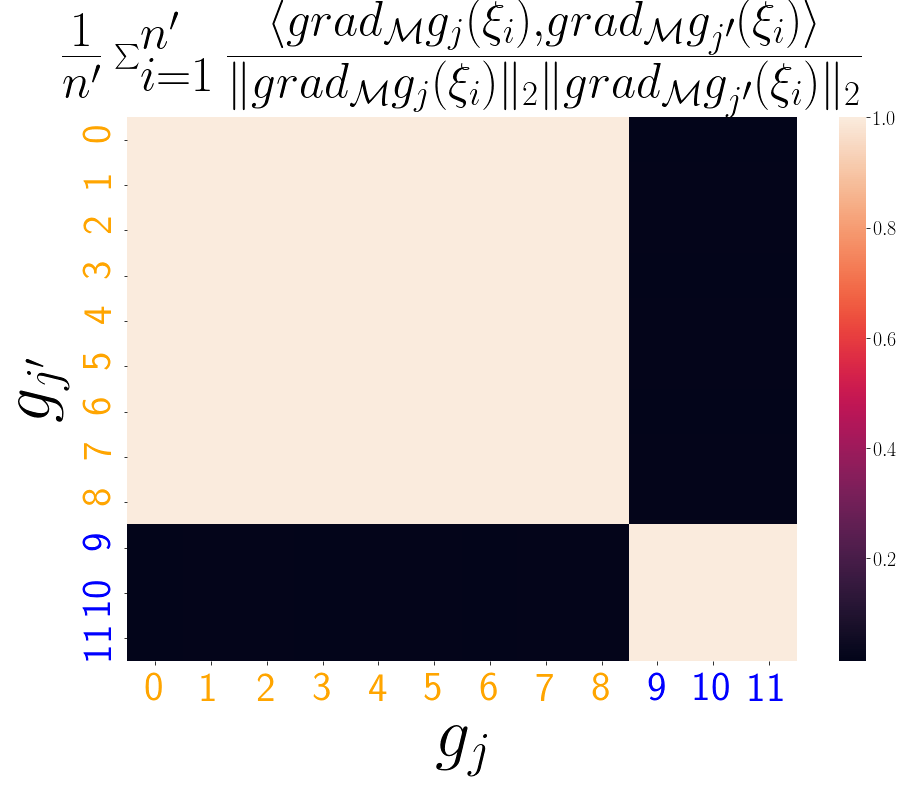

In [62]:
%matplotlib inline
fig, axes_all = plt.subplots(figsize=(15, 10))

cosine = get_cosines(np.swapaxes(replicates[0].dg_M,1,2))
#[ax.set_axis_off() for ax in axarr.ravel()]
colors = np.hstack([np.repeat('orange',9), np.repeat('blue',3)])
plot_cosines(cosine, axes_all, colors)
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/re12_cosines_noise')

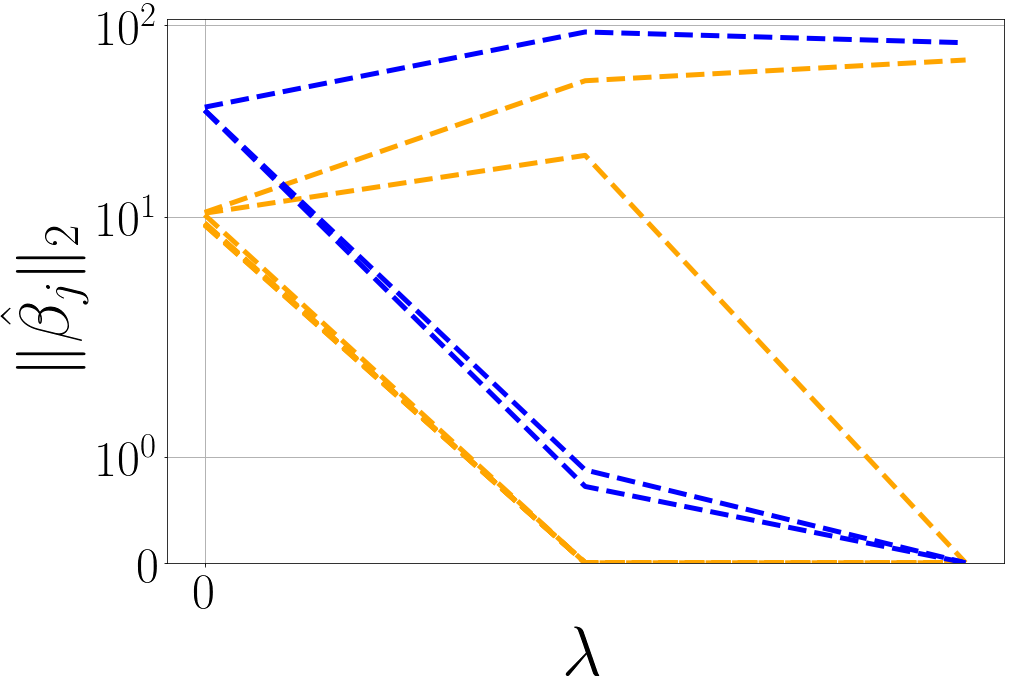

In [66]:

%matplotlib inline
fig, axes_all = plt.subplots(figsize=(15, 10))

#[ax.set_axis_off() for ax in axarr.ravel()]
colors = np.hstack([np.repeat('orange',9), np.repeat('blue',3)])
plot_reg_path_ax_lambdasearch_customcolors_norm(axes_all, replicates[0].cs_reorder, replicates[0].xaxis_reorder * np.sqrt(3 * 100), fig,colors)#axes_all[0].imshow(asdf)
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/re12_replicate_noise_p000001')

In [17]:
new_MN = True
new_grad = True
savename = 'rigidethanol_010521_p12rep5n500_papernorm'
savefolder = 'rigidethanol'
loadfolder = 'rigidethanol'
loadname = 'rigidethanol_010521_p12rep5n500_papernorm'
var = 0.0001#var = 0.01 breaks
if new_MN == True:
    experiment = RigidEthanolPCA2(dim, cor, var, ii, jj, cores, True, atoms4)
    experiment.M, experiment.Mpca, projector = experiment.generate_data(noise=True)
    experiment.q = m
    experiment.m = m
    experiment.dimnoise = dimnoise
    experiment.projector = projector
    experiment.Mpca.geom = experiment.Mpca.compute_geom(diffusion_time, n_neighbors)
    experiment.N = experiment.Mpca.get_embedding3(experiment.Mpca.geom, m, diffusion_time, dim)
    # with open(workingdirectory + '/untracked_data/embeddings/' + savefolder + '/' + savename + '.pkl' ,
    #          'wb') as output:
    #      pickle.dump(experiment, output, pickle.HIGHEST_PROTOCOL)

atoms4,p = get_atoms_4(natoms,ii,jj)
experiment.p = p
experiment.atoms4 = atoms4
#experiment.itermax = itermax
experiment.tol = tol
experiment.dnoise = dim
experiment.nreps = nreps
experiment.nsel = nsel
experiment.folder = folder

replicates = {}
selected_points_save = np.zeros((nreps,nsel))



[[0.0001 0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.0001 0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.0001 0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.0001 0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.0001 0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.0001 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.0001 0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.0001 0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.0001]]


In [18]:
ii_eth = np.asarray([0,0,0,0,1,1,1,2]) # atom adjacencies for dihedral angle computation
jj_eth = np.asarray([1,2,3,4,5,6,7,8])
atoms4_eth,p = get_atoms_4(9,ii_eth,jj_eth)
g1 = experiment.get_g_full_sub(experiment.M.data, atoms4_eth[0])
g2 = experiment.get_g_full_sub(experiment.M.data, atoms4_eth[9])

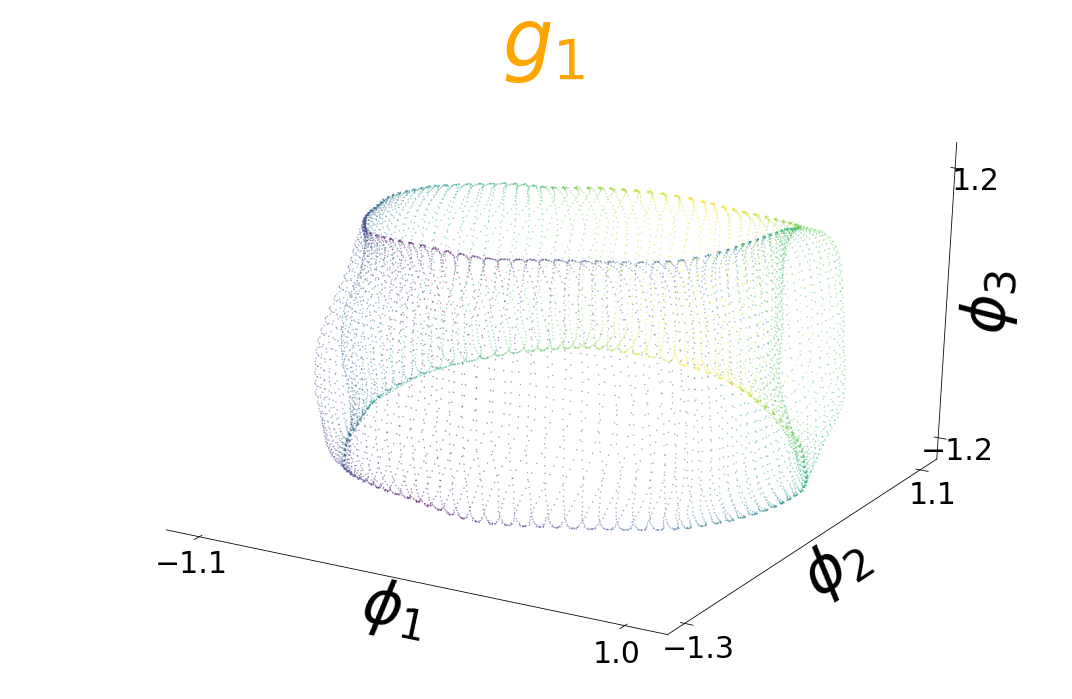

In [87]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(1,1, figsize = (15,10))

axs.set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(10000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(x, y, z, c = g1, s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 60)
ax.set_ylabel(r'$\phi_2$', fontsize = 60)
ax.set_zlabel(r'$\phi_3$', fontsize = 60)
ax.set_title(r'$g_{1}$', fontsize = 80, color = 'orange')

xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
ax.set_xticks([xmin, xmax])
ax.set_yticks([ymin, ymax])
ax.set_zticks([zmin, zmax])
ax.tick_params(labelsize=30)

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/re_groundtruth_g1_noise')

In [83]:
mpl.style.use('default')

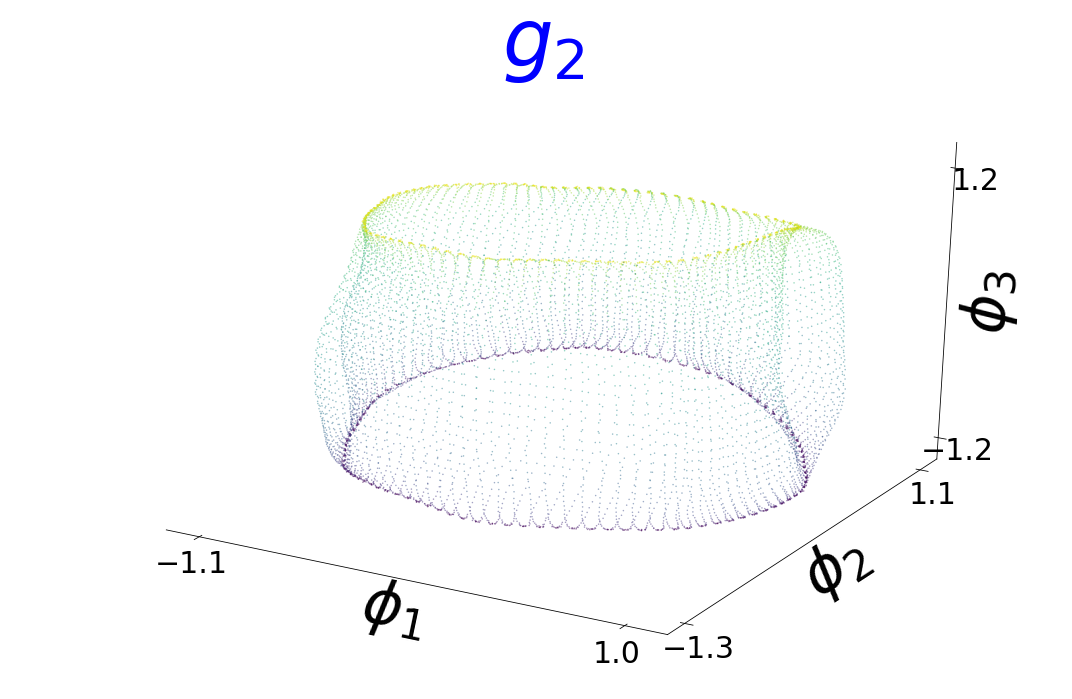

In [85]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
#s = 10000
alpha = 1

fig, axs = plt.subplots(1,1, figsize = (15,10))

axs.set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(10000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(x, y, z, c = g2[selected_points], s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 60)
ax.set_ylabel(r'$\phi_2$', fontsize = 60)
ax.set_zlabel(r'$\phi_3$', fontsize = 60)
ax.set_title(r'$g_{2}$', fontsize = 80, color = 'blue')

xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
ax.set_xticks([xmin, xmax])
ax.set_yticks([ymin, ymax])
ax.set_zticks([zmin, zmax])
ax.tick_params(labelsize=30)

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/re_groundtruth_g2_noise')

In [21]:

print('pre-gradient acquisition')
print(datetime.datetime.now())
for i in range(nreps):
    print(i)
    selected_points = np.random.choice(list(range(n)),nsel,replace = False)
    selected_points_save[i] = selected_points
    replicates[i] = Replicate()
    replicates[i].nsel = nsel
    replicates[i].selected_points = selected_points
    replicates[i].df_M,replicates[i].dg_M,replicates[i].dg_w ,replicates[i].dg_w_pca ,replicates[i].dgw_norm  = get_grads(experiment, experiment.Mpca, experiment.M, experiment.N, selected_points)
    replicates[i].dg_M = np.swapaxes(replicates[i].dg_M, 1,2)

pre-gradient acquisition
2021-01-11 12:47:48.399247
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [23]:

savename = 'rigidethanol_010521_p12rep5n500_papernorm_noise_p0001'
savefolder = 'rigidethanol'
loadfolder = 'rigidethanol'
loadname = 'rigidethanol_010521_p12rep5n500_papernorm_noise_p0001'

with open(workingdirectory + '/untracked_data/embeddings/' + savefolder + '/' + savename + 'replicates.pkl' ,
         'wb') as output:
     pickle.dump(replicates, output, pickle.HIGHEST_PROTOCOL)


selected_points_save = np.asarray(selected_points_save, dtype = int)
gl_itermax = 500
lambdas_start = [0.,.0005 * np.sqrt(nsel * p)]
max_search = 30
reg_l2 = 0.
card = dim
tol = 1e-14
learning_rate = 100

from pathos.multiprocessing import ProcessingPool as Pool
from codes.flasso.GradientGroupLasso import batch_stream, get_sr_lambda_sam_parallel

print('pre-gradient descent')
print(datetime.datetime.now())
cores = 16
# pcor = Pool(cores)
# results = pcor.map(lambda replicate: get_sr_lambda_sam_parallel(replicate, gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate), batch_stream(replicates))

results = {}
for r in range(nreps):
    print(r)
    results[r] = Replicate()
    results[r] = get_sr_lambda_sam_parallel(replicates[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)


with open(workingdirectory + '/untracked_data/embeddings/' + savefolder + '/' + savename + 'results.pkl' ,
         'wb') as output:
     pickle.dump(results, output, pickle.HIGHEST_PROTOCOL)

print('done')
print(datetime.datetime.now())

pre-gradient descent
2021-01-11 12:57:52.607962
0
initializing lambda search
0
lr 100
lr 50.0
1
lr 50.0
2
lr 50.0
3
lr 50.0
lr 25.0
4
lr 25.0
5
lr 25.0
6
lr 25.0
7
lr 25.0
8
lr 25.0
9
lr 25.0
10
lr 25.0
11
lr 25.0
12
lr 25.0
13
lr 25.0
14
lr 25.0
15
lr 25.0
16
lr 25.0
17
lr 25.0
18
lr 25.0
19
lr 25.0
20
lr 25.0
21
lr 25.0
22
lr 25.0
23
lr 25.0
24
lr 25.0
25
lr 25.0
26
lr 25.0
27
lr 25.0
28
lr 25.0
29
lr 25.0
30
lr 25.0
31
lr 25.0
32
lr 25.0
33
lr 25.0
34
lr 25.0
35
lr 25.0
36
lr 25.0
37
lr 25.0
38
lr 25.0
39
lr 25.0
40
lr 25.0
41
lr 25.0
42
lr 25.0
43
lr 25.0
44
lr 25.0
45
lr 25.0
46
lr 25.0
47
lr 25.0
48
lr 25.0
49
lr 25.0
50
lr 25.0
51
lr 25.0
52
lr 25.0
53
lr 25.0
54
lr 25.0
55
lr 25.0
56
lr 25.0
57
lr 25.0
58
lr 25.0
59
lr 25.0
60
lr 25.0
61
lr 25.0
62
lr 25.0
63
lr 25.0
64
lr 25.0
65
lr 25.0
66
lr 25.0
67
lr 25.0
68
lr 25.0
69
lr 25.0
70
lr 25.0
71
lr 25.0
72
lr 25.0
73
lr 25.0
74
lr 25.0
75
lr 25.0
76
lr 25.0
77
lr 25.0
78
lr 25.0
79
lr 25.0
80
lr 25.0
81
lr 25.0
82
lr 25.0
83
lr

lr 25.0
218
lr 25.0
219
lr 25.0
220
lr 25.0
221
lr 25.0
222
lr 25.0
223
lr 25.0
224
lr 25.0
225
lr 25.0
226
lr 25.0
227
lr 25.0
228
lr 25.0
229
lr 25.0
230
lr 25.0
231
lr 25.0
232
lr 25.0
233
lr 25.0
234
lr 25.0
235
lr 25.0
236
lr 25.0
237
lr 25.0
238
lr 25.0
239
lr 25.0
240
lr 25.0
241
lr 25.0
242
lr 25.0
243
lr 25.0
244
lr 25.0
245
lr 25.0
246
lr 25.0
247
lr 25.0
248
lr 25.0
249
lr 25.0
250
lr 25.0
251
lr 25.0
252
lr 25.0
253
lr 25.0
254
lr 25.0
255
lr 25.0
256
lr 25.0
257
lr 25.0
258
lr 25.0
259
lr 25.0
260
lr 25.0
261
lr 25.0
262
lr 25.0
263
lr 25.0
264
lr 25.0
265
lr 25.0
266
lr 25.0
267
lr 25.0
268
lr 25.0
269
lr 25.0
270
lr 25.0
271
lr 25.0
272
lr 25.0
273
lr 25.0
274
lr 25.0
275
lr 25.0
276
lr 25.0
277
lr 25.0
278
lr 25.0
279
lr 25.0
280
lr 25.0
281
lr 25.0
282
lr 25.0
283
lr 25.0
284
lr 25.0
285
lr 25.0
286
lr 25.0
287
lr 25.0
288
lr 25.0
289
lr 25.0
290
lr 25.0
291
lr 25.0
292
lr 25.0
293
lr 25.0
294
lr 25.0
295
lr 25.0
296
lr 25.0
297
lr 25.0
298
lr 25.0
299
lr 25.0
300
lr 2

440
lr 25.0
441
lr 25.0
442
lr 25.0
443
lr 25.0
444
lr 25.0
445
lr 25.0
446
lr 25.0
447
lr 25.0
448
lr 25.0
449
lr 25.0
450
lr 25.0
451
lr 25.0
452
lr 25.0
453
lr 25.0
454
lr 25.0
455
lr 25.0
456
lr 25.0
457
lr 25.0
458
lr 25.0
459
lr 25.0
460
lr 25.0
461
lr 25.0
462
lr 25.0
463
lr 25.0
464
lr 25.0
465
lr 25.0
466
lr 25.0
467
lr 25.0
468
lr 25.0
469
lr 25.0
470
lr 25.0
471
lr 25.0
472
lr 25.0
473
lr 25.0
474
lr 25.0
475
lr 25.0
476
lr 25.0
477
lr 25.0
478
lr 25.0
479
lr 25.0
480
lr 25.0
481
lr 25.0
482
lr 25.0
483
lr 25.0
484
lr 25.0
485
lr 25.0
486
lr 25.0
487
lr 25.0
488
lr 25.0
489
lr 25.0
490
lr 25.0
491
lr 25.0
492
lr 25.0
493
lr 25.0
494
lr 25.0
495
lr 25.0
496
lr 25.0
497
lr 25.0
498
lr 25.0
499
lr 25.0
1 0.0692820323027551 probe
0
lr 100
1
lr 100
2
lr 100
3
lr 100
4
lr 100
lr 50.0
5
lr 50.0
6
lr 50.0
7
lr 50.0
8
lr 50.0
9
lr 50.0
10
lr 50.0
11
lr 50.0
12
lr 50.0
13
lr 50.0
14
lr 50.0
15
lr 50.0
16
lr 50.0
17
lr 50.0
18
lr 50.0
19
lr 50.0
20
lr 50.0
21
lr 50.0
22
lr 50.0
23
lr 5

lr 100
185
lr 100
186
lr 100
187
lr 100
188
lr 100
189
lr 100
190
lr 100
191
lr 100
192
lr 100
193
lr 100
194
lr 100
195
lr 100
196
lr 100
197
lr 100
198
lr 100
199
lr 100
200
lr 100
201
lr 100
202
lr 100
203
lr 100
204
lr 100
205
lr 100
206
lr 100
207
lr 100
208
lr 100
209
lr 100
210
lr 100
211
lr 100
212
lr 100
213
lr 100
214
lr 100
215
lr 100
216
lr 100
217
lr 100
218
lr 100
219
lr 100
220
lr 100
221
lr 100
222
lr 100
223
lr 100
224
lr 100
225
lr 100
226
lr 100
227
lr 100
228
lr 100
229
lr 100
lr 50.0
230
lr 50.0
231
lr 50.0
converged 0.1385640646055102
3 0.2771281292110204 probe
0
lr 100
1
lr 100
2
lr 100
converged 0.2771281292110204
4 0.20784609690826533 probe
0
lr 100
1
lr 100
2
lr 100
3
lr 100
4
lr 100
converged 0.20784609690826533
5 0.17320508075688779 probe
0
lr 100
1
lr 100
2
lr 100
3
lr 100
4
lr 100
5
lr 100
6
lr 100
7
lr 100
8
lr 100
9
lr 100
10
lr 100
11
lr 100
12
lr 100
13
lr 100
14
lr 100
15
lr 100
16
lr 100
17
lr 100
18
lr 100
19
lr 100
20
lr 100
21
lr 100
22
lr 100
23


lr 12.5
471
lr 12.5
472
lr 12.5
473
lr 12.5
474
lr 12.5
475
lr 12.5
476
lr 12.5
477
lr 12.5
478
lr 12.5
479
lr 12.5
480
lr 12.5
481
lr 12.5
482
lr 12.5
483
lr 12.5
484
lr 12.5
485
lr 12.5
486
lr 12.5
487
lr 12.5
488
lr 12.5
489
lr 12.5
490
lr 12.5
491
lr 12.5
492
lr 12.5
493
lr 12.5
494
lr 12.5
495
lr 12.5
496
lr 12.5
497
lr 12.5
498
lr 12.5
499
lr 12.5
0
lr 100
1
lr 100
lr 50.0
2
lr 50.0
3
lr 50.0
lr 25.0
4
lr 25.0
lr 12.5
5
lr 12.5
6
lr 12.5
7
lr 12.5
8
lr 12.5
9
lr 12.5
10
lr 12.5
11
lr 12.5
12
lr 12.5
13
lr 12.5
14
lr 12.5
15
lr 12.5
16
lr 12.5
17
lr 12.5
18
lr 12.5
19
lr 12.5
20
lr 12.5
21
lr 12.5
22
lr 12.5
23
lr 12.5
24
lr 12.5
25
lr 12.5
26
lr 12.5
27
lr 12.5
28
lr 12.5
29
lr 12.5
30
lr 12.5
31
lr 12.5
32
lr 12.5
33
lr 12.5
34
lr 12.5
35
lr 12.5
36
lr 12.5
37
lr 12.5
38
lr 12.5
39
lr 12.5
40
lr 12.5
41
lr 12.5
42
lr 12.5
43
lr 12.5
44
lr 12.5
45
lr 12.5
46
lr 12.5
47
lr 12.5
48
lr 12.5
49
lr 12.5
50
lr 12.5
51
lr 12.5
52
lr 12.5
53
lr 12.5
54
lr 12.5
55
lr 12.5
56
lr 12.5
57
lr

lr 50.0
212
lr 50.0
213
lr 50.0
214
lr 50.0
215
lr 50.0
216
lr 50.0
217
lr 50.0
218
lr 50.0
219
lr 50.0
220
lr 50.0
221
lr 50.0
222
lr 50.0
223
lr 50.0
224
lr 50.0
225
lr 50.0
226
lr 50.0
227
lr 50.0
228
lr 50.0
229
lr 50.0
230
lr 50.0
231
lr 50.0
232
lr 50.0
233
lr 50.0
234
lr 50.0
235
lr 50.0
236
lr 50.0
237
lr 50.0
238
lr 50.0
239
lr 50.0
240
lr 50.0
241
lr 50.0
242
lr 50.0
243
lr 50.0
244
lr 50.0
245
lr 50.0
246
lr 50.0
247
lr 50.0
248
lr 50.0
249
lr 50.0
250
lr 50.0
251
lr 50.0
252
lr 50.0
253
lr 50.0
254
lr 50.0
255
lr 50.0
256
lr 50.0
257
lr 50.0
258
lr 50.0
259
lr 50.0
260
lr 50.0
261
lr 50.0
262
lr 50.0
263
lr 50.0
264
lr 50.0
265
lr 50.0
266
lr 50.0
267
lr 50.0
268
lr 50.0
269
lr 50.0
270
lr 50.0
271
lr 50.0
272
lr 50.0
273
lr 50.0
274
lr 50.0
275
lr 50.0
276
lr 50.0
277
lr 50.0
278
lr 50.0
279
lr 50.0
280
lr 50.0
281
lr 50.0
282
lr 50.0
283
lr 50.0
284
lr 50.0
285
lr 50.0
286
lr 50.0
287
lr 50.0
288
lr 50.0
289
lr 50.0
290
lr 50.0
291
lr 50.0
292
lr 50.0
293
lr 50.0
294
lr 5

452
lr 50.0
453
lr 50.0
454
lr 50.0
455
lr 50.0
456
lr 50.0
457
lr 50.0
458
lr 50.0
459
lr 50.0
460
lr 50.0
461
lr 50.0
462
lr 50.0
463
lr 50.0
464
lr 50.0
465
lr 50.0
466
lr 50.0
467
lr 50.0
468
lr 50.0
lr 25.0
469
lr 25.0
470
lr 25.0
converged 0.0692820323027551
2 0.1385640646055102 probe
0
lr 100
1
lr 100
2
lr 100
3
lr 100
4
lr 100
5
lr 100
6
lr 100
7
lr 100
8
lr 100
9
lr 100
10
lr 100
11
lr 100
12
lr 100
13
lr 100
14
lr 100
15
lr 100
16
lr 100
17
lr 100
18
lr 100
19
lr 100
20
lr 100
21
lr 100
22
lr 100
23
lr 100
24
lr 100
25
lr 100
26
lr 100
27
lr 100
28
lr 100
29
lr 100
30
lr 100
31
lr 100
32
lr 100
33
lr 100
34
lr 100
35
lr 100
36
lr 100
37
lr 100
38
lr 100
39
lr 100
40
lr 100
41
lr 100
42
lr 100
43
lr 100
44
lr 100
45
lr 100
46
lr 100
47
lr 100
48
lr 100
49
lr 100
50
lr 100
51
lr 100
52
lr 100
53
lr 100
54
lr 100
55
lr 100
56
lr 100
57
lr 100
58
lr 100
59
lr 100
60
lr 100
61
lr 100
62
lr 100
63
lr 100
64
lr 100
65
lr 100
66
lr 100
67
lr 100
68
lr 100
69
lr 100
70
lr 100
71
lr 10

lr 25.0
353
lr 25.0
354
lr 25.0
355
lr 25.0
356
lr 25.0
357
lr 25.0
358
lr 25.0
359
lr 25.0
360
lr 25.0
361
lr 25.0
362
lr 25.0
363
lr 25.0
364
lr 25.0
365
lr 25.0
366
lr 25.0
367
lr 25.0
368
lr 25.0
369
lr 25.0
370
lr 25.0
371
lr 25.0
372
lr 25.0
373
lr 25.0
374
lr 25.0
375
lr 25.0
376
lr 25.0
377
lr 25.0
378
lr 25.0
379
lr 25.0
380
lr 25.0
381
lr 25.0
382
lr 25.0
383
lr 25.0
384
lr 25.0
385
lr 25.0
386
lr 25.0
387
lr 25.0
388
lr 25.0
389
lr 25.0
390
lr 25.0
391
lr 25.0
392
lr 25.0
393
lr 25.0
394
lr 25.0
395
lr 25.0
396
lr 25.0
397
lr 25.0
398
lr 25.0
399
lr 25.0
400
lr 25.0
401
lr 25.0
402
lr 25.0
403
lr 25.0
404
lr 25.0
405
lr 25.0
406
lr 25.0
407
lr 25.0
408
lr 25.0
409
lr 25.0
410
lr 25.0
411
lr 25.0
412
lr 25.0
413
lr 25.0
414
lr 25.0
415
lr 25.0
416
lr 25.0
417
lr 25.0
418
lr 25.0
419
lr 25.0
420
lr 25.0
421
lr 25.0
422
lr 25.0
423
lr 25.0
424
lr 25.0
425
lr 25.0
426
lr 25.0
427
lr 25.0
428
lr 25.0
429
lr 25.0
430
lr 25.0
431
lr 25.0
432
lr 25.0
433
lr 25.0
434
lr 25.0
435
lr 2

95
lr 25.0
96
lr 25.0
97
lr 25.0
98
lr 25.0
99
lr 25.0
100
lr 25.0
101
lr 25.0
102
lr 25.0
103
lr 25.0
104
lr 25.0
105
lr 25.0
106
lr 25.0
107
lr 25.0
108
lr 25.0
109
lr 25.0
110
lr 25.0
111
lr 25.0
112
lr 25.0
113
lr 25.0
114
lr 25.0
115
lr 25.0
116
lr 25.0
117
lr 25.0
118
lr 25.0
119
lr 25.0
120
lr 25.0
121
lr 25.0
122
lr 25.0
123
lr 25.0
124
lr 25.0
125
lr 25.0
126
lr 25.0
127
lr 25.0
128
lr 25.0
129
lr 25.0
130
lr 25.0
131
lr 25.0
132
lr 25.0
133
lr 25.0
134
lr 25.0
135
lr 25.0
136
lr 25.0
137
lr 25.0
138
lr 25.0
139
lr 25.0
140
lr 25.0
141
lr 25.0
142
lr 25.0
143
lr 25.0
144
lr 25.0
145
lr 25.0
146
lr 25.0
147
lr 25.0
148
lr 25.0
149
lr 25.0
150
lr 25.0
151
lr 25.0
152
lr 25.0
153
lr 25.0
154
lr 25.0
155
lr 25.0
156
lr 25.0
157
lr 25.0
158
lr 25.0
159
lr 25.0
160
lr 25.0
161
lr 25.0
162
lr 25.0
163
lr 25.0
164
lr 25.0
165
lr 25.0
166
lr 25.0
167
lr 25.0
168
lr 25.0
169
lr 25.0
170
lr 25.0
171
lr 25.0
172
lr 25.0
173
lr 25.0
174
lr 25.0
175
lr 25.0
176
lr 25.0
177
lr 25.0
178
lr 25

lr 50.0
338
lr 50.0
339
lr 50.0
340
lr 50.0
341
lr 50.0
342
lr 50.0
343
lr 50.0
344
lr 50.0
345
lr 50.0
346
lr 50.0
347
lr 50.0
348
lr 50.0
349
lr 50.0
350
lr 50.0
351
lr 50.0
converged 0.0692820323027551
2 0.1385640646055102 probe
0
lr 100
1
lr 100
2
lr 100
3
lr 100
4
lr 100
5
lr 100
6
lr 100
7
lr 100
8
lr 100
9
lr 100
10
lr 100
11
lr 100
12
lr 100
13
lr 100
14
lr 100
15
lr 100
16
lr 100
17
lr 100
18
lr 100
19
lr 100
20
lr 100
21
lr 100
22
lr 100
23
lr 100
24
lr 100
25
lr 100
26
lr 100
27
lr 100
28
lr 100
29
lr 100
30
lr 100
31
lr 100
32
lr 100
33
lr 100
34
lr 100
35
lr 100
36
lr 100
37
lr 100
38
lr 100
39
lr 100
40
lr 100
41
lr 100
42
lr 100
43
lr 100
44
lr 100
45
lr 100
46
lr 100
47
lr 100
48
lr 100
49
lr 100
50
lr 100
51
lr 100
52
lr 100
53
lr 100
54
lr 100
55
lr 100
56
lr 100
57
lr 100
58
lr 100
59
lr 100
60
lr 100
61
lr 100
62
lr 100
63
lr 100
64
lr 100
65
lr 100
66
lr 100
67
lr 100
68
lr 100
69
lr 100
70
lr 100
71
lr 100
72
lr 100
73
lr 100
74
lr 100
75
lr 100
76
lr 100
77
lr 10

lr 25.0
264
lr 25.0
265
lr 25.0
266
lr 25.0
267
lr 25.0
268
lr 25.0
269
lr 25.0
270
lr 25.0
271
lr 25.0
272
lr 25.0
273
lr 25.0
274
lr 25.0
275
lr 25.0
276
lr 25.0
277
lr 25.0
278
lr 25.0
279
lr 25.0
280
lr 25.0
281
lr 25.0
282
lr 25.0
283
lr 25.0
284
lr 25.0
285
lr 25.0
286
lr 25.0
287
lr 25.0
288
lr 25.0
289
lr 25.0
290
lr 25.0
291
lr 25.0
292
lr 25.0
293
lr 25.0
294
lr 25.0
295
lr 25.0
296
lr 25.0
297
lr 25.0
298
lr 25.0
299
lr 25.0
300
lr 25.0
301
lr 25.0
302
lr 25.0
303
lr 25.0
304
lr 25.0
305
lr 25.0
306
lr 25.0
307
lr 25.0
308
lr 25.0
309
lr 25.0
310
lr 25.0
311
lr 25.0
312
lr 25.0
313
lr 25.0
314
lr 25.0
315
lr 25.0
316
lr 25.0
317
lr 25.0
318
lr 25.0
319
lr 25.0
320
lr 25.0
321
lr 25.0
322
lr 25.0
323
lr 25.0
324
lr 25.0
325
lr 25.0
326
lr 25.0
327
lr 25.0
328
lr 25.0
329
lr 25.0
330
lr 25.0
331
lr 25.0
332
lr 25.0
333
lr 25.0
334
lr 25.0
335
lr 25.0
336
lr 25.0
337
lr 25.0
338
lr 25.0
339
lr 25.0
340
lr 25.0
341
lr 25.0
342
lr 25.0
343
lr 25.0
344
lr 25.0
345
lr 25.0
346
lr 2

6
lr 25.0
7
lr 25.0
8
lr 25.0
9
lr 25.0
10
lr 25.0
11
lr 25.0
12
lr 25.0
13
lr 25.0
14
lr 25.0
15
lr 25.0
16
lr 25.0
17
lr 25.0
18
lr 25.0
19
lr 25.0
20
lr 25.0
21
lr 25.0
22
lr 25.0
23
lr 25.0
24
lr 25.0
25
lr 25.0
26
lr 25.0
27
lr 25.0
28
lr 25.0
29
lr 25.0
30
lr 25.0
31
lr 25.0
32
lr 25.0
33
lr 25.0
34
lr 25.0
35
lr 25.0
36
lr 25.0
37
lr 25.0
38
lr 25.0
39
lr 25.0
40
lr 25.0
41
lr 25.0
42
lr 25.0
43
lr 25.0
44
lr 25.0
45
lr 25.0
46
lr 25.0
47
lr 25.0
48
lr 25.0
49
lr 25.0
50
lr 25.0
51
lr 25.0
52
lr 25.0
53
lr 25.0
54
lr 25.0
55
lr 25.0
56
lr 25.0
57
lr 25.0
58
lr 25.0
59
lr 25.0
60
lr 25.0
61
lr 25.0
62
lr 25.0
63
lr 25.0
64
lr 25.0
65
lr 25.0
66
lr 25.0
67
lr 25.0
68
lr 25.0
69
lr 25.0
70
lr 25.0
71
lr 25.0
72
lr 25.0
73
lr 25.0
74
lr 25.0
75
lr 25.0
76
lr 25.0
77
lr 25.0
78
lr 25.0
79
lr 25.0
80
lr 25.0
81
lr 25.0
82
lr 25.0
83
lr 25.0
84
lr 25.0
85
lr 25.0
86
lr 25.0
87
lr 25.0
88
lr 25.0
89
lr 25.0
90
lr 25.0
91
lr 25.0
92
lr 25.0
93
lr 25.0
94
lr 25.0
95
lr 25.0
96
lr 25.0
97


lr 25.0
251
lr 25.0
252
lr 25.0
253
lr 25.0
254
lr 25.0
255
lr 25.0
256
lr 25.0
257
lr 25.0
258
lr 25.0
259
lr 25.0
260
lr 25.0
261
lr 25.0
262
lr 25.0
263
lr 25.0
264
lr 25.0
265
lr 25.0
266
lr 25.0
267
lr 25.0
268
lr 25.0
269
lr 25.0
270
lr 25.0
271
lr 25.0
272
lr 25.0
273
lr 25.0
274
lr 25.0
275
lr 25.0
276
lr 25.0
277
lr 25.0
278
lr 25.0
279
lr 25.0
280
lr 25.0
281
lr 25.0
282
lr 25.0
283
lr 25.0
284
lr 25.0
285
lr 25.0
286
lr 25.0
287
lr 25.0
288
lr 25.0
289
lr 25.0
290
lr 25.0
291
lr 25.0
292
lr 25.0
293
lr 25.0
294
lr 25.0
295
lr 25.0
296
lr 25.0
297
lr 25.0
298
lr 25.0
299
lr 25.0
300
lr 25.0
301
lr 25.0
302
lr 25.0
303
lr 25.0
304
lr 25.0
305
lr 25.0
306
lr 25.0
307
lr 25.0
308
lr 25.0
309
lr 25.0
310
lr 25.0
311
lr 25.0
312
lr 25.0
313
lr 25.0
314
lr 25.0
315
lr 25.0
316
lr 25.0
317
lr 25.0
318
lr 25.0
319
lr 25.0
320
lr 25.0
321
lr 25.0
322
lr 25.0
323
lr 25.0
324
lr 25.0
325
lr 25.0
326
lr 25.0
327
lr 25.0
328
lr 25.0
329
lr 25.0
330
lr 25.0
331
lr 25.0
332
lr 25.0
333
lr 2

lr 100
101
lr 100
102
lr 100
103
lr 100
104
lr 100
105
lr 100
106
lr 100
107
lr 100
108
lr 100
109
lr 100
110
lr 100
111
lr 100
112
lr 100
113
lr 100
114
lr 100
115
lr 100
116
lr 100
117
lr 100
118
lr 100
119
lr 100
120
lr 100
121
lr 100
122
lr 100
123
lr 100
124
lr 100
converged 0.16454482671904339
8 0.16887495373796557 probe
0
lr 100
1
lr 100
2
lr 100
3
lr 100
4
lr 100
5
lr 100
6
lr 100
7
lr 100
8
lr 100
9
lr 100
10
lr 100
11
lr 100
12
lr 100
13
lr 100
14
lr 100
15
lr 100
16
lr 100
17
lr 100
18
lr 100
19
lr 100
20
lr 100
21
lr 100
22
lr 100
23
lr 100
converged 0.16887495373796557
we did it
4
initializing lambda search
0
lr 100
lr 50.0
1
lr 50.0
2
lr 50.0
3
lr 50.0
lr 25.0
4
lr 25.0
5
lr 25.0
6
lr 25.0
7
lr 25.0
8
lr 25.0
9
lr 25.0
10
lr 25.0
11
lr 25.0
12
lr 25.0
13
lr 25.0
14
lr 25.0
15
lr 25.0
16
lr 25.0
17
lr 25.0
18
lr 25.0
19
lr 25.0
20
lr 25.0
21
lr 25.0
22
lr 25.0
23
lr 25.0
24
lr 25.0
25
lr 25.0
26
lr 25.0
27
lr 25.0
28
lr 25.0
29
lr 25.0
30
lr 25.0
31
lr 25.0
32
lr 25.0
33
l

lr 25.0
187
lr 25.0
188
lr 25.0
189
lr 25.0
190
lr 25.0
191
lr 25.0
192
lr 25.0
193
lr 25.0
194
lr 25.0
195
lr 25.0
196
lr 25.0
197
lr 25.0
198
lr 25.0
199
lr 25.0
200
lr 25.0
201
lr 25.0
202
lr 25.0
203
lr 25.0
204
lr 25.0
205
lr 25.0
206
lr 25.0
207
lr 25.0
208
lr 25.0
209
lr 25.0
210
lr 25.0
211
lr 25.0
212
lr 25.0
213
lr 25.0
214
lr 25.0
215
lr 25.0
216
lr 25.0
217
lr 25.0
218
lr 25.0
219
lr 25.0
220
lr 25.0
221
lr 25.0
222
lr 25.0
223
lr 25.0
224
lr 25.0
225
lr 25.0
226
lr 25.0
227
lr 25.0
228
lr 25.0
229
lr 25.0
230
lr 25.0
231
lr 25.0
232
lr 25.0
233
lr 25.0
234
lr 25.0
235
lr 25.0
236
lr 25.0
237
lr 25.0
238
lr 25.0
239
lr 25.0
240
lr 25.0
241
lr 25.0
242
lr 25.0
243
lr 25.0
244
lr 25.0
245
lr 25.0
246
lr 25.0
247
lr 25.0
248
lr 25.0
249
lr 25.0
250
lr 25.0
251
lr 25.0
252
lr 25.0
253
lr 25.0
254
lr 25.0
255
lr 25.0
256
lr 25.0
257
lr 25.0
258
lr 25.0
259
lr 25.0
260
lr 25.0
261
lr 25.0
262
lr 25.0
263
lr 25.0
264
lr 25.0
265
lr 25.0
266
lr 25.0
267
lr 25.0
268
lr 25.0
269
lr 2

378
lr 25.0
379
lr 25.0
380
lr 25.0
381
lr 25.0
382
lr 25.0
383
lr 25.0
384
lr 25.0
385
lr 25.0
386
lr 25.0
387
lr 25.0
388
lr 25.0
389
lr 25.0
390
lr 25.0
391
lr 25.0
392
lr 25.0
393
lr 25.0
394
lr 25.0
395
lr 25.0
396
lr 25.0
397
lr 25.0
398
lr 25.0
399
lr 25.0
400
lr 25.0
401
lr 25.0
402
lr 25.0
403
lr 25.0
404
lr 25.0
405
lr 25.0
406
lr 25.0
407
lr 25.0
408
lr 25.0
409
lr 25.0
410
lr 25.0
411
lr 25.0
412
lr 25.0
413
lr 25.0
414
lr 25.0
415
lr 25.0
416
lr 25.0
417
lr 25.0
418
lr 25.0
419
lr 25.0
420
lr 25.0
421
lr 25.0
422
lr 25.0
423
lr 25.0
424
lr 25.0
425
lr 25.0
426
lr 25.0
427
lr 25.0
428
lr 25.0
429
lr 25.0
430
lr 25.0
431
lr 25.0
432
lr 25.0
433
lr 25.0
434
lr 25.0
435
lr 25.0
436
lr 25.0
437
lr 25.0
438
lr 25.0
439
lr 25.0
440
lr 25.0
441
lr 25.0
442
lr 25.0
443
lr 25.0
444
lr 25.0
445
lr 25.0
446
lr 25.0
447
lr 25.0
448
lr 25.0
449
lr 25.0
450
lr 25.0
451
lr 25.0
452
lr 25.0
453
lr 25.0
454
lr 25.0
455
lr 25.0
456
lr 25.0
457
lr 25.0
458
lr 25.0
459
lr 25.0
460
lr 25.0
461


lr 100
124
lr 100
125
lr 100
126
lr 100
127
lr 100
128
lr 100
129
lr 100
130
lr 100
131
lr 100
132
lr 100
133
lr 100
134
lr 100
135
lr 100
136
lr 100
137
lr 100
138
lr 100
139
lr 100
converged 0.1385640646055102
we did it
5
initializing lambda search
0
lr 100
lr 50.0
1
lr 50.0
lr 25.0
lr 12.5
2
lr 12.5
3
lr 12.5
4
lr 12.5
5
lr 12.5
6
lr 12.5
7
lr 12.5
8
lr 12.5
9
lr 12.5
10
lr 12.5
11
lr 12.5
12
lr 12.5
13
lr 12.5
14
lr 12.5
15
lr 12.5
16
lr 12.5
17
lr 12.5
18
lr 12.5
19
lr 12.5
20
lr 12.5
21
lr 12.5
22
lr 12.5
23
lr 12.5
24
lr 12.5
25
lr 12.5
26
lr 12.5
27
lr 12.5
28
lr 12.5
29
lr 12.5
30
lr 12.5
31
lr 12.5
32
lr 12.5
33
lr 12.5
34
lr 12.5
35
lr 12.5
36
lr 12.5
37
lr 12.5
38
lr 12.5
39
lr 12.5
40
lr 12.5
41
lr 12.5
42
lr 12.5
43
lr 12.5
44
lr 12.5
45
lr 12.5
46
lr 12.5
47
lr 12.5
48
lr 12.5
49
lr 12.5
50
lr 12.5
51
lr 12.5
52
lr 12.5
53
lr 12.5
54
lr 12.5
55
lr 12.5
56
lr 12.5
57
lr 12.5
58
lr 12.5
59
lr 12.5
60
lr 12.5
61
lr 12.5
62
lr 12.5
63
lr 12.5
64
lr 12.5
65
lr 12.5
66
lr 12.5

lr 12.5
228
lr 12.5
229
lr 12.5
230
lr 12.5
231
lr 12.5
232
lr 12.5
233
lr 12.5
234
lr 12.5
235
lr 12.5
236
lr 12.5
237
lr 12.5
238
lr 12.5
239
lr 12.5
240
lr 12.5
241
lr 12.5
242
lr 12.5
243
lr 12.5
244
lr 12.5
245
lr 12.5
246
lr 12.5
247
lr 12.5
248
lr 12.5
249
lr 12.5
250
lr 12.5
251
lr 12.5
252
lr 12.5
253
lr 12.5
254
lr 12.5
255
lr 12.5
256
lr 12.5
257
lr 12.5
258
lr 12.5
259
lr 12.5
260
lr 12.5
261
lr 12.5
262
lr 12.5
263
lr 12.5
264
lr 12.5
265
lr 12.5
266
lr 12.5
267
lr 12.5
268
lr 12.5
269
lr 12.5
270
lr 12.5
271
lr 12.5
272
lr 12.5
273
lr 12.5
274
lr 12.5
275
lr 12.5
276
lr 12.5
277
lr 12.5
278
lr 12.5
279
lr 12.5
280
lr 12.5
281
lr 12.5
282
lr 12.5
283
lr 12.5
284
lr 12.5
285
lr 12.5
286
lr 12.5
287
lr 12.5
288
lr 12.5
289
lr 12.5
290
lr 12.5
291
lr 12.5
292
lr 12.5
293
lr 12.5
294
lr 12.5
295
lr 12.5
296
lr 12.5
297
lr 12.5
298
lr 12.5
299
lr 12.5
300
lr 12.5
301
lr 12.5
302
lr 12.5
303
lr 12.5
304
lr 12.5
305
lr 12.5
306
lr 12.5
307
lr 12.5
308
lr 12.5
309
lr 12.5
310
lr 1

lr 12.5
419
lr 12.5
420
lr 12.5
421
lr 12.5
422
lr 12.5
423
lr 12.5
424
lr 12.5
425
lr 12.5
426
lr 12.5
427
lr 12.5
428
lr 12.5
429
lr 12.5
430
lr 12.5
431
lr 12.5
432
lr 12.5
433
lr 12.5
434
lr 12.5
435
lr 12.5
436
lr 12.5
437
lr 12.5
438
lr 12.5
439
lr 12.5
440
lr 12.5
441
lr 12.5
442
lr 12.5
443
lr 12.5
444
lr 12.5
445
lr 12.5
446
lr 12.5
447
lr 12.5
448
lr 12.5
449
lr 12.5
450
lr 12.5
451
lr 12.5
452
lr 12.5
453
lr 12.5
454
lr 12.5
455
lr 12.5
456
lr 12.5
457
lr 12.5
458
lr 12.5
459
lr 12.5
460
lr 12.5
461
lr 12.5
462
lr 12.5
463
lr 12.5
464
lr 12.5
465
lr 12.5
466
lr 12.5
467
lr 12.5
468
lr 12.5
469
lr 12.5
470
lr 12.5
471
lr 12.5
472
lr 12.5
473
lr 12.5
474
lr 12.5
475
lr 12.5
476
lr 12.5
477
lr 12.5
478
lr 12.5
479
lr 12.5
480
lr 12.5
481
lr 12.5
482
lr 12.5
483
lr 12.5
484
lr 12.5
485
lr 12.5
486
lr 12.5
487
lr 12.5
488
lr 12.5
489
lr 12.5
490
lr 12.5
491
lr 12.5
492
lr 12.5
493
lr 12.5
494
lr 12.5
495
lr 12.5
496
lr 12.5
497
lr 12.5
498
lr 12.5
499
lr 12.5
1 0.0692820323027551

lr 25.0
169
lr 25.0
170
lr 25.0
171
lr 25.0
172
lr 25.0
173
lr 25.0
174
lr 25.0
175
lr 25.0
176
lr 25.0
177
lr 25.0
178
lr 25.0
179
lr 25.0
180
lr 25.0
181
lr 25.0
182
lr 25.0
183
lr 25.0
184
lr 25.0
185
lr 25.0
186
lr 25.0
187
lr 25.0
188
lr 25.0
189
lr 25.0
190
lr 25.0
191
lr 25.0
192
lr 25.0
193
lr 25.0
194
lr 25.0
195
lr 25.0
196
lr 25.0
197
lr 25.0
198
lr 25.0
199
lr 25.0
200
lr 25.0
201
lr 25.0
202
lr 25.0
203
lr 25.0
204
lr 25.0
205
lr 25.0
206
lr 25.0
207
lr 25.0
208
lr 25.0
209
lr 25.0
210
lr 25.0
211
lr 25.0
212
lr 25.0
213
lr 25.0
214
lr 25.0
215
lr 25.0
216
lr 25.0
217
lr 25.0
218
lr 25.0
219
lr 25.0
220
lr 25.0
221
lr 25.0
222
lr 25.0
223
lr 25.0
224
lr 25.0
225
lr 25.0
226
lr 25.0
227
lr 25.0
228
lr 25.0
229
lr 25.0
230
lr 25.0
231
lr 25.0
232
lr 25.0
233
lr 25.0
234
lr 25.0
235
lr 25.0
236
lr 25.0
237
lr 25.0
238
lr 25.0
239
lr 25.0
240
lr 25.0
241
lr 25.0
242
lr 25.0
243
lr 25.0
244
lr 25.0
245
lr 25.0
246
lr 25.0
247
lr 25.0
248
lr 25.0
249
lr 25.0
250
lr 25.0
251
lr 2

lr 12.5
268
lr 12.5
269
lr 12.5
270
lr 12.5
271
lr 12.5
272
lr 12.5
273
lr 12.5
274
lr 12.5
275
lr 12.5
276
lr 12.5
277
lr 12.5
278
lr 12.5
279
lr 12.5
280
lr 12.5
281
lr 12.5
282
lr 12.5
283
lr 12.5
284
lr 12.5
285
lr 12.5
286
lr 12.5
287
lr 12.5
288
lr 12.5
289
lr 12.5
290
lr 12.5
291
lr 12.5
292
lr 12.5
293
lr 12.5
294
lr 12.5
295
lr 12.5
296
lr 12.5
297
lr 12.5
298
lr 12.5
299
lr 12.5
300
lr 12.5
301
lr 12.5
302
lr 12.5
303
lr 12.5
304
lr 12.5
305
lr 12.5
306
lr 12.5
307
lr 12.5
308
lr 12.5
309
lr 12.5
310
lr 12.5
311
lr 12.5
312
lr 12.5
313
lr 12.5
314
lr 12.5
315
lr 12.5
316
lr 12.5
317
lr 12.5
318
lr 12.5
319
lr 12.5
320
lr 12.5
321
lr 12.5
322
lr 12.5
323
lr 12.5
324
lr 12.5
325
lr 12.5
326
lr 12.5
327
lr 12.5
328
lr 12.5
329
lr 12.5
330
lr 12.5
331
lr 12.5
332
lr 12.5
333
lr 12.5
334
lr 12.5
335
lr 12.5
336
lr 12.5
337
lr 12.5
338
lr 12.5
339
lr 12.5
340
lr 12.5
341
lr 12.5
342
lr 12.5
343
lr 12.5
344
lr 12.5
345
lr 12.5
346
lr 12.5
347
lr 12.5
348
lr 12.5
349
lr 12.5
350
lr 1

lr 12.5
462
lr 12.5
463
lr 12.5
464
lr 12.5
465
lr 12.5
466
lr 12.5
467
lr 12.5
468
lr 12.5
469
lr 12.5
470
lr 12.5
471
lr 12.5
472
lr 12.5
473
lr 12.5
474
lr 12.5
475
lr 12.5
476
lr 12.5
477
lr 12.5
478
lr 12.5
479
lr 12.5
480
lr 12.5
481
lr 12.5
482
lr 12.5
483
lr 12.5
484
lr 12.5
485
lr 12.5
486
lr 12.5
487
lr 12.5
488
lr 12.5
489
lr 12.5
490
lr 12.5
491
lr 12.5
492
lr 12.5
493
lr 12.5
494
lr 12.5
495
lr 12.5
496
lr 12.5
497
lr 12.5
498
lr 12.5
499
lr 12.5
0 0.03464101615137755 probe
0
lr 100
1
lr 100
lr 50.0
2
lr 50.0
lr 25.0
3
lr 25.0
4
lr 25.0
5
lr 25.0
6
lr 25.0
7
lr 25.0
8
lr 25.0
9
lr 25.0
10
lr 25.0
11
lr 25.0
12
lr 25.0
13
lr 25.0
14
lr 25.0
15
lr 25.0
16
lr 25.0
17
lr 25.0
18
lr 25.0
19
lr 25.0
20
lr 25.0
21
lr 25.0
22
lr 25.0
23
lr 25.0
24
lr 25.0
25
lr 25.0
26
lr 25.0
27
lr 25.0
28
lr 25.0
29
lr 25.0
30
lr 25.0
31
lr 25.0
32
lr 25.0
33
lr 25.0
34
lr 25.0
35
lr 25.0
36
lr 25.0
37
lr 25.0
38
lr 25.0
39
lr 25.0
40
lr 25.0
41
lr 25.0
42
lr 25.0
43
lr 25.0
44
lr 25.0
45
lr 25.

lr 50.0
209
lr 50.0
210
lr 50.0
211
lr 50.0
212
lr 50.0
213
lr 50.0
214
lr 50.0
215
lr 50.0
216
lr 50.0
217
lr 50.0
218
lr 50.0
219
lr 50.0
220
lr 50.0
221
lr 50.0
222
lr 50.0
223
lr 50.0
224
lr 50.0
225
lr 50.0
226
lr 50.0
227
lr 50.0
228
lr 50.0
229
lr 50.0
230
lr 50.0
231
lr 50.0
232
lr 50.0
233
lr 50.0
234
lr 50.0
235
lr 50.0
236
lr 50.0
237
lr 50.0
238
lr 50.0
239
lr 50.0
240
lr 50.0
241
lr 50.0
242
lr 50.0
243
lr 50.0
244
lr 50.0
245
lr 50.0
246
lr 50.0
247
lr 50.0
248
lr 50.0
249
lr 50.0
250
lr 50.0
251
lr 50.0
252
lr 50.0
253
lr 50.0
254
lr 50.0
255
lr 50.0
256
lr 50.0
257
lr 50.0
258
lr 50.0
259
lr 50.0
260
lr 50.0
261
lr 50.0
262
lr 50.0
263
lr 50.0
264
lr 50.0
265
lr 50.0
266
lr 50.0
267
lr 50.0
268
lr 50.0
269
lr 50.0
270
lr 50.0
271
lr 50.0
272
lr 50.0
273
lr 50.0
274
lr 50.0
275
lr 50.0
276
lr 50.0
277
lr 50.0
278
lr 50.0
279
lr 50.0
280
lr 50.0
281
lr 50.0
282
lr 50.0
283
lr 50.0
284
lr 50.0
285
lr 50.0
286
lr 50.0
287
lr 50.0
288
lr 50.0
289
lr 50.0
290
lr 50.0
291
lr 5

278
lr 1.8189894035458565e-10
279
lr 1.8189894035458565e-10
280
lr 1.8189894035458565e-10
281
lr 1.8189894035458565e-10
282
lr 1.8189894035458565e-10
283
lr 1.8189894035458565e-10
284
lr 1.8189894035458565e-10
285
lr 1.8189894035458565e-10
286
lr 1.8189894035458565e-10
287
lr 1.8189894035458565e-10
288
lr 1.8189894035458565e-10
289
lr 1.8189894035458565e-10
290
lr 1.8189894035458565e-10
291
lr 1.8189894035458565e-10
292
lr 1.8189894035458565e-10
293
lr 1.8189894035458565e-10
294
lr 1.8189894035458565e-10
295
lr 1.8189894035458565e-10
296
lr 1.8189894035458565e-10
297
lr 1.8189894035458565e-10
298
lr 1.8189894035458565e-10
299
lr 1.8189894035458565e-10
300
lr 1.8189894035458565e-10
301
lr 1.8189894035458565e-10
302
lr 1.8189894035458565e-10
303
lr 1.8189894035458565e-10
304
lr 1.8189894035458565e-10
305
lr 1.8189894035458565e-10
306
lr 1.8189894035458565e-10
307
lr 1.8189894035458565e-10
308
lr 1.8189894035458565e-10
309
lr 1.8189894035458565e-10
310
lr 1.8189894035458565e-10
311
lr 1.8

lr 12.5
175
lr 12.5
176
lr 12.5
177
lr 12.5
178
lr 12.5
179
lr 12.5
180
lr 12.5
181
lr 12.5
182
lr 12.5
183
lr 12.5
184
lr 12.5
185
lr 12.5
186
lr 12.5
187
lr 12.5
188
lr 12.5
189
lr 12.5
190
lr 12.5
191
lr 12.5
192
lr 12.5
193
lr 12.5
194
lr 12.5
195
lr 12.5
196
lr 12.5
197
lr 12.5
198
lr 12.5
199
lr 12.5
200
lr 12.5
201
lr 12.5
202
lr 12.5
203
lr 12.5
204
lr 12.5
205
lr 12.5
206
lr 12.5
207
lr 12.5
208
lr 12.5
209
lr 12.5
210
lr 12.5
211
lr 12.5
212
lr 12.5
213
lr 12.5
214
lr 12.5
215
lr 12.5
216
lr 12.5
217
lr 12.5
218
lr 12.5
219
lr 12.5
220
lr 12.5
221
lr 12.5
222
lr 12.5
223
lr 12.5
224
lr 12.5
225
lr 12.5
226
lr 12.5
227
lr 12.5
228
lr 12.5
229
lr 12.5
230
lr 12.5
231
lr 12.5
232
lr 12.5
233
lr 12.5
234
lr 12.5
235
lr 12.5
236
lr 12.5
237
lr 12.5
238
lr 12.5
239
lr 12.5
240
lr 12.5
241
lr 12.5
242
lr 12.5
243
lr 12.5
244
lr 12.5
245
lr 12.5
246
lr 12.5
247
lr 12.5
248
lr 12.5
249
lr 12.5
250
lr 12.5
251
lr 12.5
252
lr 12.5
253
lr 12.5
254
lr 12.5
255
lr 12.5
256
lr 12.5
257
lr 1

lr 12.5
419
lr 12.5
420
lr 12.5
421
lr 12.5
422
lr 12.5
423
lr 12.5
424
lr 12.5
425
lr 12.5
426
lr 12.5
427
lr 12.5
428
lr 12.5
429
lr 12.5
430
lr 12.5
431
lr 12.5
432
lr 12.5
433
lr 12.5
434
lr 12.5
435
lr 12.5
436
lr 12.5
437
lr 12.5
438
lr 12.5
439
lr 12.5
440
lr 12.5
441
lr 12.5
442
lr 12.5
443
lr 12.5
444
lr 12.5
445
lr 12.5
446
lr 12.5
447
lr 12.5
448
lr 12.5
449
lr 12.5
450
lr 12.5
451
lr 12.5
452
lr 12.5
453
lr 12.5
454
lr 12.5
455
lr 12.5
456
lr 12.5
457
lr 12.5
458
lr 12.5
459
lr 12.5
460
lr 12.5
461
lr 12.5
462
lr 12.5
463
lr 12.5
464
lr 12.5
465
lr 12.5
466
lr 12.5
467
lr 12.5
468
lr 12.5
469
lr 12.5
470
lr 12.5
471
lr 12.5
472
lr 12.5
473
lr 12.5
474
lr 12.5
475
lr 12.5
476
lr 12.5
477
lr 12.5
478
lr 12.5
479
lr 12.5
480
lr 12.5
481
lr 12.5
482
lr 12.5
483
lr 12.5
484
lr 12.5
485
lr 12.5
486
lr 12.5
487
lr 12.5
488
lr 12.5
489
lr 12.5
490
lr 12.5
491
lr 12.5
492
lr 12.5
493
lr 12.5
494
lr 12.5
495
lr 12.5
496
lr 12.5
497
lr 12.5
498
lr 12.5
499
lr 12.5
0 0.0346410161513775

lr 50.0
168
lr 50.0
169
lr 50.0
170
lr 50.0
171
lr 50.0
172
lr 50.0
173
lr 50.0
174
lr 50.0
175
lr 50.0
176
lr 50.0
177
lr 50.0
178
lr 50.0
179
lr 50.0
180
lr 50.0
181
lr 50.0
182
lr 50.0
183
lr 50.0
184
lr 50.0
185
lr 50.0
186
lr 50.0
187
lr 50.0
188
lr 50.0
189
lr 50.0
190
lr 50.0
191
lr 50.0
192
lr 50.0
193
lr 50.0
194
lr 50.0
195
lr 50.0
196
lr 50.0
197
lr 50.0
198
lr 50.0
199
lr 50.0
200
lr 50.0
201
lr 50.0
202
lr 50.0
203
lr 50.0
204
lr 50.0
205
lr 50.0
206
lr 50.0
207
lr 50.0
208
lr 50.0
209
lr 50.0
210
lr 50.0
211
lr 50.0
212
lr 50.0
213
lr 50.0
214
lr 50.0
215
lr 50.0
216
lr 50.0
217
lr 50.0
218
lr 50.0
219
lr 50.0
220
lr 50.0
221
lr 50.0
222
lr 50.0
223
lr 50.0
224
lr 50.0
225
lr 50.0
226
lr 50.0
227
lr 50.0
228
lr 50.0
229
lr 50.0
230
lr 50.0
231
lr 50.0
232
lr 50.0
233
lr 50.0
234
lr 50.0
235
lr 50.0
236
lr 50.0
237
lr 50.0
238
lr 50.0
239
lr 50.0
240
lr 50.0
241
lr 50.0
242
lr 50.0
243
lr 50.0
244
lr 50.0
245
lr 50.0
246
lr 50.0
247
lr 50.0
248
lr 50.0
249
lr 50.0
250
lr 5

60
lr 100
61
lr 100
62
lr 100
63
lr 100
64
lr 100
65
lr 100
66
lr 100
67
lr 100
68
lr 100
69
lr 100
70
lr 100
71
lr 100
72
lr 100
73
lr 100
74
lr 100
75
lr 100
76
lr 100
77
lr 100
78
lr 100
79
lr 100
80
lr 100
81
lr 100
82
lr 100
83
lr 100
84
lr 100
85
lr 100
86
lr 100
87
lr 100
88
lr 100
89
lr 100
90
lr 100
91
lr 100
92
lr 100
93
lr 100
94
lr 100
95
lr 100
96
lr 100
97
lr 100
98
lr 100
99
lr 100
100
lr 100
101
lr 100
102
lr 100
103
lr 100
104
lr 100
105
lr 100
106
lr 100
107
lr 100
108
lr 100
109
lr 100
110
lr 100
111
lr 100
112
lr 100
113
lr 100
114
lr 100
115
lr 100
116
lr 100
117
lr 100
118
lr 100
119
lr 100
120
lr 100
121
lr 100
122
lr 100
123
lr 100
124
lr 100
125
lr 100
126
lr 100
127
lr 100
128
lr 100
129
lr 100
130
lr 100
131
lr 100
132
lr 100
133
lr 100
134
lr 100
135
lr 100
136
lr 100
137
lr 100
138
lr 100
139
lr 100
140
lr 100
141
lr 100
converged 0.19052558883257656
7 0.19918584287042096 probe
0
lr 100
1
lr 100
2
lr 100
3
lr 100
4
lr 100
5
lr 100
6
lr 100
7
lr 100
8
lr 100

54
lr 25.0
55
lr 25.0
56
lr 25.0
57
lr 25.0
58
lr 25.0
59
lr 25.0
60
lr 25.0
61
lr 25.0
62
lr 25.0
63
lr 25.0
64
lr 25.0
65
lr 25.0
66
lr 25.0
67
lr 25.0
68
lr 25.0
69
lr 25.0
70
lr 25.0
71
lr 25.0
72
lr 25.0
73
lr 25.0
74
lr 25.0
75
lr 25.0
76
lr 25.0
77
lr 25.0
78
lr 25.0
79
lr 25.0
80
lr 25.0
81
lr 25.0
82
lr 25.0
83
lr 25.0
84
lr 25.0
85
lr 25.0
86
lr 25.0
87
lr 25.0
88
lr 25.0
89
lr 25.0
90
lr 25.0
91
lr 25.0
92
lr 25.0
93
lr 25.0
94
lr 25.0
95
lr 25.0
96
lr 25.0
97
lr 25.0
98
lr 25.0
99
lr 25.0
100
lr 25.0
101
lr 25.0
102
lr 25.0
103
lr 25.0
104
lr 25.0
105
lr 25.0
106
lr 25.0
107
lr 25.0
108
lr 25.0
109
lr 25.0
110
lr 25.0
111
lr 25.0
112
lr 25.0
113
lr 25.0
114
lr 25.0
115
lr 25.0
116
lr 25.0
117
lr 25.0
118
lr 25.0
119
lr 25.0
120
lr 25.0
121
lr 25.0
122
lr 25.0
123
lr 25.0
124
lr 25.0
125
lr 25.0
126
lr 25.0
127
lr 25.0
128
lr 25.0
129
lr 25.0
130
lr 25.0
131
lr 25.0
132
lr 25.0
133
lr 25.0
134
lr 25.0
135
lr 25.0
136
lr 25.0
137
lr 25.0
138
lr 25.0
139
lr 25.0
140
lr 25.0
14

lr 25.0
302
lr 25.0
303
lr 25.0
304
lr 25.0
305
lr 25.0
306
lr 25.0
307
lr 25.0
308
lr 25.0
309
lr 25.0
310
lr 25.0
311
lr 25.0
312
lr 25.0
313
lr 25.0
314
lr 25.0
315
lr 25.0
316
lr 25.0
317
lr 25.0
318
lr 25.0
319
lr 25.0
320
lr 25.0
321
lr 25.0
322
lr 25.0
323
lr 25.0
324
lr 25.0
325
lr 25.0
326
lr 25.0
327
lr 25.0
328
lr 25.0
329
lr 25.0
330
lr 25.0
331
lr 25.0
332
lr 25.0
333
lr 25.0
334
lr 25.0
335
lr 25.0
336
lr 25.0
337
lr 25.0
338
lr 25.0
339
lr 25.0
340
lr 25.0
341
lr 25.0
342
lr 25.0
343
lr 25.0
344
lr 25.0
345
lr 25.0
346
lr 25.0
347
lr 25.0
348
lr 25.0
349
lr 25.0
350
lr 25.0
351
lr 25.0
352
lr 25.0
353
lr 25.0
354
lr 25.0
355
lr 25.0
356
lr 25.0
357
lr 25.0
358
lr 25.0
359
lr 25.0
360
lr 25.0
361
lr 25.0
362
lr 25.0
363
lr 25.0
364
lr 25.0
365
lr 25.0
366
lr 25.0
367
lr 25.0
368
lr 25.0
369
lr 25.0
370
lr 25.0
371
lr 25.0
372
lr 25.0
373
lr 25.0
374
lr 25.0
375
lr 25.0
376
lr 25.0
377
lr 25.0
378
lr 25.0
379
lr 25.0
380
lr 25.0
381
lr 25.0
382
lr 25.0
383
lr 25.0
384
lr 2

lr 25.0
495
lr 25.0
496
lr 25.0
497
lr 25.0
498
lr 25.0
499
lr 25.0
2 0.1385640646055102 probe
0
lr 100
1
lr 100
2
lr 100
3
lr 100
4
lr 100
5
lr 100
6
lr 100
7
lr 100
8
lr 100
9
lr 100
10
lr 100
11
lr 100
12
lr 100
13
lr 100
14
lr 100
15
lr 100
16
lr 100
17
lr 100
18
lr 100
19
lr 100
20
lr 100
21
lr 100
22
lr 100
23
lr 100
24
lr 100
25
lr 100
26
lr 100
27
lr 100
28
lr 100
29
lr 100
30
lr 100
31
lr 100
32
lr 100
33
lr 100
34
lr 100
35
lr 100
36
lr 100
37
lr 100
38
lr 100
39
lr 100
40
lr 100
41
lr 100
42
lr 100
43
lr 100
44
lr 100
45
lr 100
46
lr 100
47
lr 100
48
lr 100
49
lr 100
50
lr 100
51
lr 100
52
lr 100
53
lr 100
54
lr 100
55
lr 100
56
lr 100
57
lr 100
58
lr 100
59
lr 100
60
lr 100
61
lr 100
62
lr 100
63
lr 100
64
lr 100
65
lr 100
66
lr 100
67
lr 100
68
lr 100
69
lr 100
70
lr 100
71
lr 100
72
lr 100
73
lr 100
74
lr 100
75
lr 100
76
lr 100
77
lr 100
78
lr 100
79
lr 100
80
lr 100
81
lr 100
82
lr 100
83
lr 100
84
lr 100
85
lr 100
86
lr 100
87
lr 100
88
lr 100
89
lr 100
90
lr 100
91
lr

326
lr 12.5
327
lr 12.5
328
lr 12.5
329
lr 12.5
330
lr 12.5
331
lr 12.5
332
lr 12.5
333
lr 12.5
334
lr 12.5
335
lr 12.5
336
lr 12.5
337
lr 12.5
338
lr 12.5
339
lr 12.5
340
lr 12.5
341
lr 12.5
342
lr 12.5
343
lr 12.5
344
lr 12.5
345
lr 12.5
346
lr 12.5
347
lr 12.5
348
lr 12.5
349
lr 12.5
350
lr 12.5
351
lr 12.5
352
lr 12.5
353
lr 12.5
354
lr 12.5
355
lr 12.5
356
lr 12.5
357
lr 12.5
358
lr 12.5
359
lr 12.5
360
lr 12.5
361
lr 12.5
362
lr 12.5
363
lr 12.5
364
lr 12.5
365
lr 12.5
366
lr 12.5
367
lr 12.5
368
lr 12.5
369
lr 12.5
370
lr 12.5
371
lr 12.5
372
lr 12.5
373
lr 12.5
374
lr 12.5
375
lr 12.5
376
lr 12.5
377
lr 12.5
378
lr 12.5
379
lr 12.5
380
lr 12.5
381
lr 12.5
382
lr 12.5
383
lr 12.5
384
lr 12.5
385
lr 12.5
386
lr 12.5
387
lr 12.5
388
lr 12.5
389
lr 12.5
390
lr 12.5
391
lr 12.5
392
lr 12.5
393
lr 12.5
394
lr 12.5
395
lr 12.5
396
lr 12.5
397
lr 12.5
398
lr 12.5
399
lr 12.5
400
lr 12.5
401
lr 12.5
402
lr 12.5
403
lr 12.5
404
lr 12.5
405
lr 12.5
406
lr 12.5
407
lr 12.5
408
lr 12.5
409


lr 25.0
16
lr 25.0
17
lr 25.0
18
lr 25.0
19
lr 25.0
20
lr 25.0
21
lr 25.0
22
lr 25.0
23
lr 25.0
24
lr 25.0
25
lr 25.0
26
lr 25.0
27
lr 25.0
28
lr 25.0
29
lr 25.0
30
lr 25.0
31
lr 25.0
32
lr 25.0
33
lr 25.0
34
lr 25.0
35
lr 25.0
36
lr 25.0
37
lr 25.0
38
lr 25.0
39
lr 25.0
40
lr 25.0
41
lr 25.0
42
lr 25.0
43
lr 25.0
44
lr 25.0
45
lr 25.0
46
lr 25.0
47
lr 25.0
48
lr 25.0
49
lr 25.0
50
lr 25.0
51
lr 25.0
52
lr 25.0
53
lr 25.0
54
lr 25.0
55
lr 25.0
56
lr 25.0
57
lr 25.0
58
lr 25.0
59
lr 25.0
60
lr 25.0
61
lr 25.0
62
lr 25.0
63
lr 25.0
64
lr 25.0
65
lr 25.0
66
lr 25.0
67
lr 25.0
68
lr 25.0
69
lr 25.0
70
lr 25.0
71
lr 25.0
72
lr 25.0
73
lr 25.0
74
lr 25.0
75
lr 25.0
76
lr 25.0
77
lr 25.0
78
lr 25.0
79
lr 25.0
80
lr 25.0
81
lr 25.0
82
lr 25.0
83
lr 25.0
84
lr 25.0
85
lr 25.0
86
lr 25.0
87
lr 25.0
88
lr 25.0
89
lr 25.0
90
lr 25.0
91
lr 25.0
92
lr 25.0
93
lr 25.0
94
lr 25.0
95
lr 25.0
96
lr 25.0
97
lr 25.0
98
lr 25.0
99
lr 25.0
100
lr 25.0
101
lr 25.0
102
lr 25.0
103
lr 25.0
104
lr 25.0
105
lr 2

lr 25.0
267
lr 25.0
268
lr 25.0
269
lr 25.0
270
lr 25.0
271
lr 25.0
272
lr 25.0
273
lr 25.0
274
lr 25.0
275
lr 25.0
276
lr 25.0
277
lr 25.0
278
lr 25.0
279
lr 25.0
280
lr 25.0
281
lr 25.0
282
lr 25.0
283
lr 25.0
284
lr 25.0
285
lr 25.0
286
lr 25.0
287
lr 25.0
288
lr 25.0
289
lr 25.0
290
lr 25.0
291
lr 25.0
292
lr 25.0
293
lr 25.0
294
lr 25.0
295
lr 25.0
296
lr 25.0
297
lr 25.0
298
lr 25.0
299
lr 25.0
300
lr 25.0
301
lr 25.0
302
lr 25.0
303
lr 25.0
304
lr 25.0
305
lr 25.0
306
lr 25.0
307
lr 25.0
308
lr 25.0
309
lr 25.0
310
lr 25.0
311
lr 25.0
312
lr 25.0
313
lr 25.0
314
lr 25.0
315
lr 25.0
316
lr 25.0
317
lr 25.0
318
lr 25.0
319
lr 25.0
320
lr 25.0
321
lr 25.0
322
lr 25.0
323
lr 25.0
324
lr 25.0
325
lr 25.0
326
lr 25.0
327
lr 25.0
328
lr 25.0
329
lr 25.0
330
lr 25.0
331
lr 25.0
332
lr 25.0
333
lr 25.0
334
lr 25.0
335
lr 25.0
336
lr 25.0
337
lr 25.0
338
lr 25.0
339
lr 25.0
340
lr 25.0
341
lr 25.0
342
lr 25.0
343
lr 25.0
344
lr 25.0
345
lr 25.0
346
lr 25.0
347
lr 25.0
348
lr 25.0
349
lr 2

lr 7.275957614183426e-10
318
lr 7.275957614183426e-10
319
lr 7.275957614183426e-10
320
lr 7.275957614183426e-10
321
lr 7.275957614183426e-10
322
lr 7.275957614183426e-10
323
lr 7.275957614183426e-10
324
lr 7.275957614183426e-10
325
lr 7.275957614183426e-10
326
lr 7.275957614183426e-10
327
lr 7.275957614183426e-10
328
lr 7.275957614183426e-10
329
lr 7.275957614183426e-10
330
lr 7.275957614183426e-10
331
lr 7.275957614183426e-10
332
lr 7.275957614183426e-10
333
lr 7.275957614183426e-10
334
lr 7.275957614183426e-10
335
lr 7.275957614183426e-10
336
lr 7.275957614183426e-10
337
lr 7.275957614183426e-10
338
lr 7.275957614183426e-10
339
lr 7.275957614183426e-10
340
lr 7.275957614183426e-10
341
lr 7.275957614183426e-10
342
lr 7.275957614183426e-10
343
lr 7.275957614183426e-10
344
lr 7.275957614183426e-10
345
lr 7.275957614183426e-10
346
lr 7.275957614183426e-10
347
lr 7.275957614183426e-10
348
lr 7.275957614183426e-10
349
lr 7.275957614183426e-10
350
lr 7.275957614183426e-10
351
lr 7.275957614

96
lr 25.0
97
lr 25.0
98
lr 25.0
99
lr 25.0
100
lr 25.0
101
lr 25.0
102
lr 25.0
103
lr 25.0
104
lr 25.0
105
lr 25.0
106
lr 25.0
107
lr 25.0
108
lr 25.0
109
lr 25.0
110
lr 25.0
111
lr 25.0
112
lr 25.0
113
lr 25.0
114
lr 25.0
115
lr 25.0
116
lr 25.0
117
lr 25.0
118
lr 25.0
119
lr 25.0
120
lr 25.0
121
lr 25.0
122
lr 25.0
123
lr 25.0
124
lr 25.0
125
lr 25.0
126
lr 25.0
127
lr 25.0
128
lr 25.0
129
lr 25.0
130
lr 25.0
131
lr 25.0
132
lr 25.0
133
lr 25.0
134
lr 25.0
135
lr 25.0
136
lr 25.0
137
lr 25.0
138
lr 25.0
139
lr 25.0
140
lr 25.0
141
lr 25.0
142
lr 25.0
143
lr 25.0
144
lr 25.0
145
lr 25.0
146
lr 25.0
147
lr 25.0
148
lr 25.0
149
lr 25.0
150
lr 25.0
151
lr 25.0
152
lr 25.0
153
lr 25.0
154
lr 25.0
155
lr 25.0
156
lr 25.0
157
lr 25.0
158
lr 25.0
159
lr 25.0
160
lr 25.0
161
lr 25.0
162
lr 25.0
163
lr 25.0
164
lr 25.0
165
lr 25.0
166
lr 25.0
167
lr 25.0
168
lr 25.0
169
lr 25.0
170
lr 25.0
171
lr 25.0
172
lr 25.0
173
lr 25.0
174
lr 25.0
175
lr 25.0
176
lr 25.0
177
lr 25.0
178
lr 25.0
179
lr 2

lr 25.0
341
lr 25.0
342
lr 25.0
343
lr 25.0
344
lr 25.0
345
lr 25.0
346
lr 25.0
347
lr 25.0
348
lr 25.0
349
lr 25.0
350
lr 25.0
351
lr 25.0
352
lr 25.0
353
lr 25.0
354
lr 25.0
355
lr 25.0
356
lr 25.0
357
lr 25.0
358
lr 25.0
359
lr 25.0
360
lr 25.0
361
lr 25.0
362
lr 25.0
363
lr 25.0
364
lr 25.0
365
lr 25.0
366
lr 25.0
367
lr 25.0
368
lr 25.0
369
lr 25.0
370
lr 25.0
371
lr 25.0
372
lr 25.0
373
lr 25.0
374
lr 25.0
375
lr 25.0
376
lr 25.0
377
lr 25.0
378
lr 25.0
379
lr 25.0
380
lr 25.0
381
lr 25.0
382
lr 25.0
383
lr 25.0
384
lr 25.0
385
lr 25.0
386
lr 25.0
387
lr 25.0
388
lr 25.0
389
lr 25.0
390
lr 25.0
391
lr 25.0
392
lr 25.0
393
lr 25.0
394
lr 25.0
395
lr 25.0
396
lr 25.0
397
lr 25.0
398
lr 25.0
399
lr 25.0
400
lr 25.0
401
lr 25.0
402
lr 25.0
403
lr 25.0
404
lr 25.0
405
lr 25.0
406
lr 25.0
407
lr 25.0
408
lr 25.0
409
lr 25.0
410
lr 25.0
411
lr 25.0
412
lr 25.0
413
lr 25.0
414
lr 25.0
415
lr 25.0
416
lr 25.0
417
lr 25.0
418
lr 25.0
419
lr 25.0
420
lr 25.0
421
lr 25.0
422
lr 25.0
423
lr 2

lr 50.0
33
lr 50.0
34
lr 50.0
35
lr 50.0
36
lr 50.0
37
lr 50.0
38
lr 50.0
39
lr 50.0
40
lr 50.0
41
lr 50.0
42
lr 50.0
43
lr 50.0
44
lr 50.0
45
lr 50.0
46
lr 50.0
47
lr 50.0
48
lr 50.0
49
lr 50.0
50
lr 50.0
51
lr 50.0
52
lr 50.0
53
lr 50.0
54
lr 50.0
55
lr 50.0
56
lr 50.0
57
lr 50.0
58
lr 50.0
59
lr 50.0
60
lr 50.0
61
lr 50.0
62
lr 50.0
63
lr 50.0
64
lr 50.0
65
lr 50.0
66
lr 50.0
67
lr 50.0
68
lr 50.0
69
lr 50.0
70
lr 50.0
71
lr 50.0
72
lr 50.0
73
lr 50.0
74
lr 50.0
75
lr 50.0
76
lr 50.0
77
lr 50.0
78
lr 50.0
79
lr 50.0
80
lr 50.0
81
lr 50.0
82
lr 50.0
83
lr 50.0
84
lr 50.0
85
lr 50.0
86
lr 50.0
87
lr 50.0
88
lr 50.0
89
lr 50.0
90
lr 50.0
91
lr 50.0
92
lr 50.0
93
lr 50.0
94
lr 50.0
95
lr 50.0
96
lr 50.0
97
lr 50.0
98
lr 50.0
99
lr 50.0
100
lr 50.0
101
lr 50.0
102
lr 50.0
103
lr 50.0
104
lr 50.0
105
lr 50.0
106
lr 50.0
107
lr 50.0
108
lr 50.0
109
lr 50.0
110
lr 50.0
111
lr 50.0
112
lr 50.0
113
lr 50.0
114
lr 50.0
115
lr 50.0
116
lr 50.0
117
lr 50.0
118
lr 50.0
119
lr 50.0
120
lr 50.0
121

23
lr 100
24
lr 100
25
lr 100
26
lr 100
27
lr 100
28
lr 100
29
lr 100
30
lr 100
31
lr 100
32
lr 100
33
lr 100
34
lr 100
35
lr 100
36
lr 100
37
lr 100
38
lr 100
39
lr 100
40
lr 100
41
lr 100
42
lr 100
43
lr 100
44
lr 100
45
lr 100
46
lr 100
47
lr 100
48
lr 100
49
lr 100
50
lr 100
51
lr 100
52
lr 100
53
lr 100
54
lr 100
converged 0.17320508075688779
6 0.15588457268119899 probe
0
lr 100
1
lr 100
2
lr 100
3
lr 100
4
lr 100
5
lr 100
6
lr 100
7
lr 100
8
lr 100
9
lr 100
10
lr 100
11
lr 100
12
lr 100
13
lr 100
14
lr 100
15
lr 100
16
lr 100
17
lr 100
18
lr 100
19
lr 100
20
lr 100
21
lr 100
22
lr 100
23
lr 100
24
lr 100
25
lr 100
26
lr 100
27
lr 100
28
lr 100
29
lr 100
30
lr 100
31
lr 100
32
lr 100
33
lr 100
34
lr 100
35
lr 100
36
lr 100
37
lr 100
38
lr 100
39
lr 100
40
lr 100
41
lr 100
42
lr 100
43
lr 100
44
lr 100
45
lr 100
46
lr 100
47
lr 100
48
lr 100
49
lr 100
50
lr 100
51
lr 100
52
lr 100
53
lr 100
54
lr 100
55
lr 100
56
lr 100
57
lr 100
58
lr 100
lr 50.0
59
lr 50.0
converged 0.15588457268

314
lr 25.0
315
lr 25.0
316
lr 25.0
317
lr 25.0
318
lr 25.0
319
lr 25.0
320
lr 25.0
321
lr 25.0
322
lr 25.0
323
lr 25.0
324
lr 25.0
325
lr 25.0
326
lr 25.0
327
lr 25.0
328
lr 25.0
329
lr 25.0
330
lr 25.0
331
lr 25.0
332
lr 25.0
333
lr 25.0
334
lr 25.0
335
lr 25.0
336
lr 25.0
337
lr 25.0
338
lr 25.0
339
lr 25.0
340
lr 25.0
341
lr 25.0
342
lr 25.0
343
lr 25.0
344
lr 25.0
345
lr 25.0
346
lr 25.0
347
lr 25.0
348
lr 25.0
349
lr 25.0
350
lr 25.0
351
lr 25.0
352
lr 25.0
353
lr 25.0
354
lr 25.0
355
lr 25.0
356
lr 25.0
357
lr 25.0
358
lr 25.0
359
lr 25.0
360
lr 25.0
361
lr 25.0
362
lr 25.0
363
lr 25.0
364
lr 25.0
365
lr 25.0
366
lr 25.0
367
lr 25.0
368
lr 25.0
369
lr 25.0
370
lr 25.0
371
lr 25.0
372
lr 25.0
373
lr 25.0
374
lr 25.0
375
lr 25.0
376
lr 25.0
377
lr 25.0
378
lr 25.0
379
lr 25.0
380
lr 25.0
381
lr 25.0
382
lr 25.0
383
lr 25.0
384
lr 25.0
385
lr 25.0
386
lr 25.0
387
lr 25.0
388
lr 25.0
389
lr 25.0
390
lr 25.0
391
lr 25.0
392
lr 25.0
393
lr 25.0
394
lr 25.0
395
lr 25.0
396
lr 25.0
397


60
lr 50.0
61
lr 50.0
62
lr 50.0
63
lr 50.0
64
lr 50.0
65
lr 50.0
66
lr 50.0
67
lr 50.0
68
lr 50.0
69
lr 50.0
70
lr 50.0
71
lr 50.0
72
lr 50.0
73
lr 50.0
74
lr 50.0
75
lr 50.0
76
lr 50.0
77
lr 50.0
78
lr 50.0
79
lr 50.0
80
lr 50.0
81
lr 50.0
82
lr 50.0
83
lr 50.0
84
lr 50.0
85
lr 50.0
86
lr 50.0
87
lr 50.0
88
lr 50.0
89
lr 50.0
90
lr 50.0
91
lr 50.0
92
lr 50.0
93
lr 50.0
94
lr 50.0
95
lr 50.0
96
lr 50.0
97
lr 50.0
98
lr 50.0
99
lr 50.0
100
lr 50.0
101
lr 50.0
102
lr 50.0
103
lr 50.0
104
lr 50.0
105
lr 50.0
106
lr 50.0
107
lr 50.0
108
lr 50.0
109
lr 50.0
110
lr 50.0
111
lr 50.0
112
lr 50.0
113
lr 50.0
114
lr 50.0
115
lr 50.0
116
lr 50.0
117
lr 50.0
118
lr 50.0
119
lr 50.0
120
lr 50.0
121
lr 50.0
122
lr 50.0
123
lr 50.0
124
lr 50.0
125
lr 50.0
126
lr 50.0
127
lr 50.0
128
lr 50.0
129
lr 50.0
130
lr 50.0
131
lr 50.0
132
lr 50.0
133
lr 50.0
134
lr 50.0
135
lr 50.0
136
lr 50.0
137
lr 50.0
138
lr 50.0
139
lr 50.0
140
lr 50.0
141
lr 50.0
142
lr 50.0
143
lr 50.0
144
lr 50.0
145
lr 50.0
146
lr 5

307
lr 100
308
lr 100
309
lr 100
310
lr 100
311
lr 100
312
lr 100
313
lr 100
314
lr 100
315
lr 100
316
lr 100
317
lr 100
318
lr 100
319
lr 100
320
lr 100
321
lr 100
322
lr 100
323
lr 100
324
lr 100
325
lr 100
326
lr 100
327
lr 100
328
lr 100
329
lr 100
330
lr 100
331
lr 100
332
lr 100
333
lr 100
334
lr 100
335
lr 100
336
lr 100
337
lr 100
338
lr 100
339
lr 100
340
lr 100
341
lr 100
342
lr 100
343
lr 100
344
lr 100
345
lr 100
346
lr 100
347
lr 100
348
lr 100
349
lr 100
350
lr 100
351
lr 100
352
lr 100
353
lr 100
354
lr 100
355
lr 100
356
lr 100
357
lr 100
358
lr 100
359
lr 100
360
lr 100
361
lr 100
362
lr 100
363
lr 100
364
lr 100
365
lr 100
366
lr 100
367
lr 100
368
lr 100
369
lr 100
370
lr 100
371
lr 100
372
lr 100
373
lr 100
374
lr 100
375
lr 100
376
lr 100
377
lr 100
378
lr 100
379
lr 100
380
lr 100
381
lr 100
382
lr 100
383
lr 100
384
lr 100
385
lr 100
386
lr 100
387
lr 100
388
lr 100
389
lr 100
390
lr 100
391
lr 100
392
lr 100
393
lr 100
394
lr 100
395
lr 100
396
lr 100
397
lr 100

lr 25.0
168
lr 25.0
169
lr 25.0
170
lr 25.0
171
lr 25.0
172
lr 25.0
173
lr 25.0
174
lr 25.0
175
lr 25.0
176
lr 25.0
177
lr 25.0
178
lr 25.0
179
lr 25.0
180
lr 25.0
181
lr 25.0
182
lr 25.0
183
lr 25.0
184
lr 25.0
185
lr 25.0
186
lr 25.0
187
lr 25.0
188
lr 25.0
189
lr 25.0
190
lr 25.0
191
lr 25.0
192
lr 25.0
193
lr 25.0
194
lr 25.0
195
lr 25.0
196
lr 25.0
197
lr 25.0
198
lr 25.0
199
lr 25.0
200
lr 25.0
201
lr 25.0
202
lr 25.0
203
lr 25.0
204
lr 25.0
205
lr 25.0
206
lr 25.0
207
lr 25.0
208
lr 25.0
209
lr 25.0
210
lr 25.0
211
lr 25.0
212
lr 25.0
213
lr 25.0
214
lr 25.0
215
lr 25.0
216
lr 25.0
217
lr 25.0
218
lr 25.0
219
lr 25.0
220
lr 25.0
221
lr 25.0
222
lr 25.0
223
lr 25.0
224
lr 25.0
225
lr 25.0
226
lr 25.0
227
lr 25.0
228
lr 25.0
229
lr 25.0
230
lr 25.0
231
lr 25.0
232
lr 25.0
233
lr 25.0
234
lr 25.0
235
lr 25.0
236
lr 25.0
237
lr 25.0
238
lr 25.0
239
lr 25.0
240
lr 25.0
241
lr 25.0
242
lr 25.0
243
lr 25.0
244
lr 25.0
245
lr 25.0
246
lr 25.0
247
lr 25.0
248
lr 25.0
249
lr 25.0
250
lr 2

lr 25.0
362
lr 25.0
363
lr 25.0
364
lr 25.0
365
lr 25.0
366
lr 25.0
367
lr 25.0
368
lr 25.0
369
lr 25.0
370
lr 25.0
371
lr 25.0
372
lr 25.0
373
lr 25.0
374
lr 25.0
375
lr 25.0
376
lr 25.0
377
lr 25.0
378
lr 25.0
379
lr 25.0
380
lr 25.0
381
lr 25.0
382
lr 25.0
383
lr 25.0
384
lr 25.0
385
lr 25.0
386
lr 25.0
387
lr 25.0
388
lr 25.0
389
lr 25.0
390
lr 25.0
391
lr 25.0
392
lr 25.0
393
lr 25.0
394
lr 25.0
395
lr 25.0
396
lr 25.0
397
lr 25.0
398
lr 25.0
399
lr 25.0
400
lr 25.0
401
lr 25.0
402
lr 25.0
403
lr 25.0
404
lr 25.0
405
lr 25.0
406
lr 25.0
407
lr 25.0
408
lr 25.0
409
lr 25.0
410
lr 25.0
411
lr 25.0
412
lr 25.0
413
lr 25.0
414
lr 25.0
415
lr 25.0
416
lr 25.0
417
lr 25.0
418
lr 25.0
419
lr 25.0
420
lr 25.0
421
lr 25.0
422
lr 25.0
423
lr 25.0
424
lr 25.0
425
lr 25.0
426
lr 25.0
427
lr 25.0
428
lr 25.0
429
lr 25.0
430
lr 25.0
431
lr 25.0
432
lr 25.0
433
lr 25.0
434
lr 25.0
435
lr 25.0
436
lr 25.0
437
lr 25.0
438
lr 25.0
439
lr 25.0
440
lr 25.0
441
lr 25.0
442
lr 25.0
443
lr 25.0
444
lr 2

lr 50.0
109
lr 50.0
110
lr 50.0
111
lr 50.0
112
lr 50.0
113
lr 50.0
114
lr 50.0
115
lr 50.0
116
lr 50.0
117
lr 50.0
118
lr 50.0
119
lr 50.0
lr 25.0
120
lr 25.0
121
lr 25.0
122
lr 25.0
123
lr 25.0
124
lr 25.0
125
lr 25.0
126
lr 25.0
127
lr 25.0
128
lr 25.0
129
lr 25.0
130
lr 25.0
131
lr 25.0
132
lr 25.0
133
lr 25.0
134
lr 25.0
135
lr 25.0
136
lr 25.0
137
lr 25.0
138
lr 25.0
139
lr 25.0
140
lr 25.0
141
lr 25.0
142
lr 25.0
143
lr 25.0
144
lr 25.0
145
lr 25.0
146
lr 25.0
147
lr 25.0
148
lr 25.0
149
lr 25.0
150
lr 25.0
151
lr 25.0
152
lr 25.0
153
lr 25.0
154
lr 25.0
155
lr 25.0
156
lr 25.0
157
lr 25.0
158
lr 25.0
159
lr 25.0
160
lr 25.0
161
lr 25.0
162
lr 25.0
163
lr 25.0
164
lr 25.0
165
lr 25.0
166
lr 25.0
167
lr 25.0
168
lr 25.0
169
lr 25.0
170
lr 25.0
171
lr 25.0
172
lr 25.0
173
lr 25.0
174
lr 25.0
175
lr 25.0
176
lr 25.0
177
lr 25.0
178
lr 25.0
179
lr 25.0
180
lr 25.0
181
lr 25.0
182
lr 25.0
183
lr 25.0
184
lr 25.0
185
lr 25.0
186
lr 25.0
187
lr 25.0
188
lr 25.0
189
lr 25.0
190
lr 25.0


lr 100
31
lr 100
32
lr 100
33
lr 100
34
lr 100
35
lr 100
36
lr 100
37
lr 100
38
lr 100
39
lr 100
40
lr 100
41
lr 100
42
lr 100
43
lr 100
44
lr 100
45
lr 100
46
lr 100
47
lr 100
48
lr 100
49
lr 100
50
lr 100
51
lr 100
52
lr 100
53
lr 100
54
lr 100
55
lr 100
56
lr 100
57
lr 100
58
lr 100
59
lr 100
60
lr 100
61
lr 100
62
lr 100
63
lr 100
64
lr 100
65
lr 100
66
lr 100
67
lr 100
68
lr 100
69
lr 100
70
lr 100
71
lr 100
72
lr 100
73
lr 100
74
lr 100
75
lr 100
76
lr 100
77
lr 100
78
lr 100
79
lr 100
80
lr 100
81
lr 100
82
lr 100
83
lr 100
84
lr 100
85
lr 100
86
lr 100
87
lr 100
88
lr 100
89
lr 100
90
lr 100
91
lr 100
92
lr 100
93
lr 100
94
lr 100
95
lr 100
96
lr 100
97
lr 100
98
lr 100
99
lr 100
100
lr 100
101
lr 100
102
lr 100
103
lr 100
104
lr 100
105
lr 100
106
lr 100
107
lr 100
108
lr 100
109
lr 100
110
lr 100
111
lr 100
112
lr 100
113
lr 100
114
lr 100
115
lr 100
116
lr 100
117
lr 100
118
lr 100
119
lr 100
120
lr 100
121
lr 100
122
lr 100
123
lr 100
124
lr 100
125
lr 100
126
lr 100
127
lr

lr 12.5
462
lr 12.5
463
lr 12.5
464
lr 12.5
465
lr 12.5
466
lr 12.5
467
lr 12.5
468
lr 12.5
469
lr 12.5
470
lr 12.5
471
lr 12.5
472
lr 12.5
473
lr 12.5
474
lr 12.5
475
lr 12.5
476
lr 12.5
477
lr 12.5
478
lr 12.5
479
lr 12.5
480
lr 12.5
481
lr 12.5
482
lr 12.5
483
lr 12.5
484
lr 12.5
485
lr 12.5
486
lr 12.5
487
lr 12.5
488
lr 12.5
489
lr 12.5
490
lr 12.5
491
lr 12.5
492
lr 12.5
493
lr 12.5
494
lr 12.5
495
lr 12.5
496
lr 12.5
497
lr 12.5
498
lr 12.5
499
lr 12.5
0
lr 100
1
lr 100
lr 50.0
2
lr 50.0
lr 25.0
3
lr 25.0
4
lr 25.0
5
lr 25.0
6
lr 25.0
7
lr 25.0
8
lr 25.0
9
lr 25.0
lr 12.5
10
lr 12.5
11
lr 12.5
12
lr 12.5
13
lr 12.5
14
lr 12.5
15
lr 12.5
16
lr 12.5
17
lr 12.5
18
lr 12.5
19
lr 12.5
20
lr 12.5
21
lr 12.5
22
lr 12.5
23
lr 12.5
24
lr 12.5
25
lr 12.5
26
lr 12.5
27
lr 12.5
28
lr 12.5
29
lr 12.5
30
lr 12.5
31
lr 12.5
32
lr 12.5
33
lr 12.5
34
lr 12.5
35
lr 12.5
36
lr 12.5
37
lr 12.5
38
lr 12.5
39
lr 12.5
40
lr 12.5
41
lr 12.5
42
lr 12.5
43
lr 12.5
44
lr 12.5
45
lr 12.5
46
lr 12.5
47
lr 1

206
lr 12.5
207
lr 12.5
208
lr 12.5
209
lr 12.5
210
lr 12.5
211
lr 12.5
212
lr 12.5
213
lr 12.5
214
lr 12.5
215
lr 12.5
216
lr 12.5
217
lr 12.5
218
lr 12.5
219
lr 12.5
220
lr 12.5
221
lr 12.5
222
lr 12.5
223
lr 12.5
224
lr 12.5
225
lr 12.5
226
lr 12.5
227
lr 12.5
228
lr 12.5
229
lr 12.5
230
lr 12.5
231
lr 12.5
232
lr 12.5
233
lr 12.5
234
lr 12.5
235
lr 12.5
236
lr 12.5
237
lr 12.5
238
lr 12.5
239
lr 12.5
240
lr 12.5
241
lr 12.5
242
lr 12.5
243
lr 12.5
244
lr 12.5
245
lr 12.5
246
lr 12.5
247
lr 12.5
248
lr 12.5
249
lr 12.5
250
lr 12.5
251
lr 12.5
252
lr 12.5
253
lr 12.5
254
lr 12.5
255
lr 12.5
256
lr 12.5
257
lr 12.5
258
lr 12.5
259
lr 12.5
260
lr 12.5
261
lr 12.5
262
lr 12.5
263
lr 12.5
264
lr 12.5
265
lr 12.5
266
lr 12.5
267
lr 12.5
268
lr 12.5
269
lr 12.5
270
lr 12.5
271
lr 12.5
272
lr 12.5
273
lr 12.5
274
lr 12.5
275
lr 12.5
276
lr 12.5
277
lr 12.5
278
lr 12.5
279
lr 12.5
280
lr 12.5
281
lr 12.5
282
lr 12.5
283
lr 12.5
284
lr 12.5
285
lr 12.5
286
lr 12.5
287
lr 12.5
288
lr 12.5
289


399
lr 12.5
400
lr 12.5
401
lr 12.5
402
lr 12.5
403
lr 12.5
404
lr 12.5
405
lr 12.5
406
lr 12.5
407
lr 12.5
408
lr 12.5
409
lr 12.5
410
lr 12.5
411
lr 12.5
412
lr 12.5
413
lr 12.5
414
lr 12.5
415
lr 12.5
416
lr 12.5
417
lr 12.5
418
lr 12.5
419
lr 12.5
420
lr 12.5
421
lr 12.5
422
lr 12.5
423
lr 12.5
424
lr 12.5
425
lr 12.5
426
lr 12.5
427
lr 12.5
428
lr 12.5
429
lr 12.5
430
lr 12.5
431
lr 12.5
432
lr 12.5
433
lr 12.5
434
lr 12.5
435
lr 12.5
436
lr 12.5
437
lr 12.5
438
lr 12.5
439
lr 12.5
440
lr 12.5
441
lr 12.5
442
lr 12.5
443
lr 12.5
444
lr 12.5
445
lr 12.5
446
lr 12.5
447
lr 12.5
448
lr 12.5
449
lr 12.5
450
lr 12.5
451
lr 12.5
452
lr 12.5
453
lr 12.5
454
lr 12.5
455
lr 12.5
456
lr 12.5
457
lr 12.5
458
lr 12.5
459
lr 12.5
460
lr 12.5
461
lr 12.5
462
lr 12.5
463
lr 12.5
464
lr 12.5
465
lr 12.5
466
lr 12.5
467
lr 12.5
468
lr 12.5
469
lr 12.5
470
lr 12.5
471
lr 12.5
472
lr 12.5
473
lr 12.5
474
lr 12.5
475
lr 12.5
476
lr 12.5
477
lr 12.5
478
lr 12.5
479
lr 12.5
480
lr 12.5
481
lr 12.5
482


lr 25.0
181
lr 25.0
182
lr 25.0
183
lr 25.0
184
lr 25.0
185
lr 25.0
186
lr 25.0
187
lr 25.0
188
lr 25.0
189
lr 25.0
190
lr 25.0
191
lr 25.0
192
lr 25.0
193
lr 25.0
194
lr 25.0
195
lr 25.0
196
lr 25.0
197
lr 25.0
198
lr 25.0
199
lr 25.0
200
lr 25.0
201
lr 25.0
202
lr 25.0
203
lr 25.0
204
lr 25.0
205
lr 25.0
206
lr 25.0
207
lr 25.0
208
lr 25.0
209
lr 25.0
210
lr 25.0
211
lr 25.0
212
lr 25.0
213
lr 25.0
214
lr 25.0
215
lr 25.0
216
lr 25.0
217
lr 25.0
218
lr 25.0
219
lr 25.0
220
lr 25.0
221
lr 25.0
222
lr 25.0
223
lr 25.0
224
lr 25.0
225
lr 25.0
226
lr 25.0
227
lr 25.0
228
lr 25.0
229
lr 25.0
230
lr 25.0
231
lr 25.0
232
lr 25.0
233
lr 25.0
234
lr 25.0
235
lr 25.0
236
lr 25.0
237
lr 25.0
238
lr 25.0
239
lr 25.0
240
lr 25.0
241
lr 25.0
242
lr 25.0
243
lr 25.0
244
lr 25.0
245
lr 25.0
246
lr 25.0
247
lr 25.0
248
lr 25.0
249
lr 25.0
250
lr 25.0
251
lr 25.0
252
lr 25.0
253
lr 25.0
254
lr 25.0
255
lr 25.0
256
lr 25.0
257
lr 25.0
258
lr 25.0
259
lr 25.0
260
lr 25.0
261
lr 25.0
262
lr 25.0
263
lr 2

372
lr 25.0
373
lr 25.0
374
lr 25.0
375
lr 25.0
376
lr 25.0
377
lr 25.0
378
lr 25.0
379
lr 25.0
380
lr 25.0
381
lr 25.0
382
lr 25.0
383
lr 25.0
384
lr 25.0
385
lr 25.0
386
lr 25.0
387
lr 25.0
388
lr 25.0
389
lr 25.0
390
lr 25.0
391
lr 25.0
392
lr 25.0
393
lr 25.0
394
lr 25.0
395
lr 25.0
396
lr 25.0
397
lr 25.0
398
lr 25.0
399
lr 25.0
400
lr 25.0
401
lr 25.0
402
lr 25.0
403
lr 25.0
404
lr 25.0
405
lr 25.0
406
lr 25.0
407
lr 25.0
408
lr 25.0
409
lr 25.0
410
lr 25.0
411
lr 25.0
412
lr 25.0
413
lr 25.0
414
lr 25.0
415
lr 25.0
416
lr 25.0
417
lr 25.0
418
lr 25.0
419
lr 25.0
420
lr 25.0
421
lr 25.0
422
lr 25.0
423
lr 25.0
424
lr 25.0
425
lr 25.0
426
lr 25.0
427
lr 25.0
428
lr 25.0
429
lr 25.0
430
lr 25.0
431
lr 25.0
432
lr 25.0
433
lr 25.0
434
lr 25.0
435
lr 25.0
436
lr 25.0
437
lr 25.0
438
lr 25.0
439
lr 25.0
440
lr 25.0
441
lr 25.0
442
lr 25.0
443
lr 25.0
444
lr 25.0
445
lr 25.0
446
lr 25.0
447
lr 25.0
448
lr 25.0
449
lr 25.0
450
lr 25.0
451
lr 25.0
452
lr 25.0
453
lr 25.0
454
lr 25.0
455


121
lr 25.0
122
lr 25.0
123
lr 25.0
124
lr 25.0
125
lr 25.0
126
lr 25.0
127
lr 25.0
128
lr 25.0
129
lr 25.0
130
lr 25.0
131
lr 25.0
132
lr 25.0
133
lr 25.0
134
lr 25.0
135
lr 25.0
136
lr 25.0
137
lr 25.0
138
lr 25.0
139
lr 25.0
140
lr 25.0
141
lr 25.0
142
lr 25.0
143
lr 25.0
144
lr 25.0
145
lr 25.0
146
lr 25.0
147
lr 25.0
148
lr 25.0
149
lr 25.0
150
lr 25.0
151
lr 25.0
152
lr 25.0
153
lr 25.0
154
lr 25.0
155
lr 25.0
156
lr 25.0
157
lr 25.0
158
lr 25.0
159
lr 25.0
160
lr 25.0
161
lr 25.0
162
lr 25.0
163
lr 25.0
164
lr 25.0
165
lr 25.0
166
lr 25.0
167
lr 25.0
168
lr 25.0
169
lr 25.0
170
lr 25.0
171
lr 25.0
172
lr 25.0
173
lr 25.0
174
lr 25.0
175
lr 25.0
176
lr 25.0
177
lr 25.0
178
lr 25.0
179
lr 25.0
180
lr 25.0
181
lr 25.0
182
lr 25.0
183
lr 25.0
184
lr 25.0
185
lr 25.0
186
lr 25.0
187
lr 25.0
188
lr 25.0
189
lr 25.0
190
lr 25.0
191
lr 25.0
192
lr 25.0
193
lr 25.0
194
lr 25.0
195
lr 25.0
196
lr 25.0
197
lr 25.0
198
lr 25.0
199
lr 25.0
200
lr 25.0
201
lr 25.0
202
lr 25.0
203
lr 25.0
204


lr 25.0
78
lr 25.0
79
lr 25.0
80
lr 25.0
81
lr 25.0
82
lr 25.0
83
lr 25.0
84
lr 25.0
85
lr 25.0
86
lr 25.0
87
lr 25.0
88
lr 25.0
89
lr 25.0
90
lr 25.0
91
lr 25.0
92
lr 25.0
93
lr 25.0
94
lr 25.0
95
lr 25.0
96
lr 25.0
97
lr 25.0
98
lr 25.0
99
lr 25.0
100
lr 25.0
101
lr 25.0
102
lr 25.0
103
lr 25.0
104
lr 25.0
105
lr 25.0
106
lr 25.0
107
lr 25.0
108
lr 25.0
109
lr 25.0
110
lr 25.0
111
lr 25.0
112
lr 25.0
113
lr 25.0
114
lr 25.0
115
lr 25.0
116
lr 25.0
117
lr 25.0
118
lr 25.0
119
lr 25.0
120
lr 25.0
121
lr 25.0
122
lr 25.0
123
lr 25.0
124
lr 25.0
125
lr 25.0
126
lr 25.0
127
lr 25.0
128
lr 25.0
129
lr 25.0
130
lr 25.0
131
lr 25.0
132
lr 25.0
133
lr 25.0
134
lr 25.0
135
lr 25.0
136
lr 25.0
137
lr 25.0
138
lr 25.0
139
lr 25.0
140
lr 25.0
141
lr 25.0
142
lr 25.0
143
lr 25.0
144
lr 25.0
145
lr 25.0
146
lr 25.0
147
lr 25.0
148
lr 25.0
149
lr 25.0
150
lr 25.0
151
lr 25.0
152
lr 25.0
153
lr 25.0
154
lr 25.0
155
lr 25.0
156
lr 25.0
157
lr 25.0
158
lr 25.0
159
lr 25.0
160
lr 25.0
161
lr 25.0
162
lr

lr 25.0
326
lr 25.0
327
lr 25.0
328
lr 25.0
329
lr 25.0
330
lr 25.0
331
lr 25.0
332
lr 25.0
333
lr 25.0
334
lr 25.0
335
lr 25.0
336
lr 25.0
337
lr 25.0
338
lr 25.0
339
lr 25.0
340
lr 25.0
341
lr 25.0
342
lr 25.0
343
lr 25.0
344
lr 25.0
345
lr 25.0
346
lr 25.0
347
lr 25.0
348
lr 25.0
349
lr 25.0
350
lr 25.0
351
lr 25.0
352
lr 25.0
353
lr 25.0
354
lr 25.0
355
lr 25.0
356
lr 25.0
357
lr 25.0
358
lr 25.0
359
lr 25.0
360
lr 25.0
361
lr 25.0
362
lr 25.0
363
lr 25.0
364
lr 25.0
365
lr 25.0
366
lr 25.0
367
lr 25.0
368
lr 25.0
369
lr 25.0
370
lr 25.0
371
lr 25.0
372
lr 25.0
373
lr 25.0
374
lr 25.0
375
lr 25.0
376
lr 25.0
377
lr 25.0
378
lr 25.0
379
lr 25.0
380
lr 25.0
381
lr 25.0
382
lr 25.0
383
lr 25.0
384
lr 25.0
385
lr 25.0
386
lr 25.0
387
lr 25.0
388
lr 25.0
389
lr 25.0
390
lr 25.0
391
lr 25.0
392
lr 25.0
393
lr 25.0
394
lr 25.0
395
lr 25.0
396
lr 25.0
397
lr 25.0
398
lr 25.0
399
lr 25.0
400
lr 25.0
401
lr 25.0
402
lr 25.0
403
lr 25.0
404
lr 25.0
405
lr 25.0
406
lr 25.0
407
lr 25.0
408
lr 2

lr 50.0
15
lr 50.0
16
lr 50.0
17
lr 50.0
18
lr 50.0
19
lr 50.0
20
lr 50.0
21
lr 50.0
22
lr 50.0
23
lr 50.0
24
lr 50.0
25
lr 50.0
26
lr 50.0
27
lr 50.0
28
lr 50.0
29
lr 50.0
30
lr 50.0
31
lr 50.0
32
lr 50.0
33
lr 50.0
34
lr 50.0
35
lr 50.0
36
lr 50.0
37
lr 50.0
38
lr 50.0
39
lr 50.0
40
lr 50.0
41
lr 50.0
42
lr 50.0
43
lr 50.0
44
lr 50.0
45
lr 50.0
46
lr 50.0
47
lr 50.0
48
lr 50.0
49
lr 50.0
50
lr 50.0
51
lr 50.0
52
lr 50.0
53
lr 50.0
54
lr 50.0
55
lr 50.0
56
lr 50.0
57
lr 50.0
58
lr 50.0
59
lr 50.0
60
lr 50.0
61
lr 50.0
62
lr 50.0
63
lr 50.0
64
lr 50.0
65
lr 50.0
66
lr 50.0
67
lr 50.0
68
lr 50.0
69
lr 50.0
70
lr 50.0
71
lr 50.0
72
lr 50.0
73
lr 50.0
74
lr 50.0
75
lr 50.0
76
lr 50.0
77
lr 50.0
78
lr 50.0
79
lr 50.0
80
lr 50.0
81
lr 50.0
82
lr 50.0
83
lr 50.0
84
lr 50.0
85
lr 50.0
86
lr 50.0
87
lr 50.0
88
lr 50.0
89
lr 50.0
90
lr 50.0
91
lr 50.0
92
lr 50.0
93
lr 50.0
94
lr 50.0
95
lr 50.0
96
lr 50.0
97
lr 50.0
98
lr 50.0
99
lr 50.0
100
lr 50.0
101
lr 50.0
102
lr 50.0
103
lr 50.0
104
lr 50

56
lr 100
57
lr 100
58
lr 100
59
lr 100
60
lr 100
61
lr 100
62
lr 100
63
lr 100
64
lr 100
65
lr 100
66
lr 100
67
lr 100
68
lr 100
69
lr 100
70
lr 100
71
lr 100
72
lr 100
73
lr 100
74
lr 100
75
lr 100
76
lr 100
77
lr 100
78
lr 100
79
lr 100
80
lr 100
81
lr 100
82
lr 100
83
lr 100
84
lr 100
85
lr 100
86
lr 100
87
lr 100
88
lr 100
89
lr 100
90
lr 100
91
lr 100
92
lr 100
converged 0.17320508075688779
we did it
16
initializing lambda search
0
lr 100
lr 50.0
1
lr 50.0
2
lr 50.0
lr 25.0
3
lr 25.0
4
lr 25.0
5
lr 25.0
6
lr 25.0
7
lr 25.0
8
lr 25.0
9
lr 25.0
10
lr 25.0
11
lr 25.0
12
lr 25.0
13
lr 25.0
14
lr 25.0
15
lr 25.0
16
lr 25.0
17
lr 25.0
18
lr 25.0
19
lr 25.0
20
lr 25.0
21
lr 25.0
22
lr 25.0
23
lr 25.0
24
lr 25.0
25
lr 25.0
26
lr 25.0
27
lr 25.0
28
lr 25.0
29
lr 25.0
30
lr 25.0
31
lr 25.0
32
lr 25.0
33
lr 25.0
34
lr 25.0
35
lr 25.0
36
lr 25.0
37
lr 25.0
38
lr 25.0
39
lr 25.0
40
lr 25.0
41
lr 25.0
42
lr 25.0
43
lr 25.0
44
lr 25.0
45
lr 25.0
46
lr 25.0
47
lr 25.0
48
lr 25.0
49
lr 25.0
50
lr

213
lr 25.0
214
lr 25.0
215
lr 25.0
216
lr 25.0
217
lr 25.0
218
lr 25.0
219
lr 25.0
220
lr 25.0
221
lr 25.0
222
lr 25.0
223
lr 25.0
224
lr 25.0
225
lr 25.0
226
lr 25.0
227
lr 25.0
228
lr 25.0
229
lr 25.0
230
lr 25.0
231
lr 25.0
232
lr 25.0
233
lr 25.0
234
lr 25.0
235
lr 25.0
236
lr 25.0
237
lr 25.0
238
lr 25.0
239
lr 25.0
240
lr 25.0
241
lr 25.0
242
lr 25.0
243
lr 25.0
244
lr 25.0
245
lr 25.0
246
lr 25.0
247
lr 25.0
248
lr 25.0
249
lr 25.0
250
lr 25.0
251
lr 25.0
252
lr 25.0
253
lr 25.0
254
lr 25.0
255
lr 25.0
256
lr 25.0
257
lr 25.0
258
lr 25.0
259
lr 25.0
260
lr 25.0
261
lr 25.0
262
lr 25.0
263
lr 25.0
264
lr 25.0
265
lr 25.0
266
lr 25.0
267
lr 25.0
268
lr 25.0
269
lr 25.0
270
lr 25.0
271
lr 25.0
272
lr 25.0
273
lr 25.0
274
lr 25.0
275
lr 25.0
276
lr 25.0
277
lr 25.0
278
lr 25.0
279
lr 25.0
280
lr 25.0
281
lr 25.0
282
lr 25.0
283
lr 25.0
284
lr 25.0
285
lr 25.0
286
lr 25.0
287
lr 25.0
288
lr 25.0
289
lr 25.0
290
lr 25.0
291
lr 25.0
292
lr 25.0
293
lr 25.0
294
lr 25.0
295
lr 25.0
296


lr 25.0
460
lr 25.0
461
lr 25.0
462
lr 25.0
463
lr 25.0
464
lr 25.0
465
lr 25.0
466
lr 25.0
467
lr 25.0
468
lr 25.0
469
lr 25.0
470
lr 25.0
471
lr 25.0
472
lr 25.0
473
lr 25.0
474
lr 25.0
475
lr 25.0
476
lr 25.0
477
lr 25.0
478
lr 25.0
479
lr 25.0
480
lr 25.0
481
lr 25.0
482
lr 25.0
483
lr 25.0
484
lr 25.0
485
lr 25.0
486
lr 25.0
487
lr 25.0
488
lr 25.0
489
lr 25.0
490
lr 25.0
491
lr 25.0
492
lr 25.0
493
lr 25.0
494
lr 25.0
495
lr 25.0
496
lr 25.0
497
lr 25.0
498
lr 25.0
499
lr 25.0
1 0.0692820323027551 probe
0
lr 100
1
lr 100
2
lr 100
lr 50.0
3
lr 50.0
lr 25.0
4
lr 25.0
5
lr 25.0
6
lr 25.0
7
lr 25.0
8
lr 25.0
9
lr 25.0
10
lr 25.0
11
lr 25.0
12
lr 25.0
13
lr 25.0
14
lr 25.0
15
lr 25.0
16
lr 25.0
17
lr 25.0
18
lr 25.0
19
lr 25.0
20
lr 25.0
21
lr 25.0
22
lr 25.0
23
lr 25.0
24
lr 25.0
25
lr 25.0
26
lr 25.0
27
lr 25.0
28
lr 25.0
29
lr 25.0
30
lr 25.0
31
lr 25.0
32
lr 25.0
33
lr 25.0
34
lr 25.0
35
lr 25.0
36
lr 25.0
37
lr 25.0
38
lr 25.0
39
lr 25.0
40
lr 25.0
41
lr 25.0
42
lr 25.0
43
lr 25.

lr 100
4
lr 100
5
lr 100
6
lr 100
7
lr 100
8
lr 100
9
lr 100
10
lr 100
11
lr 100
12
lr 100
13
lr 100
14
lr 100
15
lr 100
16
lr 100
17
lr 100
18
lr 100
19
lr 100
20
lr 100
21
lr 100
22
lr 100
23
lr 100
24
lr 100
25
lr 100
26
lr 100
27
lr 100
28
lr 100
29
lr 100
30
lr 100
31
lr 100
32
lr 100
33
lr 100
34
lr 100
35
lr 100
36
lr 100
37
lr 100
38
lr 100
39
lr 100
40
lr 100
41
lr 100
42
lr 100
43
lr 100
44
lr 100
45
lr 100
46
lr 100
47
lr 100
48
lr 100
49
lr 100
50
lr 100
51
lr 100
52
lr 100
53
lr 100
54
lr 100
55
lr 100
56
lr 100
57
lr 100
58
lr 100
59
lr 100
60
lr 100
61
lr 100
62
lr 100
63
lr 100
64
lr 100
65
lr 100
66
lr 100
67
lr 100
68
lr 100
69
lr 100
70
lr 100
71
lr 100
72
lr 100
73
lr 100
74
lr 100
75
lr 100
76
lr 100
77
lr 100
78
lr 100
79
lr 100
80
lr 100
81
lr 100
82
lr 100
83
lr 100
converged 0.17320508075688779
6 0.19052558883257656 probe
0
lr 100
1
lr 100
2
lr 100
3
lr 100
4
lr 100
5
lr 100
6
lr 100
7
lr 100
8
lr 100
9
lr 100
10
lr 100
11
lr 100
12
lr 100
13
lr 100
14
lr 100
1

70
lr 25.0
71
lr 25.0
72
lr 25.0
73
lr 25.0
74
lr 25.0
75
lr 25.0
76
lr 25.0
77
lr 25.0
78
lr 25.0
79
lr 25.0
80
lr 25.0
81
lr 25.0
82
lr 25.0
83
lr 25.0
84
lr 25.0
85
lr 25.0
86
lr 25.0
87
lr 25.0
88
lr 25.0
89
lr 25.0
90
lr 25.0
91
lr 25.0
92
lr 25.0
93
lr 25.0
94
lr 25.0
95
lr 25.0
96
lr 25.0
97
lr 25.0
98
lr 25.0
99
lr 25.0
100
lr 25.0
101
lr 25.0
102
lr 25.0
103
lr 25.0
104
lr 25.0
105
lr 25.0
106
lr 25.0
107
lr 25.0
108
lr 25.0
109
lr 25.0
110
lr 25.0
111
lr 25.0
112
lr 25.0
113
lr 25.0
114
lr 25.0
115
lr 25.0
116
lr 25.0
117
lr 25.0
118
lr 25.0
119
lr 25.0
120
lr 25.0
121
lr 25.0
122
lr 25.0
123
lr 25.0
124
lr 25.0
125
lr 25.0
126
lr 25.0
127
lr 25.0
128
lr 25.0
129
lr 25.0
130
lr 25.0
131
lr 25.0
132
lr 25.0
133
lr 25.0
134
lr 25.0
135
lr 25.0
136
lr 25.0
137
lr 25.0
138
lr 25.0
139
lr 25.0
140
lr 25.0
141
lr 25.0
142
lr 25.0
143
lr 25.0
144
lr 25.0
145
lr 25.0
146
lr 25.0
147
lr 25.0
148
lr 25.0
149
lr 25.0
150
lr 25.0
151
lr 25.0
152
lr 25.0
153
lr 25.0
154
lr 25.0
155
lr 25.

lr 25.0
312
lr 25.0
313
lr 25.0
314
lr 25.0
315
lr 25.0
316
lr 25.0
317
lr 25.0
318
lr 25.0
319
lr 25.0
320
lr 25.0
321
lr 25.0
322
lr 25.0
323
lr 25.0
324
lr 25.0
325
lr 25.0
326
lr 25.0
327
lr 25.0
328
lr 25.0
329
lr 25.0
330
lr 25.0
331
lr 25.0
332
lr 25.0
333
lr 25.0
334
lr 25.0
335
lr 25.0
336
lr 25.0
337
lr 25.0
338
lr 25.0
339
lr 25.0
340
lr 25.0
341
lr 25.0
342
lr 25.0
343
lr 25.0
344
lr 25.0
345
lr 25.0
346
lr 25.0
347
lr 25.0
348
lr 25.0
349
lr 25.0
350
lr 25.0
351
lr 25.0
352
lr 25.0
353
lr 25.0
354
lr 25.0
355
lr 25.0
356
lr 25.0
357
lr 25.0
358
lr 25.0
359
lr 25.0
360
lr 25.0
361
lr 25.0
362
lr 25.0
363
lr 25.0
364
lr 25.0
365
lr 25.0
366
lr 25.0
367
lr 25.0
368
lr 25.0
369
lr 25.0
370
lr 25.0
371
lr 25.0
372
lr 25.0
373
lr 25.0
374
lr 25.0
375
lr 25.0
376
lr 25.0
377
lr 25.0
378
lr 25.0
379
lr 25.0
380
lr 25.0
381
lr 25.0
382
lr 25.0
383
lr 25.0
384
lr 25.0
385
lr 25.0
386
lr 25.0
387
lr 25.0
388
lr 25.0
389
lr 25.0
390
lr 25.0
391
lr 25.0
392
lr 25.0
393
lr 25.0
394
lr 2

lr 100
6
lr 100
7
lr 100
8
lr 100
9
lr 100
10
lr 100
11
lr 100
12
lr 100
13
lr 100
14
lr 100
15
lr 100
16
lr 100
17
lr 100
18
lr 100
19
lr 100
20
lr 100
21
lr 100
22
lr 100
23
lr 100
24
lr 100
25
lr 100
26
lr 100
27
lr 100
28
lr 100
29
lr 100
30
lr 100
31
lr 100
32
lr 100
33
lr 100
34
lr 100
35
lr 100
36
lr 100
37
lr 100
38
lr 100
39
lr 100
40
lr 100
41
lr 100
42
lr 100
43
lr 100
44
lr 100
45
lr 100
46
lr 100
47
lr 100
48
lr 100
49
lr 100
50
lr 100
51
lr 100
52
lr 100
53
lr 100
54
lr 100
55
lr 100
56
lr 100
57
lr 100
58
lr 100
59
lr 100
60
lr 100
61
lr 100
62
lr 100
63
lr 100
64
lr 100
65
lr 100
66
lr 100
67
lr 100
68
lr 100
69
lr 100
70
lr 100
71
lr 100
72
lr 100
73
lr 100
74
lr 100
75
lr 100
76
lr 100
77
lr 100
78
lr 100
79
lr 100
80
lr 100
81
lr 100
82
lr 100
83
lr 100
84
lr 100
85
lr 100
86
lr 100
87
lr 100
88
lr 100
89
lr 100
90
lr 100
91
lr 100
92
lr 100
93
lr 100
94
lr 100
95
lr 100
96
lr 100
97
lr 100
98
lr 100
99
lr 100
100
lr 100
101
lr 100
102
lr 100
103
lr 100
104
lr 100
10

lr 12.5
398
lr 12.5
399
lr 12.5
400
lr 12.5
401
lr 12.5
402
lr 12.5
403
lr 12.5
404
lr 12.5
405
lr 12.5
406
lr 12.5
407
lr 12.5
408
lr 12.5
409
lr 12.5
410
lr 12.5
411
lr 12.5
412
lr 12.5
413
lr 12.5
414
lr 12.5
415
lr 12.5
416
lr 12.5
417
lr 12.5
418
lr 12.5
419
lr 12.5
420
lr 12.5
421
lr 12.5
422
lr 12.5
423
lr 12.5
424
lr 12.5
425
lr 12.5
426
lr 12.5
427
lr 12.5
428
lr 12.5
429
lr 12.5
430
lr 12.5
431
lr 12.5
432
lr 12.5
433
lr 12.5
434
lr 12.5
435
lr 12.5
436
lr 12.5
437
lr 12.5
438
lr 12.5
439
lr 12.5
440
lr 12.5
441
lr 12.5
442
lr 12.5
443
lr 12.5
444
lr 12.5
445
lr 12.5
446
lr 12.5
447
lr 12.5
448
lr 12.5
449
lr 12.5
450
lr 12.5
451
lr 12.5
452
lr 12.5
453
lr 12.5
454
lr 12.5
455
lr 12.5
456
lr 12.5
457
lr 12.5
458
lr 12.5
459
lr 12.5
460
lr 12.5
461
lr 12.5
462
lr 12.5
463
lr 12.5
464
lr 12.5
465
lr 12.5
466
lr 12.5
467
lr 12.5
468
lr 12.5
469
lr 12.5
470
lr 12.5
471
lr 12.5
472
lr 12.5
473
lr 12.5
474
lr 12.5
475
lr 12.5
476
lr 12.5
477
lr 12.5
478
lr 12.5
479
lr 12.5
480
lr 1

lr 12.5
144
lr 12.5
145
lr 12.5
146
lr 12.5
147
lr 12.5
148
lr 12.5
149
lr 12.5
150
lr 12.5
151
lr 12.5
152
lr 12.5
153
lr 12.5
154
lr 12.5
155
lr 12.5
156
lr 12.5
157
lr 12.5
158
lr 12.5
159
lr 12.5
160
lr 12.5
161
lr 12.5
162
lr 12.5
163
lr 12.5
164
lr 12.5
165
lr 12.5
166
lr 12.5
167
lr 12.5
168
lr 12.5
169
lr 12.5
170
lr 12.5
171
lr 12.5
172
lr 12.5
173
lr 12.5
174
lr 12.5
175
lr 12.5
176
lr 12.5
177
lr 12.5
178
lr 12.5
179
lr 12.5
180
lr 12.5
181
lr 12.5
182
lr 12.5
183
lr 12.5
184
lr 12.5
185
lr 12.5
186
lr 12.5
187
lr 12.5
188
lr 12.5
189
lr 12.5
190
lr 12.5
191
lr 12.5
192
lr 12.5
193
lr 12.5
194
lr 12.5
195
lr 12.5
196
lr 12.5
197
lr 12.5
198
lr 12.5
199
lr 12.5
200
lr 12.5
201
lr 12.5
202
lr 12.5
203
lr 12.5
204
lr 12.5
205
lr 12.5
206
lr 12.5
207
lr 12.5
208
lr 12.5
209
lr 12.5
210
lr 12.5
211
lr 12.5
212
lr 12.5
213
lr 12.5
214
lr 12.5
215
lr 12.5
216
lr 12.5
217
lr 12.5
218
lr 12.5
219
lr 12.5
220
lr 12.5
221
lr 12.5
222
lr 12.5
223
lr 12.5
224
lr 12.5
225
lr 12.5
226
lr 1

335
lr 25.0
336
lr 25.0
337
lr 25.0
338
lr 25.0
339
lr 25.0
340
lr 25.0
341
lr 25.0
342
lr 25.0
343
lr 25.0
344
lr 25.0
345
lr 25.0
346
lr 25.0
347
lr 25.0
348
lr 25.0
349
lr 25.0
350
lr 25.0
351
lr 25.0
352
lr 25.0
353
lr 25.0
354
lr 25.0
355
lr 25.0
356
lr 25.0
357
lr 25.0
358
lr 25.0
359
lr 25.0
360
lr 25.0
361
lr 25.0
362
lr 25.0
363
lr 25.0
364
lr 25.0
365
lr 25.0
366
lr 25.0
367
lr 25.0
368
lr 25.0
369
lr 25.0
370
lr 25.0
371
lr 25.0
372
lr 25.0
373
lr 25.0
374
lr 25.0
375
lr 25.0
376
lr 25.0
377
lr 25.0
378
lr 25.0
379
lr 25.0
380
lr 25.0
381
lr 25.0
382
lr 25.0
383
lr 25.0
384
lr 25.0
385
lr 25.0
386
lr 25.0
387
lr 25.0
388
lr 25.0
389
lr 25.0
390
lr 25.0
391
lr 25.0
392
lr 25.0
393
lr 25.0
394
lr 25.0
395
lr 25.0
396
lr 25.0
397
lr 25.0
398
lr 25.0
399
lr 25.0
400
lr 25.0
401
lr 25.0
402
lr 25.0
403
lr 25.0
404
lr 25.0
405
lr 25.0
406
lr 25.0
407
lr 25.0
408
lr 25.0
409
lr 25.0
410
lr 25.0
411
lr 25.0
412
lr 25.0
413
lr 25.0
414
lr 25.0
415
lr 25.0
416
lr 25.0
417
lr 25.0
418


lr 12.5
182
lr 12.5
183
lr 12.5
184
lr 12.5
185
lr 12.5
186
lr 12.5
187
lr 12.5
188
lr 12.5
189
lr 12.5
190
lr 12.5
191
lr 12.5
192
lr 12.5
193
lr 12.5
194
lr 12.5
195
lr 12.5
196
lr 12.5
197
lr 12.5
198
lr 12.5
199
lr 12.5
200
lr 12.5
201
lr 12.5
202
lr 12.5
203
lr 12.5
204
lr 12.5
205
lr 12.5
206
lr 12.5
207
lr 12.5
208
lr 12.5
209
lr 12.5
210
lr 12.5
211
lr 12.5
212
lr 12.5
213
lr 12.5
214
lr 12.5
215
lr 12.5
216
lr 12.5
217
lr 12.5
218
lr 12.5
219
lr 12.5
220
lr 12.5
221
lr 12.5
222
lr 12.5
223
lr 12.5
224
lr 12.5
225
lr 12.5
226
lr 12.5
227
lr 12.5
228
lr 12.5
229
lr 12.5
230
lr 12.5
231
lr 12.5
232
lr 12.5
233
lr 12.5
234
lr 12.5
235
lr 12.5
236
lr 12.5
237
lr 12.5
238
lr 12.5
239
lr 12.5
240
lr 12.5
241
lr 12.5
242
lr 12.5
243
lr 12.5
244
lr 12.5
245
lr 12.5
246
lr 12.5
247
lr 12.5
248
lr 12.5
249
lr 12.5
250
lr 12.5
251
lr 12.5
252
lr 12.5
253
lr 12.5
254
lr 12.5
255
lr 12.5
256
lr 12.5
257
lr 12.5
258
lr 12.5
259
lr 12.5
260
lr 12.5
261
lr 12.5
262
lr 12.5
263
lr 12.5
264
lr 1

lr 12.5
423
lr 12.5
424
lr 12.5
425
lr 12.5
426
lr 12.5
427
lr 12.5
428
lr 12.5
429
lr 12.5
430
lr 12.5
431
lr 12.5
432
lr 12.5
433
lr 12.5
434
lr 12.5
435
lr 12.5
436
lr 12.5
437
lr 12.5
438
lr 12.5
439
lr 12.5
440
lr 12.5
441
lr 12.5
442
lr 12.5
443
lr 12.5
444
lr 12.5
445
lr 12.5
446
lr 12.5
447
lr 12.5
448
lr 12.5
449
lr 12.5
450
lr 12.5
451
lr 12.5
452
lr 12.5
453
lr 12.5
454
lr 12.5
455
lr 12.5
456
lr 12.5
457
lr 12.5
458
lr 12.5
459
lr 12.5
460
lr 12.5
461
lr 12.5
462
lr 12.5
463
lr 12.5
464
lr 12.5
465
lr 12.5
466
lr 12.5
467
lr 12.5
468
lr 12.5
469
lr 12.5
470
lr 12.5
471
lr 12.5
472
lr 12.5
473
lr 12.5
474
lr 12.5
475
lr 12.5
476
lr 12.5
477
lr 12.5
478
lr 12.5
479
lr 12.5
480
lr 12.5
481
lr 12.5
482
lr 12.5
483
lr 12.5
484
lr 12.5
485
lr 12.5
486
lr 12.5
487
lr 12.5
488
lr 12.5
489
lr 12.5
490
lr 12.5
491
lr 12.5
492
lr 12.5
493
lr 12.5
494
lr 12.5
495
lr 12.5
496
lr 12.5
497
lr 12.5
498
lr 12.5
499
lr 12.5
0 0.03464101615137755 probe
0
lr 100
1
lr 100
2
lr 100
lr 50.0
lr 25

168
lr 25.0
169
lr 25.0
170
lr 25.0
171
lr 25.0
172
lr 25.0
173
lr 25.0
174
lr 25.0
175
lr 25.0
176
lr 25.0
177
lr 25.0
178
lr 25.0
179
lr 25.0
180
lr 25.0
181
lr 25.0
182
lr 25.0
183
lr 25.0
184
lr 25.0
185
lr 25.0
186
lr 25.0
187
lr 25.0
188
lr 25.0
189
lr 25.0
190
lr 25.0
191
lr 25.0
192
lr 25.0
193
lr 25.0
194
lr 25.0
195
lr 25.0
196
lr 25.0
197
lr 25.0
198
lr 25.0
199
lr 25.0
200
lr 25.0
201
lr 25.0
202
lr 25.0
203
lr 25.0
204
lr 25.0
205
lr 25.0
206
lr 25.0
207
lr 25.0
208
lr 25.0
209
lr 25.0
210
lr 25.0
211
lr 25.0
212
lr 25.0
213
lr 25.0
214
lr 25.0
215
lr 25.0
216
lr 25.0
217
lr 25.0
218
lr 25.0
219
lr 25.0
220
lr 25.0
221
lr 25.0
222
lr 25.0
223
lr 25.0
224
lr 25.0
225
lr 25.0
226
lr 25.0
227
lr 25.0
228
lr 25.0
229
lr 25.0
230
lr 25.0
231
lr 25.0
232
lr 25.0
233
lr 25.0
234
lr 25.0
235
lr 25.0
236
lr 25.0
237
lr 25.0
238
lr 25.0
239
lr 25.0
240
lr 25.0
241
lr 25.0
242
lr 25.0
243
lr 25.0
244
lr 25.0
245
lr 25.0
246
lr 25.0
247
lr 25.0
248
lr 25.0
249
lr 25.0
250
lr 25.0
251


14
lr 100
15
lr 100
16
lr 100
17
lr 100
18
lr 100
19
lr 100
20
lr 100
21
lr 100
22
lr 100
23
lr 100
24
lr 100
25
lr 100
26
lr 100
27
lr 100
28
lr 100
29
lr 100
30
lr 100
31
lr 100
32
lr 100
33
lr 100
34
lr 100
35
lr 100
36
lr 100
37
lr 100
38
lr 100
39
lr 100
40
lr 100
41
lr 100
42
lr 100
43
lr 100
44
lr 100
45
lr 100
46
lr 100
47
lr 100
48
lr 100
49
lr 100
50
lr 100
51
lr 100
52
lr 100
53
lr 100
54
lr 100
55
lr 100
56
lr 100
57
lr 100
58
lr 100
59
lr 100
60
lr 100
61
lr 100
62
lr 100
63
lr 100
64
lr 100
65
lr 100
66
lr 100
67
lr 100
68
lr 100
69
lr 100
70
lr 100
71
lr 100
72
lr 100
73
lr 100
74
lr 100
75
lr 100
76
lr 100
77
lr 100
78
lr 100
79
lr 100
80
lr 100
81
lr 100
82
lr 100
83
lr 100
84
lr 100
85
lr 100
86
lr 100
87
lr 100
88
lr 100
89
lr 100
90
lr 100
91
lr 100
92
lr 100
93
lr 100
94
lr 100
95
lr 100
96
lr 100
97
lr 100
98
lr 100
99
lr 100
100
lr 100
101
lr 100
102
lr 100
103
lr 100
104
lr 100
105
lr 100
106
lr 100
107
lr 100
108
lr 100
109
lr 100
110
lr 100
111
lr 100
112
lr 1

lr 25.0
315
lr 25.0
316
lr 25.0
317
lr 25.0
318
lr 25.0
319
lr 25.0
320
lr 25.0
321
lr 25.0
322
lr 25.0
323
lr 25.0
324
lr 25.0
325
lr 25.0
326
lr 25.0
327
lr 25.0
328
lr 25.0
329
lr 25.0
330
lr 25.0
331
lr 25.0
332
lr 25.0
333
lr 25.0
334
lr 25.0
335
lr 25.0
336
lr 25.0
337
lr 25.0
338
lr 25.0
339
lr 25.0
340
lr 25.0
341
lr 25.0
342
lr 25.0
343
lr 25.0
344
lr 25.0
345
lr 25.0
346
lr 25.0
347
lr 25.0
348
lr 25.0
349
lr 25.0
350
lr 25.0
351
lr 25.0
352
lr 25.0
353
lr 25.0
354
lr 25.0
355
lr 25.0
356
lr 25.0
357
lr 25.0
358
lr 25.0
359
lr 25.0
360
lr 25.0
361
lr 25.0
362
lr 25.0
363
lr 25.0
364
lr 25.0
365
lr 25.0
366
lr 25.0
367
lr 25.0
368
lr 25.0
369
lr 25.0
370
lr 25.0
371
lr 25.0
372
lr 25.0
373
lr 25.0
374
lr 25.0
375
lr 25.0
376
lr 25.0
377
lr 25.0
378
lr 25.0
379
lr 25.0
380
lr 25.0
381
lr 25.0
382
lr 25.0
383
lr 25.0
384
lr 25.0
385
lr 25.0
386
lr 25.0
387
lr 25.0
388
lr 25.0
389
lr 25.0
390
lr 25.0
391
lr 25.0
392
lr 25.0
393
lr 25.0
394
lr 25.0
395
lr 25.0
396
lr 25.0
397
lr 2

lr 25.0
40
lr 25.0
41
lr 25.0
42
lr 25.0
43
lr 25.0
44
lr 25.0
45
lr 25.0
46
lr 25.0
47
lr 25.0
48
lr 25.0
49
lr 25.0
50
lr 25.0
51
lr 25.0
52
lr 25.0
53
lr 25.0
54
lr 25.0
55
lr 25.0
56
lr 25.0
57
lr 25.0
58
lr 25.0
59
lr 25.0
60
lr 25.0
61
lr 25.0
62
lr 25.0
63
lr 25.0
64
lr 25.0
65
lr 25.0
66
lr 25.0
67
lr 25.0
68
lr 25.0
69
lr 25.0
70
lr 25.0
71
lr 25.0
72
lr 25.0
73
lr 25.0
74
lr 25.0
75
lr 25.0
76
lr 25.0
77
lr 25.0
78
lr 25.0
79
lr 25.0
80
lr 25.0
81
lr 25.0
82
lr 25.0
83
lr 25.0
84
lr 25.0
85
lr 25.0
86
lr 25.0
87
lr 25.0
88
lr 25.0
89
lr 25.0
90
lr 25.0
91
lr 25.0
92
lr 25.0
93
lr 25.0
94
lr 25.0
95
lr 25.0
96
lr 25.0
97
lr 25.0
98
lr 25.0
99
lr 25.0
100
lr 25.0
101
lr 25.0
102
lr 25.0
103
lr 25.0
104
lr 25.0
105
lr 25.0
106
lr 25.0
107
lr 25.0
108
lr 25.0
109
lr 25.0
110
lr 25.0
111
lr 25.0
112
lr 25.0
113
lr 25.0
114
lr 25.0
115
lr 25.0
116
lr 25.0
117
lr 25.0
118
lr 25.0
119
lr 25.0
120
lr 25.0
121
lr 25.0
122
lr 25.0
123
lr 25.0
124
lr 25.0
125
lr 25.0
126
lr 25.0
127
lr 2

284
lr 25.0
285
lr 25.0
286
lr 25.0
287
lr 25.0
288
lr 25.0
289
lr 25.0
290
lr 25.0
291
lr 25.0
292
lr 25.0
293
lr 25.0
294
lr 25.0
295
lr 25.0
296
lr 25.0
297
lr 25.0
298
lr 25.0
299
lr 25.0
300
lr 25.0
301
lr 25.0
302
lr 25.0
303
lr 25.0
304
lr 25.0
305
lr 25.0
306
lr 25.0
307
lr 25.0
308
lr 25.0
309
lr 25.0
310
lr 25.0
311
lr 25.0
312
lr 25.0
313
lr 25.0
314
lr 25.0
315
lr 25.0
316
lr 25.0
317
lr 25.0
318
lr 25.0
319
lr 25.0
320
lr 25.0
321
lr 25.0
322
lr 25.0
323
lr 25.0
324
lr 25.0
325
lr 25.0
326
lr 25.0
327
lr 25.0
328
lr 25.0
329
lr 25.0
330
lr 25.0
331
lr 25.0
332
lr 25.0
333
lr 25.0
334
lr 25.0
335
lr 25.0
336
lr 25.0
337
lr 25.0
338
lr 25.0
339
lr 25.0
340
lr 25.0
341
lr 25.0
342
lr 25.0
343
lr 25.0
344
lr 25.0
345
lr 25.0
346
lr 25.0
347
lr 25.0
348
lr 25.0
349
lr 25.0
350
lr 25.0
351
lr 25.0
352
lr 25.0
353
lr 25.0
354
lr 25.0
355
lr 25.0
356
lr 25.0
357
lr 25.0
358
lr 25.0
359
lr 25.0
360
lr 25.0
361
lr 25.0
362
lr 25.0
363
lr 25.0
364
lr 25.0
365
lr 25.0
366
lr 25.0
367


448
lr 4.6566128730773926e-08
449
lr 4.6566128730773926e-08
450
lr 4.6566128730773926e-08
451
lr 4.6566128730773926e-08
452
lr 4.6566128730773926e-08
453
lr 4.6566128730773926e-08
454
lr 4.6566128730773926e-08
lr 2.3283064365386963e-08
455
lr 2.3283064365386963e-08
456
lr 2.3283064365386963e-08
457
lr 2.3283064365386963e-08
458
lr 2.3283064365386963e-08
459
lr 2.3283064365386963e-08
460
lr 2.3283064365386963e-08
461
lr 2.3283064365386963e-08
462
lr 2.3283064365386963e-08
463
lr 2.3283064365386963e-08
464
lr 2.3283064365386963e-08
465
lr 2.3283064365386963e-08
466
lr 2.3283064365386963e-08
467
lr 2.3283064365386963e-08
468
lr 2.3283064365386963e-08
469
lr 2.3283064365386963e-08
470
lr 2.3283064365386963e-08
471
lr 2.3283064365386963e-08
472
lr 2.3283064365386963e-08
473
lr 2.3283064365386963e-08
474
lr 2.3283064365386963e-08
475
lr 2.3283064365386963e-08
476
lr 2.3283064365386963e-08
477
lr 2.3283064365386963e-08
478
lr 2.3283064365386963e-08
479
lr 2.3283064365386963e-08
480
lr 2.32830

lr 12.5
211
lr 12.5
212
lr 12.5
213
lr 12.5
214
lr 12.5
215
lr 12.5
216
lr 12.5
217
lr 12.5
218
lr 12.5
219
lr 12.5
220
lr 12.5
221
lr 12.5
222
lr 12.5
223
lr 12.5
224
lr 12.5
225
lr 12.5
226
lr 12.5
227
lr 12.5
228
lr 12.5
229
lr 12.5
230
lr 12.5
231
lr 12.5
232
lr 12.5
233
lr 12.5
234
lr 12.5
235
lr 12.5
236
lr 12.5
237
lr 12.5
238
lr 12.5
239
lr 12.5
240
lr 12.5
241
lr 12.5
242
lr 12.5
243
lr 12.5
244
lr 12.5
245
lr 12.5
246
lr 12.5
247
lr 12.5
248
lr 12.5
249
lr 12.5
250
lr 12.5
251
lr 12.5
252
lr 12.5
253
lr 12.5
254
lr 12.5
255
lr 12.5
256
lr 12.5
257
lr 12.5
258
lr 12.5
259
lr 12.5
260
lr 12.5
261
lr 12.5
262
lr 12.5
263
lr 12.5
264
lr 12.5
265
lr 12.5
266
lr 12.5
267
lr 12.5
268
lr 12.5
269
lr 12.5
270
lr 12.5
271
lr 12.5
272
lr 12.5
273
lr 12.5
274
lr 12.5
275
lr 12.5
276
lr 12.5
277
lr 12.5
278
lr 12.5
279
lr 12.5
280
lr 12.5
281
lr 12.5
282
lr 12.5
283
lr 12.5
284
lr 12.5
285
lr 12.5
286
lr 12.5
287
lr 12.5
288
lr 12.5
289
lr 12.5
290
lr 12.5
291
lr 12.5
292
lr 12.5
293
lr 1

lr 12.5
437
lr 12.5
438
lr 12.5
439
lr 12.5
440
lr 12.5
441
lr 12.5
442
lr 12.5
443
lr 12.5
444
lr 12.5
445
lr 12.5
446
lr 12.5
447
lr 12.5
448
lr 12.5
449
lr 12.5
450
lr 12.5
451
lr 12.5
452
lr 12.5
453
lr 12.5
454
lr 12.5
455
lr 12.5
456
lr 12.5
457
lr 12.5
458
lr 12.5
459
lr 12.5
460
lr 12.5
461
lr 12.5
462
lr 12.5
463
lr 12.5
464
lr 12.5
465
lr 12.5
466
lr 12.5
467
lr 12.5
468
lr 12.5
469
lr 12.5
470
lr 12.5
471
lr 12.5
472
lr 12.5
473
lr 12.5
474
lr 12.5
475
lr 12.5
476
lr 12.5
477
lr 12.5
478
lr 12.5
479
lr 12.5
480
lr 12.5
481
lr 12.5
482
lr 12.5
483
lr 12.5
484
lr 12.5
485
lr 12.5
486
lr 12.5
487
lr 12.5
488
lr 12.5
489
lr 12.5
490
lr 12.5
491
lr 12.5
492
lr 12.5
493
lr 12.5
494
lr 12.5
495
lr 12.5
496
lr 12.5
497
lr 12.5
498
lr 12.5
499
lr 12.5
0 0.03464101615137755 probe
0
lr 100
1
lr 100
lr 50.0
2
lr 50.0
lr 25.0
3
lr 25.0
4
lr 25.0
5
lr 25.0
6
lr 25.0
lr 12.5
7
lr 12.5
8
lr 12.5
9
lr 12.5
10
lr 12.5
11
lr 12.5
12
lr 12.5
13
lr 12.5
14
lr 12.5
15
lr 12.5
16
lr 12.5
17
lr 12.

lr 50.0
146
lr 50.0
147
lr 50.0
148
lr 50.0
149
lr 50.0
150
lr 50.0
151
lr 50.0
152
lr 50.0
153
lr 50.0
154
lr 50.0
155
lr 50.0
156
lr 50.0
157
lr 50.0
158
lr 50.0
159
lr 50.0
160
lr 50.0
161
lr 50.0
162
lr 50.0
163
lr 50.0
164
lr 50.0
165
lr 50.0
166
lr 50.0
167
lr 50.0
168
lr 50.0
169
lr 50.0
170
lr 50.0
171
lr 50.0
172
lr 50.0
173
lr 50.0
174
lr 50.0
175
lr 50.0
176
lr 50.0
177
lr 50.0
178
lr 50.0
179
lr 50.0
180
lr 50.0
181
lr 50.0
182
lr 50.0
183
lr 50.0
184
lr 50.0
185
lr 50.0
186
lr 50.0
187
lr 50.0
188
lr 50.0
189
lr 50.0
190
lr 50.0
191
lr 50.0
192
lr 50.0
193
lr 50.0
194
lr 50.0
195
lr 50.0
196
lr 50.0
197
lr 50.0
198
lr 50.0
199
lr 50.0
200
lr 50.0
201
lr 50.0
202
lr 50.0
203
lr 50.0
204
lr 50.0
205
lr 50.0
206
lr 50.0
207
lr 50.0
208
lr 50.0
209
lr 50.0
210
lr 50.0
211
lr 50.0
212
lr 50.0
213
lr 50.0
214
lr 50.0
215
lr 50.0
216
lr 50.0
217
lr 50.0
218
lr 50.0
219
lr 50.0
220
lr 50.0
221
lr 50.0
222
lr 50.0
223
lr 50.0
224
lr 50.0
225
lr 50.0
226
lr 50.0
227
lr 50.0
228
lr 5

lr 100
6
lr 100
7
lr 100
8
lr 100
9
lr 100
10
lr 100
11
lr 100
12
lr 100
13
lr 100
14
lr 100
15
lr 100
16
lr 100
17
lr 100
18
lr 100
19
lr 100
20
lr 100
21
lr 100
22
lr 100
23
lr 100
24
lr 100
25
lr 100
26
lr 100
27
lr 100
28
lr 100
29
lr 100
30
lr 100
31
lr 100
32
lr 100
33
lr 100
34
lr 100
35
lr 100
36
lr 100
37
lr 100
38
lr 100
39
lr 100
40
lr 100
41
lr 100
converged 0.19052558883257656
7 0.18186533479473216 probe
0
lr 100
1
lr 100
2
lr 100
3
lr 100
4
lr 100
5
lr 100
6
lr 100
7
lr 100
8
lr 100
9
lr 100
10
lr 100
11
lr 100
12
lr 100
13
lr 100
14
lr 100
15
lr 100
16
lr 100
17
lr 100
18
lr 100
19
lr 100
20
lr 100
21
lr 100
22
lr 100
23
lr 100
24
lr 100
25
lr 100
26
lr 100
27
lr 100
28
lr 100
29
lr 100
30
lr 100
31
lr 100
32
lr 100
33
lr 100
34
lr 100
35
lr 100
36
lr 100
37
lr 100
38
lr 100
39
lr 100
40
lr 100
41
lr 100
42
lr 100
43
lr 100
44
lr 100
45
lr 100
46
lr 100
47
lr 100
48
lr 100
49
lr 100
50
lr 100
51
lr 100
52
lr 100
53
lr 100
54
lr 100
55
lr 100
56
lr 100
57
lr 100
58
lr 100

138
lr 25.0
139
lr 25.0
140
lr 25.0
141
lr 25.0
142
lr 25.0
143
lr 25.0
144
lr 25.0
145
lr 25.0
146
lr 25.0
147
lr 25.0
148
lr 25.0
149
lr 25.0
150
lr 25.0
151
lr 25.0
152
lr 25.0
153
lr 25.0
154
lr 25.0
155
lr 25.0
156
lr 25.0
157
lr 25.0
158
lr 25.0
159
lr 25.0
160
lr 25.0
161
lr 25.0
162
lr 25.0
163
lr 25.0
164
lr 25.0
165
lr 25.0
166
lr 25.0
167
lr 25.0
168
lr 25.0
169
lr 25.0
170
lr 25.0
171
lr 25.0
172
lr 25.0
173
lr 25.0
174
lr 25.0
175
lr 25.0
176
lr 25.0
177
lr 25.0
178
lr 25.0
179
lr 25.0
180
lr 25.0
181
lr 25.0
182
lr 25.0
183
lr 25.0
184
lr 25.0
185
lr 25.0
186
lr 25.0
187
lr 25.0
188
lr 25.0
189
lr 25.0
190
lr 25.0
191
lr 25.0
192
lr 25.0
193
lr 25.0
194
lr 25.0
195
lr 25.0
196
lr 25.0
197
lr 25.0
198
lr 25.0
199
lr 25.0
200
lr 25.0
201
lr 25.0
202
lr 25.0
203
lr 25.0
204
lr 25.0
205
lr 25.0
206
lr 25.0
207
lr 25.0
208
lr 25.0
209
lr 25.0
210
lr 25.0
211
lr 25.0
212
lr 25.0
213
lr 25.0
214
lr 25.0
215
lr 25.0
216
lr 25.0
217
lr 25.0
218
lr 25.0
219
lr 25.0
220
lr 25.0
221


lr 25.0
382
lr 25.0
383
lr 25.0
384
lr 25.0
385
lr 25.0
386
lr 25.0
387
lr 25.0
388
lr 25.0
389
lr 25.0
390
lr 25.0
391
lr 25.0
392
lr 25.0
393
lr 25.0
394
lr 25.0
395
lr 25.0
396
lr 25.0
397
lr 25.0
398
lr 25.0
399
lr 25.0
400
lr 25.0
401
lr 25.0
402
lr 25.0
403
lr 25.0
404
lr 25.0
405
lr 25.0
406
lr 25.0
407
lr 25.0
408
lr 25.0
409
lr 25.0
410
lr 25.0
411
lr 25.0
412
lr 25.0
413
lr 25.0
414
lr 25.0
415
lr 25.0
416
lr 25.0
417
lr 25.0
418
lr 25.0
419
lr 25.0
420
lr 25.0
421
lr 25.0
422
lr 25.0
423
lr 25.0
424
lr 25.0
425
lr 25.0
426
lr 25.0
427
lr 25.0
428
lr 25.0
429
lr 25.0
430
lr 25.0
431
lr 25.0
432
lr 25.0
433
lr 25.0
434
lr 25.0
435
lr 25.0
436
lr 25.0
437
lr 25.0
438
lr 25.0
439
lr 25.0
440
lr 25.0
441
lr 25.0
442
lr 25.0
443
lr 25.0
444
lr 25.0
445
lr 25.0
446
lr 25.0
447
lr 25.0
448
lr 25.0
449
lr 25.0
450
lr 25.0
451
lr 25.0
452
lr 25.0
453
lr 25.0
454
lr 25.0
455
lr 25.0
456
lr 25.0
457
lr 25.0
458
lr 25.0
459
lr 25.0
460
lr 25.0
461
lr 25.0
462
lr 25.0
463
lr 25.0
464
lr 2

lr 100
85
lr 100
86
lr 100
87
lr 100
88
lr 100
89
lr 100
90
lr 100
91
lr 100
92
lr 100
93
lr 100
94
lr 100
95
lr 100
96
lr 100
97
lr 100
98
lr 100
99
lr 100
100
lr 100
101
lr 100
102
lr 100
103
lr 100
104
lr 100
105
lr 100
106
lr 100
107
lr 100
108
lr 100
109
lr 100
110
lr 100
111
lr 100
112
lr 100
113
lr 100
114
lr 100
115
lr 100
116
lr 100
117
lr 100
118
lr 100
119
lr 100
120
lr 100
121
lr 100
122
lr 100
123
lr 100
124
lr 100
125
lr 100
126
lr 100
127
lr 100
128
lr 100
129
lr 100
130
lr 100
131
lr 100
132
lr 100
133
lr 100
134
lr 100
135
lr 100
136
lr 100
137
lr 100
138
lr 100
139
lr 100
140
lr 100
141
lr 100
142
lr 100
143
lr 100
144
lr 100
145
lr 100
146
lr 100
147
lr 100
148
lr 100
149
lr 100
150
lr 100
151
lr 100
152
lr 100
153
lr 100
154
lr 100
155
lr 100
156
lr 100
157
lr 100
158
lr 100
159
lr 100
160
lr 100
converged 0.1385640646055102
3 0.2771281292110204 probe
0
lr 100
1
lr 100
2
lr 100
3
lr 100
converged 0.2771281292110204
4 0.20784609690826533 probe
0
lr 100
1
lr 100
2
lr 

lr 25.0
457
lr 25.0
458
lr 25.0
459
lr 25.0
460
lr 25.0
461
lr 25.0
462
lr 25.0
463
lr 25.0
464
lr 25.0
465
lr 25.0
466
lr 25.0
467
lr 25.0
468
lr 25.0
469
lr 25.0
470
lr 25.0
471
lr 25.0
472
lr 25.0
473
lr 25.0
474
lr 25.0
475
lr 25.0
476
lr 25.0
477
lr 25.0
478
lr 25.0
479
lr 25.0
480
lr 25.0
481
lr 25.0
482
lr 25.0
483
lr 25.0
484
lr 25.0
485
lr 25.0
486
lr 25.0
487
lr 25.0
488
lr 25.0
489
lr 25.0
490
lr 25.0
491
lr 25.0
492
lr 25.0
493
lr 25.0
494
lr 25.0
495
lr 25.0
496
lr 25.0
497
lr 25.0
498
lr 25.0
499
lr 25.0
0
lr 100
1
lr 100
lr 50.0
2
lr 50.0
3
lr 50.0
4
lr 50.0
lr 25.0
5
lr 25.0
6
lr 25.0
7
lr 25.0
8
lr 25.0
9
lr 25.0
10
lr 25.0
11
lr 25.0
12
lr 25.0
13
lr 25.0
14
lr 25.0
15
lr 25.0
16
lr 25.0
17
lr 25.0
18
lr 25.0
19
lr 25.0
20
lr 25.0
21
lr 25.0
22
lr 25.0
23
lr 25.0
24
lr 25.0
25
lr 25.0
26
lr 25.0
27
lr 25.0
28
lr 25.0
29
lr 25.0
30
lr 25.0
31
lr 25.0
32
lr 25.0
33
lr 25.0
34
lr 25.0
35
lr 25.0
36
lr 25.0
37
lr 25.0
38
lr 25.0
39
lr 25.0
40
lr 25.0
41
lr 25.0
42
lr 25.0

lr 25.0
160
lr 25.0
161
lr 25.0
162
lr 25.0
163
lr 25.0
164
lr 25.0
165
lr 25.0
166
lr 25.0
167
lr 25.0
168
lr 25.0
169
lr 25.0
170
lr 25.0
171
lr 25.0
172
lr 25.0
173
lr 25.0
174
lr 25.0
175
lr 25.0
176
lr 25.0
177
lr 25.0
178
lr 25.0
179
lr 25.0
180
lr 25.0
181
lr 25.0
182
lr 25.0
183
lr 25.0
184
lr 25.0
185
lr 25.0
186
lr 25.0
187
lr 25.0
188
lr 25.0
189
lr 25.0
190
lr 25.0
191
lr 25.0
192
lr 25.0
193
lr 25.0
194
lr 25.0
195
lr 25.0
196
lr 25.0
197
lr 25.0
198
lr 25.0
199
lr 25.0
200
lr 25.0
201
lr 25.0
202
lr 25.0
203
lr 25.0
204
lr 25.0
205
lr 25.0
206
lr 25.0
207
lr 25.0
208
lr 25.0
209
lr 25.0
210
lr 25.0
211
lr 25.0
212
lr 25.0
213
lr 25.0
214
lr 25.0
215
lr 25.0
216
lr 25.0
217
lr 25.0
218
lr 25.0
219
lr 25.0
220
lr 25.0
221
lr 25.0
222
lr 25.0
223
lr 25.0
224
lr 25.0
225
lr 25.0
226
lr 25.0
227
lr 25.0
228
lr 25.0
229
lr 25.0
230
lr 25.0
231
lr 25.0
232
lr 25.0
233
lr 25.0
234
lr 25.0
235
lr 25.0
236
lr 25.0
237
lr 25.0
238
lr 25.0
239
lr 25.0
240
lr 25.0
241
lr 25.0
242
lr 2

lr 25.0
362
lr 25.0
363
lr 25.0
364
lr 25.0
365
lr 25.0
366
lr 25.0
367
lr 25.0
368
lr 25.0
369
lr 25.0
370
lr 25.0
371
lr 25.0
372
lr 25.0
373
lr 25.0
374
lr 25.0
375
lr 25.0
376
lr 25.0
377
lr 25.0
378
lr 25.0
379
lr 25.0
380
lr 25.0
381
lr 25.0
382
lr 25.0
383
lr 25.0
384
lr 25.0
385
lr 25.0
386
lr 25.0
387
lr 25.0
388
lr 25.0
389
lr 25.0
390
lr 25.0
391
lr 25.0
392
lr 25.0
393
lr 25.0
394
lr 25.0
395
lr 25.0
396
lr 25.0
397
lr 25.0
398
lr 25.0
399
lr 25.0
400
lr 25.0
401
lr 25.0
402
lr 25.0
403
lr 25.0
404
lr 25.0
405
lr 25.0
406
lr 25.0
407
lr 25.0
408
lr 25.0
409
lr 25.0
410
lr 25.0
411
lr 25.0
412
lr 25.0
413
lr 25.0
414
lr 25.0
415
lr 25.0
416
lr 25.0
417
lr 25.0
418
lr 25.0
419
lr 25.0
420
lr 25.0
421
lr 25.0
422
lr 25.0
423
lr 25.0
424
lr 25.0
425
lr 25.0
426
lr 25.0
427
lr 25.0
428
lr 25.0
429
lr 25.0
430
lr 25.0
431
lr 25.0
432
lr 25.0
433
lr 25.0
434
lr 25.0
435
lr 25.0
436
lr 25.0
437
lr 25.0
438
lr 25.0
439
lr 25.0
440
lr 25.0
441
lr 25.0
442
lr 25.0
443
lr 25.0
444
lr 2

293
lr 6.25
294
lr 6.25
295
lr 6.25
296
lr 6.25
297
lr 6.25
298
lr 6.25
299
lr 6.25
300
lr 6.25
301
lr 6.25
302
lr 6.25
303
lr 6.25
304
lr 6.25
305
lr 6.25
306
lr 6.25
307
lr 6.25
308
lr 6.25
309
lr 6.25
310
lr 6.25
311
lr 6.25
312
lr 6.25
313
lr 6.25
314
lr 6.25
315
lr 6.25
316
lr 6.25
317
lr 6.25
318
lr 6.25
319
lr 6.25
320
lr 6.25
321
lr 6.25
322
lr 6.25
323
lr 6.25
324
lr 6.25
325
lr 6.25
326
lr 6.25
327
lr 6.25
328
lr 6.25
329
lr 6.25
330
lr 6.25
331
lr 6.25
332
lr 6.25
333
lr 6.25
334
lr 6.25
335
lr 6.25
336
lr 6.25
337
lr 6.25
338
lr 6.25
339
lr 6.25
340
lr 6.25
341
lr 6.25
342
lr 6.25
343
lr 6.25
344
lr 6.25
345
lr 6.25
346
lr 6.25
347
lr 6.25
348
lr 6.25
349
lr 6.25
350
lr 6.25
351
lr 6.25
352
lr 6.25
353
lr 6.25
354
lr 6.25
355
lr 6.25
356
lr 6.25
357
lr 6.25
358
lr 6.25
359
lr 6.25
360
lr 6.25
361
lr 6.25
362
lr 6.25
363
lr 6.25
364
lr 6.25
365
lr 6.25
366
lr 6.25
367
lr 6.25
368
lr 6.25
369
lr 6.25
370
lr 6.25
371
lr 6.25
372
lr 6.25
373
lr 6.25
374
lr 6.25
375
lr 6.25
376


491
lr 6.25
492
lr 6.25
493
lr 6.25
494
lr 6.25
495
lr 6.25
496
lr 6.25
497
lr 6.25
498
lr 6.25
499
lr 6.25
0 0.03464101615137755 probe
0
lr 100
1
lr 100
2
lr 100
lr 50.0
lr 25.0
lr 12.5
3
lr 12.5
lr 6.25
4
lr 6.25
5
lr 6.25
6
lr 6.25
7
lr 6.25
8
lr 6.25
9
lr 6.25
10
lr 6.25
11
lr 6.25
12
lr 6.25
13
lr 6.25
14
lr 6.25
15
lr 6.25
16
lr 6.25
17
lr 6.25
18
lr 6.25
19
lr 6.25
20
lr 6.25
21
lr 6.25
22
lr 6.25
23
lr 6.25
24
lr 6.25
25
lr 6.25
26
lr 6.25
27
lr 6.25
28
lr 6.25
29
lr 6.25
30
lr 6.25
31
lr 6.25
32
lr 6.25
33
lr 6.25
34
lr 6.25
35
lr 6.25
36
lr 6.25
37
lr 6.25
38
lr 6.25
39
lr 6.25
40
lr 6.25
41
lr 6.25
42
lr 6.25
43
lr 6.25
44
lr 6.25
45
lr 6.25
46
lr 6.25
47
lr 6.25
48
lr 6.25
49
lr 6.25
50
lr 6.25
51
lr 6.25
52
lr 6.25
53
lr 6.25
54
lr 6.25
55
lr 6.25
56
lr 6.25
57
lr 6.25
58
lr 6.25
59
lr 6.25
60
lr 6.25
61
lr 6.25
62
lr 6.25
63
lr 6.25
64
lr 6.25
65
lr 6.25
66
lr 6.25
67
lr 6.25
68
lr 6.25
69
lr 6.25
70
lr 6.25
71
lr 6.25
72
lr 6.25
73
lr 6.25
74
lr 6.25
75
lr 6.25
76
lr 6.2

lr 12.5
232
lr 12.5
233
lr 12.5
234
lr 12.5
235
lr 12.5
236
lr 12.5
237
lr 12.5
238
lr 12.5
239
lr 12.5
240
lr 12.5
241
lr 12.5
242
lr 12.5
243
lr 12.5
244
lr 12.5
245
lr 12.5
246
lr 12.5
247
lr 12.5
248
lr 12.5
249
lr 12.5
250
lr 12.5
251
lr 12.5
252
lr 12.5
253
lr 12.5
254
lr 12.5
255
lr 12.5
256
lr 12.5
257
lr 12.5
258
lr 12.5
259
lr 12.5
260
lr 12.5
261
lr 12.5
262
lr 12.5
263
lr 12.5
264
lr 12.5
265
lr 12.5
266
lr 12.5
267
lr 12.5
268
lr 12.5
269
lr 12.5
270
lr 12.5
271
lr 12.5
272
lr 12.5
273
lr 12.5
274
lr 12.5
275
lr 12.5
276
lr 12.5
277
lr 12.5
278
lr 12.5
279
lr 12.5
280
lr 12.5
281
lr 12.5
282
lr 12.5
283
lr 12.5
284
lr 12.5
285
lr 12.5
286
lr 12.5
287
lr 12.5
288
lr 12.5
289
lr 12.5
290
lr 12.5
291
lr 12.5
292
lr 12.5
293
lr 12.5
294
lr 12.5
295
lr 12.5
296
lr 12.5
297
lr 12.5
298
lr 12.5
299
lr 12.5
300
lr 12.5
301
lr 12.5
302
lr 12.5
303
lr 12.5
304
lr 12.5
305
lr 12.5
306
lr 12.5
307
lr 12.5
308
lr 12.5
309
lr 12.5
310
lr 12.5
311
lr 12.5
312
lr 12.5
313
lr 12.5
314
lr 1

In [73]:
def plot_watch_custom(to_plot, p, ax,colors):
    #fig, ax = plt.subplots(figsize = (15,15))
    #%matplotlib inline
    
    #fig, ax = plt.subplots(figsize = (15,15))
    theta = np.linspace(0, 2*np.pi, 10000)
    cmap = plt.get_cmap('twilight_shifted',p)
    
    angles = np.linspace(0, 2*np.pi, p+1)
    
    radius = 1.

    a = radius*np.cos(theta)
    b = radius*np.sin(theta)

    #figure, axes = plt.subplots(figsize = (15,15))

    #axes.plot(a, b, color= 'gray')
    ax.scatter(a, b, color = 'gray', s= .2, alpha = .1)#, '-', color = 'gray')#, s= .1, alpha = .1)#, type = 'line')#,cmap=plt.get_cmap('twilight')) #'hsv','twilight_shifted

    #for i in range(to_plot.shape)
    if len(to_plot.shape) > 1:
        totes = np.sum(to_plot, axis = 0)
    else:
        totes = to_plot
        
    for j in range(p):
        print(np.cos(angles[j]), np.sin(angles[j]))#r'$test \frac{1}{}$'.format(g)
        ax.scatter(np.cos(angles[j]),np.sin(angles[j]),color=cmap.colors[j], marker  = 'x')
        ax.text( x = 1.1*np.cos(angles[j]),
                  y = 1.1*np.sin(angles[j]),
                  s = r"$g_{{{}}}$".format(j),color=colors[j],#cmap.colors[j],
                  fontdict = {'fontsize' : 70},
                  horizontalalignment='center',
         verticalalignment='center')



        ax.text( x = .9*np.cos(angles[j]),y = .9*np.sin(angles[j]),s = str(totes[j] / nreps), fontdict = {'fontsize' : 40},
                  horizontalalignment='center',
         verticalalignment='center')



    for j in range(p):
        ax.scatter(np.cos(angles[j]),np.sin(angles[j]),color=colors[j], marker  = 'o', s = 200*totes[j] )

    if len(to_plot.shape) > 1:
        for i in range(p):
            for j in range(p):

                #point1 = [1, 2]
                #point2 = [3, 4]

                x_values = [np.cos(angles[j]), np.cos(angles[i])]
                #gather x-values

                y_values = [np.sin(angles[j]), np.sin(angles[i])]
                #gather y-values

                ax.plot(x_values, y_values,linewidth = to_plot[i,j], color = 'black')

                if to_plot[i,j] > 0 :
                    ax.text( x = np.mean(x_values),
                      y = np.mean(y_values),
                      s = str(to_plot[i,j] / nreps),
                      fontdict = {'fontsize' : 40})#,
                  #horizontalalignment='left',
                # verticalalignment='bottom')

                #axes.axline((x1, y1), (x2, y2))
    ax.set_aspect(1)
    ax.set_axis_off()
    ax.set_title(r"$\omega = 25$")
    
def plot_cosines(cosines, ax, colors):
    p = cosines.shape[0]
    sns.heatmap(cosines ,ax = ax, vmin = 0., vmax = 1.)
#    ax = sns.heatmap(x, cmap=cmap)
    # use matplotlib.colorbar.Colorbar object
    cbar = ax.collections[0].colorbar
    # here set the labelsize by 20
    cbar.ax.tick_params(labelsize=20)

    for xtick, color in zip(ax.get_xticklabels(), colors):
        xtick.set_color(color)
    for ytick, color in zip(ax.get_yticklabels(), colors):
        ytick.set_color(color)
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 500 / p)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 500 / p)
    
    ax.set_ylabel(r"$g_{j'}$", fontsize = 70)
    ax.set_xlabel(r"$g_{j}$", fontsize = 70)
    #ax.set_title(r"$\text{hi}$")
    ax.set_title(r"$\frac{1}{n'} \sum_{i = 1}^{n'} \frac{\langle grad_{\mathcal M} g_j (\xi_i) ,grad_{\mathcal M} g_{j'} (\xi_i)\rangle}{\|grad_{\mathcal M} g_j (\xi_i) \|_2 \| grad_{\mathcal M} g_{j'}(\xi_i) \|_2} $",
                fontsize = 70)

def plot_reg_path_ax_lambdasearch_customcolors_norm(ax, coeffs, xaxis,fig, colors):
    p = coeffs.shape[3]
    q = coeffs.shape[1]
    gnames = np.asarray(list(range(p)), dtype=str)

    rcParams['axes.titlesize'] = 30
    plt.rc('text', usetex=True)

    normax = np.sqrt(np.sum(np.sum(np.sum(coeffs ** 2, axis=1), axis=1), axis=1).max())

    for j in range(p):
        toplot = np.linalg.norm(np.linalg.norm(coeffs[:, :, :, j], axis=2), axis=1)
        # axes[0].boxplot(toplot, positions=xaxis, showfliers=False, vert=True, widths=widths,medianprops=dict(linestyle=''))
        ax.plot(xaxis, toplot, 'go--', linewidth=5, markersize=0, alpha=1.,
                     color=colors[j], label=gnames[j])

    kkk = xaxis.copy()
    kkk.sort()

    # xupperindex = np.min(np.where(np.sum(np.sum(np.sum(coeffs**2, axis = 1), axis = 1), axis = 1) ==0)[0])

    #for k in range(1 + q):
    ax.tick_params(labelsize=50)
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    ax.set_ylim(bottom=0, top=normax)
    # axes[k].set_xlim(left = 0, right = xaxis[xupperindex])
    #if (k == 0):
    tixx = np.hstack(
        [np.asarray([0]), 10 ** np.linspace(math.floor(np.log10(normax)), math.floor(np.log10(normax)) + 1, 2)])
#    if k != 0:
        # axes[k].set_yticks(tixx)
    ax.set_ylabel(r"$\displaystyle \|\hat \beta_{j}\|_2$", fontsize = 70)
    ax.set_xlabel(r"$\lambda  $", fontsize = 70)#\sqrt{nm}
    #ylabel = r"$\displaystyle \|\hat \beta_{j}\|_2$"
    #ax.l
    #if k == 0:
    #ax.set_title("Combined", fontdict={'fontsize': 50})
    ax.grid(True, which="both", alpha=True)

    #handles, labels = ax.get_legend_handles_labels()
    #by_label = OrderedDict(zip(labels, handles))
    # fig.text(0.5, 0.04, xlabel, ha='center', va='center', fontsize=50)
    # fig.text(0.05, 0.5, ylabel, ha='center', va='center', rotation='vertical', fontsize=60)
    #fig.subplots_adjust(right=0.75)
    #leg_ax = fig.add_axes([.8, 0.15, 0.05, 0.7])
    #leg_ax.axis('off')
    #leg = leg_ax.legend(by_label.values(), gnames, prop={'size': 200 / p})
    # leg.set_title('Torsion', prop={'size': Function})
    #for l in leg.get_lines():
    #    l.set_alpha(1)
    # fig.savefig(filename + 'beta_paths_n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(
    #    nreps))
    

def plot_reg_path_ax_lambdasearch_customcolors(axes, coeffs, xaxis,fig, colors):
    p = coeffs.shape[3]
    q = coeffs.shape[1]
    gnames = np.asarray(list(range(p)), dtype=str)

    # xlabel = r"$\displaystyle \lambda$"
    # ylabel = r"$\displaystyle \|\hat \beta_{j}\|_2$"
    rcParams['axes.titlesize'] = 30
    plt.rc('text', usetex=True)

    # maxes = np.zeros(q)
    # for k in range(q):
    #     maxes[k] = np.linalg.norm(coeffs[:, k, :, :], axis=1).max()
    # normax = maxes.max()
    normax = np.sqrt(np.sum(np.sum(np.sum(coeffs ** 2, axis=1), axis=1), axis=1).max())

    for k in range(q):
        for j in range(p):
            toplot = np.linalg.norm(coeffs[:, k, :, j], axis=1)
            w = .15
            widths = np.asarray([width(xaxis[i], w) for i in range(len(xaxis))])
            # axes[k+1].boxplot(toplot, positions=xaxis, showfliers=False, vert=True, widths=widths,medianprops=dict(linestyle=''))
            axes[k + 1].plot(xaxis, toplot, 'go--', linewidth=5, markersize=0, alpha=1.,
                             color=colors[j], label=gnames[j])
    for j in range(p):
        toplot = np.linalg.norm(np.linalg.norm(coeffs[:, :, :, j], axis=2), axis=1)
        # axes[0].boxplot(toplot, positions=xaxis, showfliers=False, vert=True, widths=widths,medianprops=dict(linestyle=''))
        axes[0].plot(xaxis, toplot, 'go--', linewidth=5, markersize=0, alpha=1.,
                     color=colors[j], label=gnames[j])

    kkk = xaxis.copy()
    kkk.sort()

    # xupperindex = np.min(np.where(np.sum(np.sum(np.sum(coeffs**2, axis = 1), axis = 1), axis = 1) ==0)[0])

    for k in range(1 + q):
        axes[k].tick_params(labelsize=50)
        axes[k].set_xscale('symlog')
        axes[k].set_yscale('symlog')
        axes[k].set_ylim(bottom=0, top=normax)
        # axes[k].set_xlim(left = 0, right = xaxis[xupperindex])
        if (k == 0):
            tixx = np.hstack(
                [np.asarray([0]), 10 ** np.linspace(math.floor(np.log10(normax)), math.floor(np.log10(normax)) + 1, 2)])
        if k != 0:
            # axes[k].set_yticks(tixx)
            axes[k].set_yticklabels([])
        if k != q:
            axes[k+1].set_title(r"$\phi_{{{}}}$".format(k+1), fontsize = 50)
            #axes[k + 1].set_title(r"$\phi_{{{}}}$.format(k)")
        if k == 0:
            axes[k].set_title("Combined", fontdict={'fontsize': 50})
    for k in range(1 + q):
        axes[k].grid(True, which="both", alpha=True)
        axes[k].set_xlabel(r"$\lambda$", fontsize = 50)
        
    axes[0].set_ylabel(r"$\|\beta\|$", fontsize = 50)
        
    handles, labels = axes[0].get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    # fig.text(0.5, 0.04, xlabel, ha='center', va='center', fontsize=50)
    # fig.text(0.05, 0.5, ylabel, ha='center', va='center', rotation='vertical', fontsize=60)
    fig.subplots_adjust(right=0.75)
    leg_ax = fig.add_axes([.8, 0.15, 0.05, 0.7])
    leg_ax.axis('off')
    leg = leg_ax.legend(by_label.values(), gnames, prop={'size': 200 / p})
    # leg.set_title('Torsion', prop={'size': Function})
    for l in leg.get_lines():
        l.set_alpha(1)
    # fig.savefig(filename + 'beta_paths_n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(
    #    nreps))



In [25]:
cosine = get_cosines(np.swapaxes(replicates[0].dg_M,1,2))
#mal_cosine = get_cosines(np.swapaxes(replicates_malonaldehyde[0].dg_M,1,2))
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

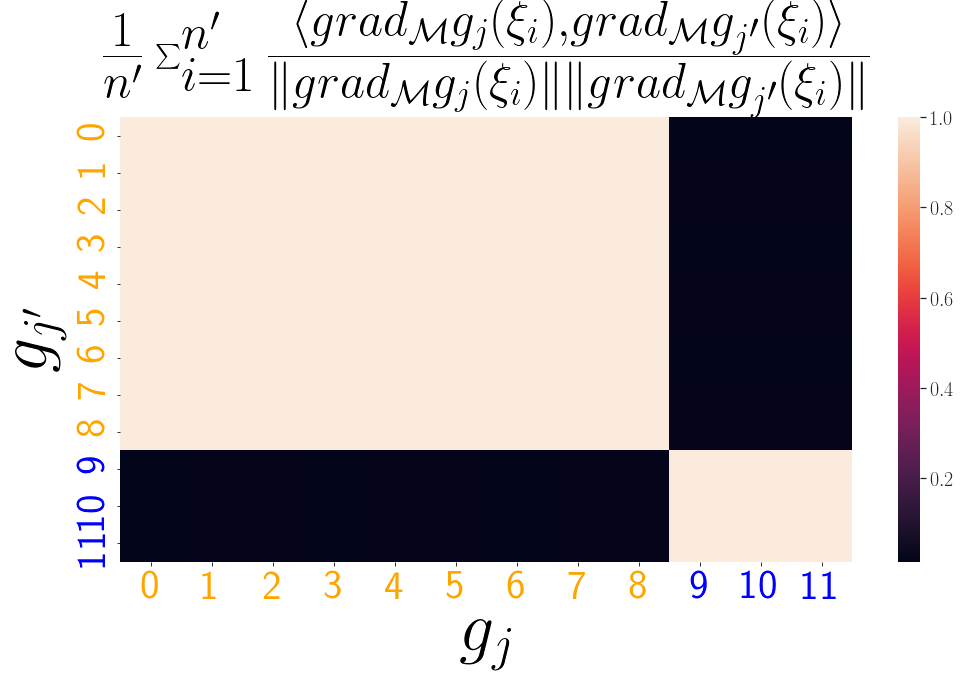

In [78]:
%matplotlib inline
fig, axes_all = plt.subplots(figsize=(15, 10))

sns.set(font_scale=2)
#[ax.set_axis_off() for ax in axarr.ravel()]
colors = np.hstack([np.repeat('orange',9), np.repeat('blue',3)])
plot_cosines(cosine, axes_all, colors)
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/re12_cosines_noise')

In [51]:

nreps = 25
#replicates_toluene ={}
for r in range(nreps):
    #r = 0 
    #replicates_toluene[r ] = Replicate()
    cs = rearrange(np.asarray(list(results[r][1].values())), 'l n p m -> l m n p')
    xaxis = np.asarray(np.asarray(list(results[r][1].keys())))
    xaxis_reorder = xaxis[xaxis.argsort()]
    cs_reorder = cs[xaxis.argsort()]
    xaxis_reorder = xaxis[xaxis.argsort()]
    replicates[r].cs = cs
    replicates[r].cs_reorder = cs_reorder
    replicates[r].xaxis_reorder = xaxis_reorder
    replicates[r].xaxis = xaxis
    
sel_l = np.zeros(nreps, dtype = int)
for r in range(nreps):
    for l in range(replicates[r].cs_reorder.shape[0]):
        nzeros = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[l] !=0.)[0]
        if len(nzeros) == 2:
            sel_l[r] = l
            
#almost_sel = {}
sel = {}
toplot = np.zeros((12,12))
for r in range(nreps):
    zeros = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]-1] !=0.)[0]
    sel[r] = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]] !=0.)[0]
    toplot[sel[r][0], sel[r][1]] += 1
    toplot[sel[r][1], sel[r][0]] += 1
    #toplot_tol[sel_tol[r][1]] += 1
    

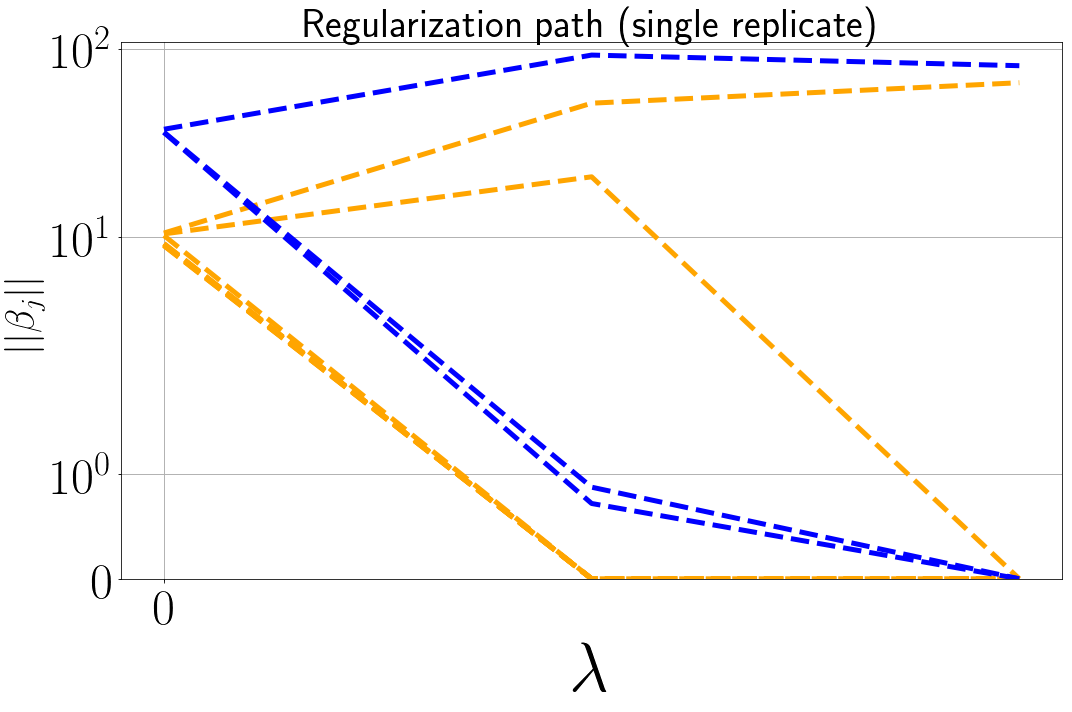

In [72]:

%matplotlib inline
fig, axes_all = plt.subplots(figsize=(15, 10))

#[ax.set_axis_off() for ax in axarr.ravel()]
colors = np.hstack([np.repeat('orange',9), np.repeat('blue',3)])
plot_reg_path_ax_lambdasearch_customcolors_norm(axes_all, replicates[0].cs_reorder, replicates[0].xaxis_reorder * np.sqrt(3 * 100), fig,colors)#axes_all[0].imshow(asdf)
axes_all.set_title('Regularization path (single replicate)', fontsize = 40)
axes_all.set_ylabel(r'$||\beta_j||$', fontsize = 40)
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/re12_replicate_noise')

1.0 0.0
0.8660254037844387 0.49999999999999994
0.5000000000000001 0.8660254037844386
6.123233995736766e-17 1.0
-0.4999999999999998 0.8660254037844388
-0.8660254037844385 0.5000000000000003
-1.0 1.2246467991473532e-16
-0.8660254037844388 -0.4999999999999998
-0.5000000000000004 -0.8660254037844384
-1.8369701987210297e-16 -1.0
0.4999999999999993 -0.866025403784439
0.8660254037844384 -0.5000000000000004


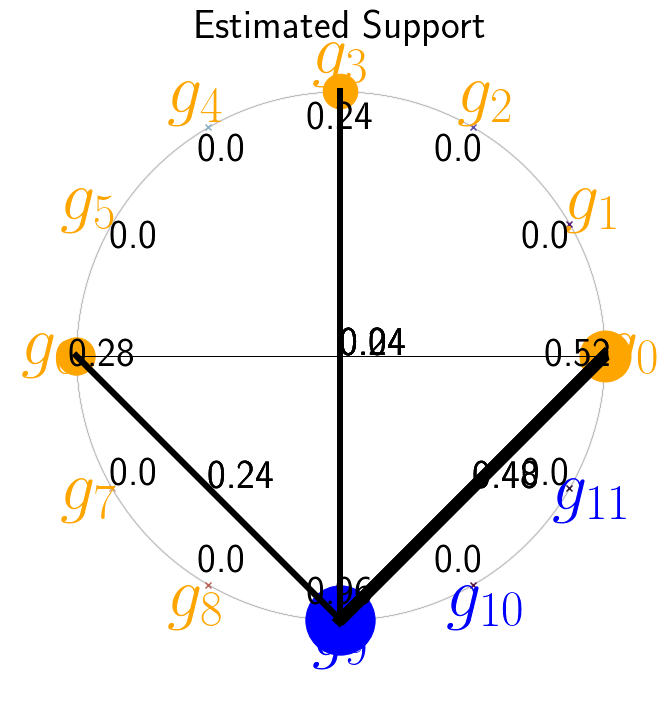

In [70]:

#%matplotlib inline
fig, axes_all = plt.subplots(figsize=(15, 10))

#[ax.set_axis_off() for ax in axarr.ravel()]
#colors = np.hstack([np.repeat('orange',9), np.repeat('blue',3)])
plot_watch_custom(toplot, 12, axes_all,colors)
axes_all.set_title('Estimated Support', fontsize = 40)
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/re12_support_noise')

1.0 0.0
0.8660254037844387 0.49999999999999994
0.5000000000000001 0.8660254037844386
6.123233995736766e-17 1.0
-0.4999999999999998 0.8660254037844388
-0.8660254037844385 0.5000000000000003
-1.0 1.2246467991473532e-16
-0.8660254037844388 -0.4999999999999998
-0.5000000000000004 -0.8660254037844384
-1.8369701987210297e-16 -1.0
0.4999999999999993 -0.866025403784439
0.8660254037844384 -0.5000000000000004


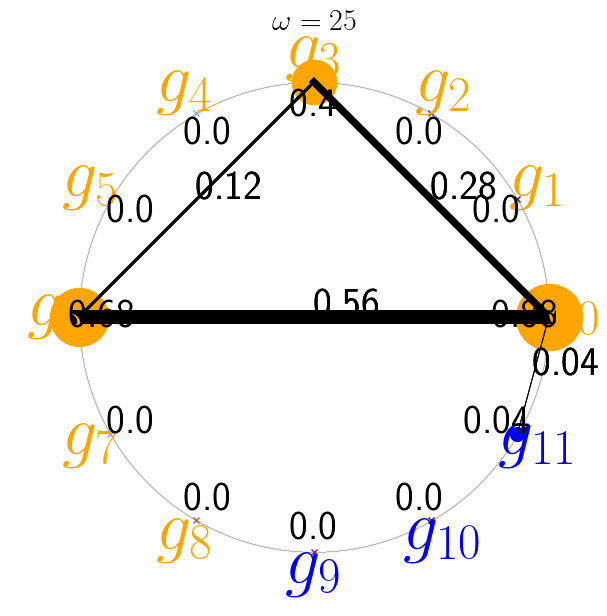

In [53]:

#%matplotlib inline
fig, axes_all = plt.subplots(figsize=(15, 10))

#[ax.set_axis_off() for ax in axarr.ravel()]
#colors = np.hstack([np.repeat('orange',9), np.repeat('blue',3)])
plot_watch_custom(toplot, 12, axes_all,colors)
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/re12_support_noise')

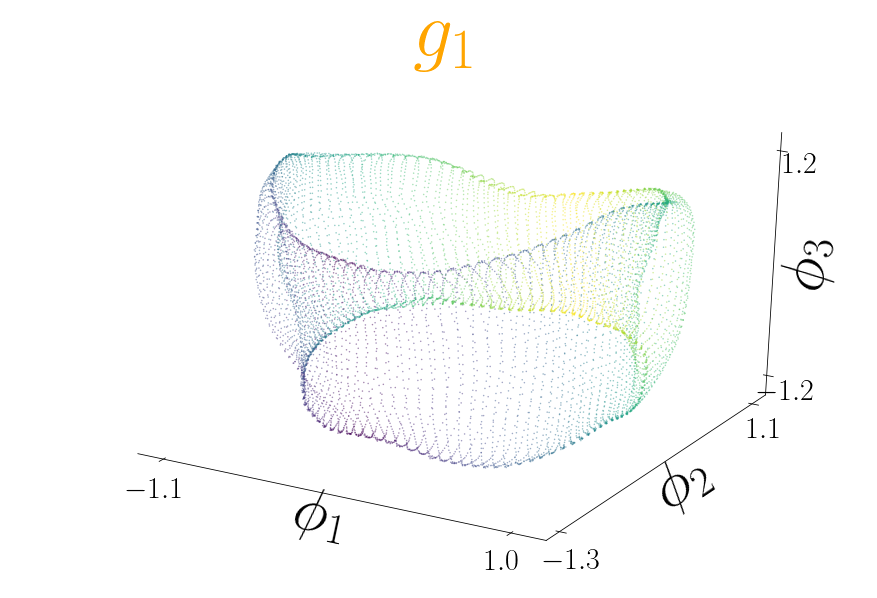

In [34]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(1,1, figsize = (15,10))

axs.set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(10000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(x, y, z, c = g1, s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 60)
ax.set_ylabel(r'$\phi_2$', fontsize = 60)
ax.set_zlabel(r'$\phi_3$', fontsize = 60)
ax.set_title(r'$g_{1}$', fontsize = 80, color = 'orange')

xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
ax.set_xticks([xmin, xmax])
ax.set_yticks([ymin, ymax])
ax.set_zticks([zmin, zmax])
ax.tick_params(labelsize=30)

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/re_groundtruth_g1')

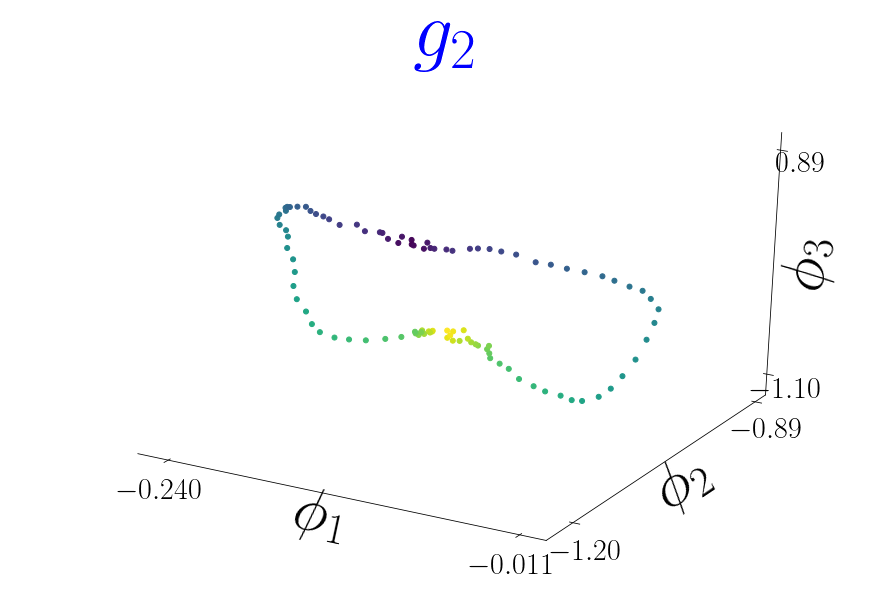

In [35]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
#s = 10000
alpha = 1

fig, axs = plt.subplots(1,1, figsize = (15,10))

axs.set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 100
#alpha = .5
selected_points = list(range(100))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(x, y, z, c = g2[selected_points], s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 60)
ax.set_ylabel(r'$\phi_2$', fontsize = 60)
ax.set_zlabel(r'$\phi_3$', fontsize = 60)
ax.set_title(r'$g_{2}$', fontsize = 80, color = 'blue')

xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
ax.set_xticks([xmin, xmax])
ax.set_yticks([ymin, ymax])
ax.set_zticks([zmin, zmax])
ax.tick_params(labelsize=30)

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/re_groundtruth_g2')

In [20]:

print('pre-gradient acquisition')
print(datetime.datetime.now())
for i in range(nreps):
    print(i)
    selected_points = np.random.choice(list(range(n)),nsel,replace = False)
    selected_points_save[i] = selected_points
    replicates[i] = Replicate()
    replicates[i].nsel = nsel
    replicates[i].selected_points = selected_points
    replicates[i].df_M,replicates[i].dg_M,replicates[i].dg_w ,replicates[i].dg_w_pca ,replicates[i].dgw_norm  = get_grads(experiment, experiment.Mpca, experiment.M, experiment.N, selected_points)
    replicates[i].dg_M = np.swapaxes(replicates[i].dg_M, 1,2)

pre-gradient acquisition
2021-01-10 20:07:21.560664
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [ ]:

with open(workingdirectory + '/untracked_data/embeddings/' + savefolder + '/' + savename + 'replicates.pkl' ,
         'wb') as output:
     pickle.dump(replicates, output, pickle.HIGHEST_PROTOCOL)

In [ ]:



selected_points_save = np.asarray(selected_points_save, dtype = int)
gl_itermax = 500
lambdas_start = [0.,.0005 * np.sqrt(nsel * p)]
max_search = 30
reg_l2 = 0.
card = dim
tol = 1e-14
learning_rate = 100

from pathos.multiprocessing import ProcessingPool as Pool
from codes.flasso.GradientGroupLasso import batch_stream, get_sr_lambda_sam_parallel

print('pre-gradient descent')
print(datetime.datetime.now())
cores = 16
# pcor = Pool(cores)
# results = pcor.map(lambda replicate: get_sr_lambda_sam_parallel(replicate, gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate), batch_stream(replicates))

results = {}
for r in range(nreps):
    print(r)
    results[r] = Replicate()
    results[r] = get_sr_lambda_sam_parallel(replicates[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)


with open(workingdirectory + '/untracked_data/embeddings/' + savefolder + '/' + savename + 'results.pkl' ,
         'wb') as output:
     pickle.dump(results, output, pickle.HIGHEST_PROTOCOL)

print('done')
print(datetime.datetime.now())

In [75]:
def plot_watch_custom(to_plot, p, ax,colors):
    #fig, ax = plt.subplots(figsize = (15,15))
    #%matplotlib inline
    
    #fig, ax = plt.subplots(figsize = (15,15))
    theta = np.linspace(0, 2*np.pi, 10000)
    cmap = plt.get_cmap('twilight_shifted',p)
    
    angles = np.linspace(0, 2*np.pi, p+1)
    
    radius = 1.

    a = radius*np.cos(theta)
    b = radius*np.sin(theta)

    #figure, axes = plt.subplots(figsize = (15,15))

    #axes.plot(a, b, color= 'gray')
    ax.scatter(a, b, color = 'gray', s= .2, alpha = .1)#, '-', color = 'gray')#, s= .1, alpha = .1)#, type = 'line')#,cmap=plt.get_cmap('twilight')) #'hsv','twilight_shifted

    #for i in range(to_plot.shape)
    if len(to_plot.shape) > 1:
        totes = np.sum(to_plot, axis = 0)
    else:
        totes = to_plot
        
    for j in range(p):
        print(np.cos(angles[j]), np.sin(angles[j]))#r'$test \frac{1}{}$'.format(g)
        ax.scatter(np.cos(angles[j]),np.sin(angles[j]),color=cmap.colors[j], marker  = 'x')
        ax.text( x = 1.1*np.cos(angles[j]),
                  y = 1.1*np.sin(angles[j]),
                  s = r"$g_{{{}}}$".format(j),color=colors[j],#cmap.colors[j],
                  fontdict = {'fontsize' : 70},
                  horizontalalignment='center',
         verticalalignment='center')



        ax.text( x = .9*np.cos(angles[j]),y = .9*np.sin(angles[j]),s = str(totes[j] / nreps), fontdict = {'fontsize' : 40},
                  horizontalalignment='center',
         verticalalignment='center')



    for j in range(p):
        ax.scatter(np.cos(angles[j]),np.sin(angles[j]),color=colors[j], marker  = 'o', s = 200*totes[j] )

    if len(to_plot.shape) > 1:
        for i in range(p):
            for j in range(p):

                #point1 = [1, 2]
                #point2 = [3, 4]

                x_values = [np.cos(angles[j]), np.cos(angles[i])]
                #gather x-values

                y_values = [np.sin(angles[j]), np.sin(angles[i])]
                #gather y-values

                ax.plot(x_values, y_values,linewidth = to_plot[i,j], color = 'black')

                if to_plot[i,j] > 0 :
                    ax.text( x = np.mean(x_values),
                      y = np.mean(y_values),
                      s = str(to_plot[i,j] / nreps),
                      fontdict = {'fontsize' : 40})#,
                  #horizontalalignment='left',
                # verticalalignment='bottom')

                #axes.axline((x1, y1), (x2, y2))
    ax.set_aspect(1)
    ax.set_axis_off()
    ax.set_title(r"$\omega = 25$")
    
def plot_cosines(cosines, ax, colors):
    p = cosines.shape[0]
    sns.heatmap(cosines ,ax = ax)
#    ax = sns.heatmap(x, cmap=cmap)
    # use matplotlib.colorbar.Colorbar object
    cbar = ax.collections[0].colorbar
    # here set the labelsize by 20
    cbar.ax.tick_params(labelsize=20)

    for xtick, color in zip(ax.get_xticklabels(), colors):
        xtick.set_color(color)
    for ytick, color in zip(ax.get_yticklabels(), colors):
        ytick.set_color(color)
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 500 / p)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 500 / p)
    
    ax.set_ylabel(r"$g_{j'}$", fontsize = 70)
    ax.set_xlabel(r"$g_{j}$", fontsize = 70)
    #ax.set_title(r"$\text{hi}$")
    ax.set_title(r"$\frac{1}{n'} \sum_{i = 1}^{n'} \frac{\langle grad_{\mathcal M} g_j (\xi_i) ,grad_{\mathcal M} g_{j'} (\xi_i)\rangle}{\|grad_{\mathcal M} g_j (\xi_i) \| \| grad_{\mathcal M} g_{j'}(\xi_i) \|} $",
                fontsize = 70)

def plot_reg_path_ax_lambdasearch_customcolors_norm(ax, coeffs, xaxis,fig, colors):
    p = coeffs.shape[3]
    q = coeffs.shape[1]
    gnames = np.asarray(list(range(p)), dtype=str)

    rcParams['axes.titlesize'] = 30
    plt.rc('text', usetex=True)

    normax = np.sqrt(np.sum(np.sum(np.sum(coeffs ** 2, axis=1), axis=1), axis=1).max())

    for j in range(p):
        toplot = np.linalg.norm(np.linalg.norm(coeffs[:, :, :, j], axis=2), axis=1)
        # axes[0].boxplot(toplot, positions=xaxis, showfliers=False, vert=True, widths=widths,medianprops=dict(linestyle=''))
        ax.plot(xaxis, toplot, 'go--', linewidth=5, markersize=0, alpha=1.,
                     color=colors[j], label=gnames[j])

    kkk = xaxis.copy()
    kkk.sort()

    # xupperindex = np.min(np.where(np.sum(np.sum(np.sum(coeffs**2, axis = 1), axis = 1), axis = 1) ==0)[0])

    #for k in range(1 + q):
    ax.tick_params(labelsize=50)
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    ax.set_ylim(bottom=0, top=normax)
    # axes[k].set_xlim(left = 0, right = xaxis[xupperindex])
    #if (k == 0):
    tixx = np.hstack(
        [np.asarray([0]), 10 ** np.linspace(math.floor(np.log10(normax)), math.floor(np.log10(normax)) + 1, 2)])
#    if k != 0:
        # axes[k].set_yticks(tixx)
    ax.set_ylabel(r"$\displaystyle \|\hat \beta_{j}\|_2$", fontsize = 70)
    ax.set_xlabel(r"$\lambda  $", fontsize = 70)#\sqrt{nm}
    #ylabel = r"$\displaystyle \|\hat \beta_{j}\|_2$"
    #ax.l
    #if k == 0:
    #ax.set_title("Combined", fontdict={'fontsize': 50})
    ax.grid(True, which="both", alpha=True)

    #handles, labels = ax.get_legend_handles_labels()
    #by_label = OrderedDict(zip(labels, handles))
    # fig.text(0.5, 0.04, xlabel, ha='center', va='center', fontsize=50)
    # fig.text(0.05, 0.5, ylabel, ha='center', va='center', rotation='vertical', fontsize=60)
    #fig.subplots_adjust(right=0.75)
    #leg_ax = fig.add_axes([.8, 0.15, 0.05, 0.7])
    #leg_ax.axis('off')
    #leg = leg_ax.legend(by_label.values(), gnames, prop={'size': 200 / p})
    # leg.set_title('Torsion', prop={'size': Function})
    #for l in leg.get_lines():
    #    l.set_alpha(1)
    # fig.savefig(filename + 'beta_paths_n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(
    #    nreps))
    

def plot_reg_path_ax_lambdasearch_customcolors(axes, coeffs, xaxis,fig, colors):
    p = coeffs.shape[3]
    q = coeffs.shape[1]
    gnames = np.asarray(list(range(p)), dtype=str)

    # xlabel = r"$\displaystyle \lambda$"
    # ylabel = r"$\displaystyle \|\hat \beta_{j}\|_2$"
    rcParams['axes.titlesize'] = 30
    plt.rc('text', usetex=True)

    # maxes = np.zeros(q)
    # for k in range(q):
    #     maxes[k] = np.linalg.norm(coeffs[:, k, :, :], axis=1).max()
    # normax = maxes.max()
    normax = np.sqrt(np.sum(np.sum(np.sum(coeffs ** 2, axis=1), axis=1), axis=1).max())

    for k in range(q):
        for j in range(p):
            toplot = np.linalg.norm(coeffs[:, k, :, j], axis=1)
            w = .15
            widths = np.asarray([width(xaxis[i], w) for i in range(len(xaxis))])
            # axes[k+1].boxplot(toplot, positions=xaxis, showfliers=False, vert=True, widths=widths,medianprops=dict(linestyle=''))
            axes[k + 1].plot(xaxis, toplot, 'go--', linewidth=5, markersize=0, alpha=1.,
                             color=colors[j], label=gnames[j])
    for j in range(p):
        toplot = np.linalg.norm(np.linalg.norm(coeffs[:, :, :, j], axis=2), axis=1)
        # axes[0].boxplot(toplot, positions=xaxis, showfliers=False, vert=True, widths=widths,medianprops=dict(linestyle=''))
        axes[0].plot(xaxis, toplot, 'go--', linewidth=5, markersize=0, alpha=1.,
                     color=colors[j], label=gnames[j])

    kkk = xaxis.copy()
    kkk.sort()

    # xupperindex = np.min(np.where(np.sum(np.sum(np.sum(coeffs**2, axis = 1), axis = 1), axis = 1) ==0)[0])

    for k in range(1 + q):
        axes[k].tick_params(labelsize=50)
        axes[k].set_xscale('symlog')
        axes[k].set_yscale('symlog')
        axes[k].set_ylim(bottom=0, top=normax)
        # axes[k].set_xlim(left = 0, right = xaxis[xupperindex])
        if (k == 0):
            tixx = np.hstack(
                [np.asarray([0]), 10 ** np.linspace(math.floor(np.log10(normax)), math.floor(np.log10(normax)) + 1, 2)])
        if k != 0:
            # axes[k].set_yticks(tixx)
            axes[k].set_yticklabels([])
        if k != q:
            axes[k+1].set_title(r"$\phi_{{{}}}$".format(k+1), fontsize = 50)
            #axes[k + 1].set_title(r"$\phi_{{{}}}$.format(k)")
        if k == 0:
            axes[k].set_title("Combined", fontdict={'fontsize': 50})
    for k in range(1 + q):
        axes[k].grid(True, which="both", alpha=True)
        axes[k].set_xlabel(r"$\lambda$", fontsize = 50)
        
    axes[0].set_ylabel(r"$\|\beta\|$", fontsize = 50)
        
    handles, labels = axes[0].get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    # fig.text(0.5, 0.04, xlabel, ha='center', va='center', fontsize=50)
    # fig.text(0.05, 0.5, ylabel, ha='center', va='center', rotation='vertical', fontsize=60)
    fig.subplots_adjust(right=0.75)
    leg_ax = fig.add_axes([.8, 0.15, 0.05, 0.7])
    leg_ax.axis('off')
    leg = leg_ax.legend(by_label.values(), gnames, prop={'size': 200 / p})
    # leg.set_title('Torsion', prop={'size': Function})
    for l in leg.get_lines():
        l.set_alpha(1)
    # fig.savefig(filename + 'beta_paths_n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(
    #    nreps))



In [29]:
cosine = get_cosines(np.swapaxes(replicates[0].dg_M,1,2))
#mal_cosine = get_cosines(np.swapaxes(replicates_malonaldehyde[0].dg_M,1,2))
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

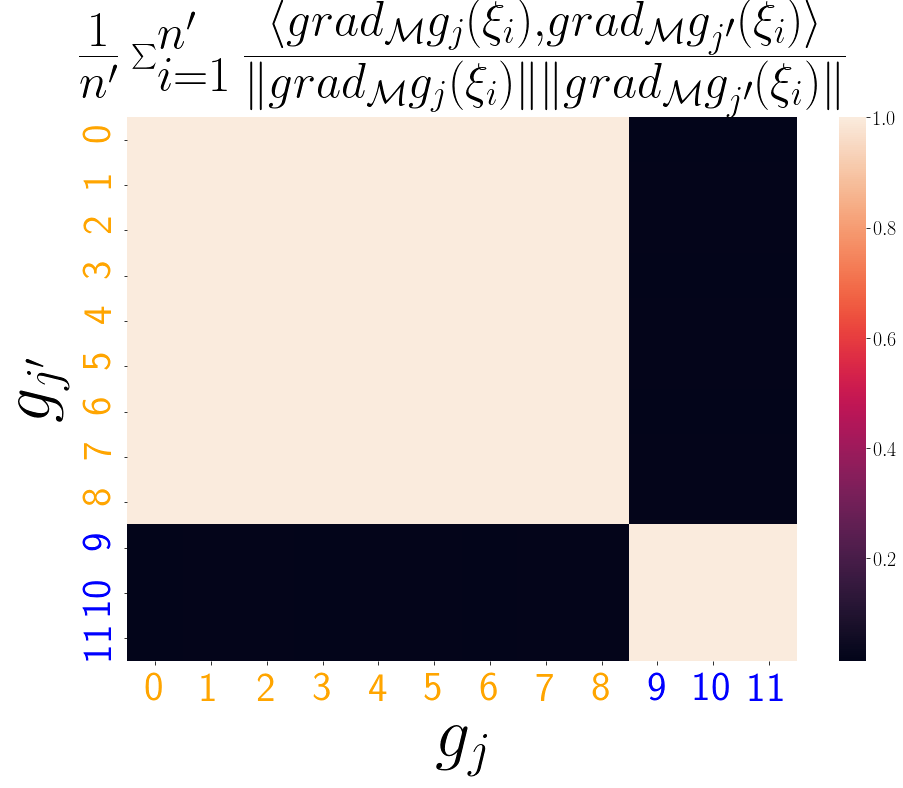

In [76]:
%matplotlib inline
fig, axes_all = plt.subplots(figsize=(15, 10))

#[ax.set_axis_off() for ax in axarr.ravel()]
colors = np.hstack([np.repeat('orange',9), np.repeat('blue',3)])
plot_cosines(cosine, axes_all, colors)
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/re12_cosines')

In [30]:
from einops import rearrange

In [31]:
cosine

array([[1.        , 0.99933368, 0.99933228, 0.99996453, 0.99918413,
        0.99918649, 0.99998611, 0.99932375, 0.99932372, 0.01678183,
        0.01676276, 0.01675861],
       [0.99933368, 1.        , 0.99999966, 0.99935962, 0.99994307,
        0.99994602, 0.99931739, 0.99998638, 0.99998744, 0.02173932,
        0.02171786, 0.02171285],
       [0.99933228, 0.99999966, 1.        , 0.9993559 , 0.99993983,
        0.99994347, 0.99931458, 0.99998462, 0.99998637, 0.02173402,
        0.02171265, 0.02170765],
       [0.99996453, 0.99935962, 0.9993559 , 1.        , 0.99929683,
        0.99929663, 0.99998016, 0.99937907, 0.99937673, 0.01699418,
        0.01697168, 0.01696745],
       [0.99918413, 0.99994307, 0.99993983, 0.99929683, 1.        ,
        0.99999965, 0.99920388, 0.99996589, 0.99996407, 0.02215922,
        0.02213331, 0.02212853],
       [0.99918649, 0.99994602, 0.99994347, 0.99929663, 0.99999965,
        1.        , 0.99920473, 0.99996733, 0.9999662 , 0.02214893,
        0.02212313,